# Receiver Function

<!-- Please leave the cell below as it is -->

[![Open In Colab](https://img.shields.io/badge/open%20in-Colab-b5e2fa?logo=googlecolab&style=flat-square&color=ffd670)](https://colab.research.google.com/github/inlab-geo/cofi-examples/blob/main/examples/receiver_function/receiver_function.ipynb)

<!-- Again, please don't touch the markdown cell above. We'll generate badge 
     automatically from the above cell. -->

<!-- This cell describes things related to environment setup, so please add more text 
     if something special (not listed below) is needed to run this notebook -->

> If you are running this notebook locally, make sure you've followed [steps here](https://github.com/inlab-geo/cofi-examples#run-the-examples-with-cofi-locally)
to set up the environment. (This [environment.yml](https://github.com/inlab-geo/cofi-examples/blob/main/envs/environment.yml) file
specifies a list of packages required to run the notebooks)

Receiver functions are a class of seismic data used to study discontinuities (layering) in the Earth's crust. At each discontinuity, P-to-S conversions occur, introducing complexity in the waveform. By deconvolving horizontal- and vertical-channel waveforms from earthquakes at teleseismic distances, we can isolate information about these conversions, and hence learn about the crustal structure. This deconvolved signal is the receiver function, and has a highly non-linear dependence on the local crustal properties.

We refer you to the paper below for description of the algorithms and the forward kernel we use:

*Genetic algorithm inversion for receiver functions with application to crust and uppermost mantle structure beneath Eastern Australia*,
Shibutani, T., Kennett, B. and Sambridge, M., Geophys. Res. Lett., 23 , No. 4, 1829-1832, 1996.

In this notebook, we run inversion on a toy model with optimisation and parallel sampling.

## 0. Import modules

In [1]:
# -------------------------------------------------------- #
#                                                          #
#     Uncomment below to set up environment on "colab"     #
#                                                          #
# -------------------------------------------------------- #

# !pip install -U cofi geo-espresso

In [2]:
import os
import math
import numpy as np
import matplotlib.pyplot as plt
import arviz
import emcee
import multiprocessing

import cofi
import espresso

In [3]:
# randomness is used to initialise emcee walkers starting points
np.random.seed(42)

We are going to use the receiver function kernel wrapped in 
[`espresso`](https://geo-espresso.readthedocs.io/en/latest/user_guide/contrib/generated/_receiver_function/index.html),
with calls to Fortran routines developed by Takuo Shibutani in the backend.

In [4]:
my_receiver_function = espresso.ReceiverFunctionInversion(example_number=4)

Consider a model setup of `n` layers described with 3 parameters for each layer. `model` is a NumPy array of dimension `[nlayers,3]`. The values in `model[:,0]` give the depths of discontinuities in the model, while `model[:,1]` contains the S-wave speed above the interface. `model[:,2]` is the ratio of S-wave speed to P-wave speed. The maximum depth of discontinuity that can be considered is 60km.

In this example, we fix the ratio of S-wave speed to P-wave speed, and treat the interface depths and velocities of 5 layers as unknowns.

In order to better understand the complexity and non-linear nature of seismic receiver function inversion, we have included a few illustrative animations. These animations highlight the substantial influence of velocities and, more prominently, interface depths on the resulting receiver functions.

![depth_layer3_anim4.gif](https://github.com/inlab-geo/cofi-examples/blob/main/examples/receiver_function/depth_layer3_anim4.gif?raw=true)

![vel_layer3_anim4_400f.gif](https://github.com/inlab-geo/cofi-examples/blob/main/examples/receiver_function/vel_layer3_anim4_400f.gif?raw=true)

This is a non-linear problem which can be highly sensitive to the starting model. 

![3Dsurf_x40y10_v55_l270_35](https://github.com/inlab-geo/cofi-examples/blob/main/examples/receiver_function/3Dsurf_x40y10_v55_l270_35.png?raw=true)

Here we set a starting model that is reasonably close to the true model, so that the optimisation converges.

In [5]:
null_model = my_receiver_function.starting_model 

print(f"Number of model parameters in this example: {null_model.size}")
my_receiver_function._model_setup(null_model)

Number of model parameters in this example: 6


array([[ 9. ,  4. ,  1.7],
       [20. ,  5. ,  1.7],
       [50. ,  6. ,  1.7]])

Let's plot the starting Earth model.

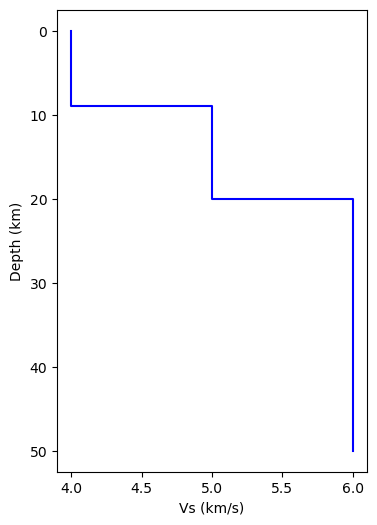

In [6]:
my_receiver_function.plot_model(null_model);

Now we calculate the receiver function and plot it

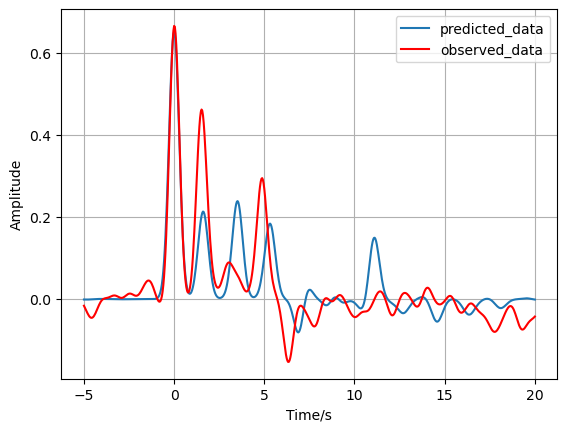

In [7]:
predicted_data = my_receiver_function.forward(null_model)
observed_data = my_receiver_function.data 
my_receiver_function.plot_data(
    data1=predicted_data, 
    data2=observed_data, 
    label="predicted_data", 
    label2="observed_data", 
)
plt.legend();

## 1. Solve with an optimiser

### 1.1 Define BaseProblem

In [8]:
my_problem = cofi.BaseProblem()

In preparation for optimisation:

In [9]:
def my_misfit(model, include_uncertainty=False):
    predicted_data = my_receiver_function.forward(model)
    misfit_val = my_receiver_function.misfit(predicted_data, observed_data)
    if math.isnan(misfit_val):
        return float("inf")
    return misfit_val

my_problem.set_objective(my_misfit)
my_problem.set_initial_model(null_model)

my_problem.summary()

Summary for inversion problem: BaseProblem
Model shape: (6,)
---------------------------------------------------------------------
List of functions/properties set by you:
['objective', 'initial_model', 'model_shape']
---------------------------------------------------------------------
List of functions/properties created based on what you have provided:
-- none --
---------------------------------------------------------------------
List of functions/properties that can be further set for the problem:
( not all of these may be relevant to your inversion workflow )
['log_posterior', 'log_posterior_with_blobs', 'log_likelihood', 'log_prior', 'gradient', 'hessian', 'hessian_times_vector', 'residual', 'jacobian', 'jacobian_times_vector', 'data_misfit', 'regularization', 'regularization_matrix', 'forward', 'data', 'data_covariance', 'data_covariance_inv', 'blobs_dtype', 'bounds', 'constraints']


### 1.2 Define InversionOptions

In [10]:
my_options_optimiser = cofi.InversionOptions()
my_options_optimiser.set_tool("scipy.optimize.minimize")
my_options_optimiser.set_params(method="Nelder-Mead")   # Nelder-Mead or COBYLA

### 1.3 Define Inversion and run

In [11]:
inv_optimiser = cofi.Inversion(my_problem, my_options_optimiser)
my_result_optimiser = inv_optimiser.run()
my_result_optimiser.summary()

Summary for inversion result
SUCCESS
----------------------------
fun: 115.39751400472517
nit: 354
nfev: 626
status: 0
message: Optimization terminated successfully.
final_simplex: (array([[13.85639283,  4.17913654, 14.08543262,  6.06974444, 55.79409477,
         6.25070115],
       [13.85639288,  4.17913657, 14.08543272,  6.06974443, 55.79409465,
         6.25070114],
       [13.85639283,  4.17913656, 14.08543275,  6.06974443, 55.79409457,
         6.25070114],
       [13.85639282,  4.17913655, 14.08543263,  6.06974441, 55.79409493,
         6.25070114],
       [13.85639288,  4.17913657, 14.08543277,  6.0697444 , 55.79409483,
         6.25070113],
       [13.85639235,  4.17913654, 14.08543308,  6.06974446, 55.7940928 ,
         6.25070116],
       [13.85639335,  4.17913658, 14.08543234,  6.06974445, 55.79409588,
         6.25070117]]), array([115.397514, 115.397514, 115.397514, 115.397514, 115.397514,
       115.397514, 115.397514]))
model: [13.85639283  4.17913654 14.08543262  6.0697

In [12]:
print("Inversion result:    ", my_result_optimiser.model)
print("Reference good model:", my_receiver_function.good_model)

Inversion result:     [13.85639283  4.17913654 14.08543262  6.06974444 55.79409477  6.25070115]
Reference good model: [ 8.   4.2 20.   6.  45.   6.2]


### 1.4 Plotting

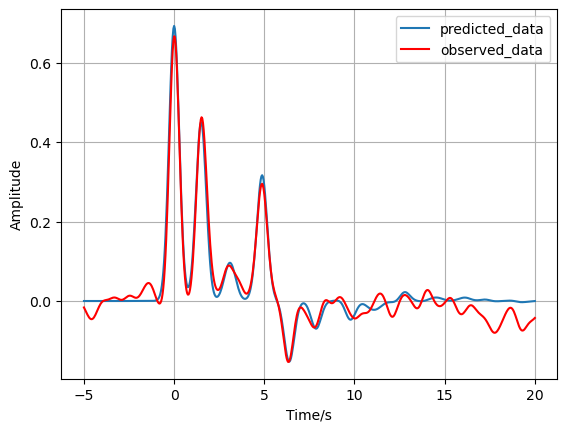

In [13]:
predicted_data = my_receiver_function.forward(my_result_optimiser.model)
my_receiver_function.plot_data(
    data1=predicted_data, 
    data2=observed_data, 
    label="predicted_data", 
    label2="observed_data", 
)
plt.legend();

## 2. Solve with a sampler

### 2.1 Enrich BaseProblem

In preparation for sampling:

In [14]:
def my_log_likelihood(model):
    data1 = my_receiver_function.data
    data2 = my_receiver_function.forward(model)
    log_likelihood = my_receiver_function.log_likelihood(data1, data2) / 20 # temper the likelihood
    return log_likelihood

def my_log_prior(model):
    log_prior = my_receiver_function.log_prior(model)
    return log_prior

ndim = my_receiver_function.model_size

my_problem.set_model_shape(ndim)
my_problem.set_log_likelihood(my_log_likelihood)
my_problem.set_log_prior(my_log_prior)

my_problem.summary()

Summary for inversion problem: BaseProblem
Model shape: 6
---------------------------------------------------------------------
List of functions/properties set by you:
['objective', 'log_likelihood', 'log_prior', 'initial_model', 'model_shape', 'blobs_dtype']
---------------------------------------------------------------------
List of functions/properties created based on what you have provided:
['log_posterior', 'log_posterior_with_blobs']
---------------------------------------------------------------------
List of functions/properties that can be further set for the problem:
( not all of these may be relevant to your inversion workflow )
['log_posterior', 'log_posterior_with_blobs', 'gradient', 'hessian', 'hessian_times_vector', 'residual', 'jacobian', 'jacobian_times_vector', 'data_misfit', 'regularization', 'regularization_matrix', 'forward', 'data', 'data_covariance', 'data_covariance_inv', 'bounds', 'constraints']


In [15]:
nwalkers = 12
nsteps = 25000
walkers_start = my_result_optimiser.model + 1e-1 * np.random.randn(nwalkers, ndim)

We can run `emcee` in parallel. Some additional preparation:

### 2.2 Define InversionOptions, Inversion and run

In [16]:
import warnings
warnings.filterwarnings("ignore")

my_options_sampler = cofi.InversionOptions()
my_options_sampler.set_tool("emcee")
my_options_sampler.set_params(
    nwalkers=nwalkers,
    nsteps=nsteps,
    initial_state=walkers_start,
    progress=True,
)
inv_sampler = cofi.Inversion(my_problem, my_options_sampler)
inv_result_sampler = inv_sampler.run()

  0%|                                                                                                              | 0/25000 [00:00<?, ?it/s]

  0%|                                                                                                      | 9/25000 [00:00<05:00, 83.16it/s]

  0%|                                                                                                     | 18/25000 [00:00<05:10, 80.45it/s]

  0%|                                                                                                     | 27/25000 [00:00<05:04, 82.03it/s]

  0%|▏                                                                                                    | 36/25000 [00:00<05:02, 82.43it/s]

  0%|▏                                                                                                    | 45/25000 [00:00<05:02, 82.40it/s]

  0%|▏                                                                                                    | 55/25000 [00:00<04:54, 84.82it/s]

  0%|▎                                                                                                    | 64/25000 [00:00<04:55, 84.40it/s]

  0%|▎                                                                                                    | 73/25000 [00:00<04:55, 84.32it/s]

  0%|▎                                                                                                    | 82/25000 [00:00<04:54, 84.51it/s]

  0%|▎                                                                                                    | 91/25000 [00:01<04:52, 85.08it/s]

  0%|▍                                                                                                   | 101/25000 [00:01<04:46, 86.88it/s]

  0%|▍                                                                                                   | 110/25000 [00:01<04:45, 87.30it/s]

  0%|▍                                                                                                   | 119/25000 [00:01<04:42, 88.06it/s]

  1%|▌                                                                                                   | 128/25000 [00:01<04:46, 86.80it/s]

  1%|▌                                                                                                   | 137/25000 [00:01<04:46, 86.90it/s]

  1%|▌                                                                                                   | 146/25000 [00:01<04:45, 87.01it/s]

  1%|▌                                                                                                   | 155/25000 [00:01<04:47, 86.31it/s]

  1%|▋                                                                                                   | 164/25000 [00:01<04:50, 85.61it/s]

  1%|▋                                                                                                   | 173/25000 [00:02<04:48, 86.09it/s]

  1%|▋                                                                                                   | 183/25000 [00:02<04:43, 87.56it/s]

  1%|▊                                                                                                   | 193/25000 [00:02<04:34, 90.29it/s]

  1%|▊                                                                                                   | 203/25000 [00:02<04:30, 91.58it/s]

  1%|▊                                                                                                   | 213/25000 [00:02<04:28, 92.21it/s]

  1%|▉                                                                                                   | 223/25000 [00:02<04:26, 92.98it/s]

  1%|▉                                                                                                   | 233/25000 [00:02<04:21, 94.63it/s]

  1%|▉                                                                                                   | 243/25000 [00:02<04:22, 94.27it/s]

  1%|█                                                                                                   | 253/25000 [00:02<04:20, 94.93it/s]

  1%|█                                                                                                   | 263/25000 [00:02<04:20, 94.98it/s]

  1%|█                                                                                                   | 273/25000 [00:03<04:22, 94.28it/s]

  1%|█▏                                                                                                  | 283/25000 [00:03<04:25, 93.22it/s]

  1%|█▏                                                                                                  | 293/25000 [00:03<04:53, 84.06it/s]

  1%|█▏                                                                                                  | 302/25000 [00:03<04:49, 85.43it/s]

  1%|█▏                                                                                                  | 311/25000 [00:03<04:44, 86.68it/s]

  1%|█▎                                                                                                  | 320/25000 [00:03<04:44, 86.63it/s]

  1%|█▎                                                                                                  | 329/25000 [00:03<04:44, 86.59it/s]

  1%|█▎                                                                                                  | 339/25000 [00:03<04:38, 88.43it/s]

  1%|█▍                                                                                                  | 348/25000 [00:03<04:40, 87.86it/s]

  1%|█▍                                                                                                  | 357/25000 [00:04<04:59, 82.15it/s]

  1%|█▍                                                                                                  | 366/25000 [00:04<05:05, 80.51it/s]

  2%|█▌                                                                                                  | 375/25000 [00:04<05:20, 76.87it/s]

  2%|█▌                                                                                                  | 385/25000 [00:04<04:58, 82.36it/s]

  2%|█▌                                                                                                  | 395/25000 [00:04<04:43, 86.74it/s]

  2%|█▌                                                                                                  | 405/25000 [00:04<04:33, 90.00it/s]

  2%|█▋                                                                                                  | 415/25000 [00:04<04:28, 91.57it/s]

  2%|█▋                                                                                                  | 426/25000 [00:04<04:17, 95.38it/s]

  2%|█▋                                                                                                 | 438/25000 [00:04<04:04, 100.62it/s]

  2%|█▊                                                                                                 | 449/25000 [00:05<03:58, 102.80it/s]

  2%|█▊                                                                                                 | 460/25000 [00:05<03:56, 103.87it/s]

  2%|█▊                                                                                                 | 472/25000 [00:05<03:49, 106.87it/s]

  2%|█▉                                                                                                 | 483/25000 [00:05<03:50, 106.58it/s]

  2%|█▉                                                                                                 | 494/25000 [00:05<03:50, 106.47it/s]

  2%|█▉                                                                                                 | 505/25000 [00:05<03:48, 107.08it/s]

  2%|██                                                                                                 | 516/25000 [00:05<03:48, 107.18it/s]

  2%|██                                                                                                 | 527/25000 [00:05<03:48, 106.92it/s]

  2%|██▏                                                                                                | 538/25000 [00:05<03:49, 106.77it/s]

  2%|██▏                                                                                                | 549/25000 [00:05<03:54, 104.35it/s]

  2%|██▏                                                                                                | 561/25000 [00:06<03:51, 105.74it/s]

  2%|██▎                                                                                                | 572/25000 [00:06<03:53, 104.70it/s]

  2%|██▎                                                                                                | 584/25000 [00:06<03:48, 106.70it/s]

  2%|██▎                                                                                                | 595/25000 [00:06<03:50, 106.02it/s]

  2%|██▍                                                                                                | 606/25000 [00:06<03:49, 106.16it/s]

  2%|██▍                                                                                                | 617/25000 [00:06<03:48, 106.79it/s]

  3%|██▍                                                                                                | 628/25000 [00:06<03:49, 106.42it/s]

  3%|██▌                                                                                                | 639/25000 [00:06<03:51, 105.18it/s]

  3%|██▌                                                                                                | 651/25000 [00:06<03:46, 107.41it/s]

  3%|██▋                                                                                                | 663/25000 [00:07<03:44, 108.42it/s]

  3%|██▋                                                                                                | 675/25000 [00:07<03:44, 108.48it/s]

  3%|██▋                                                                                                | 686/25000 [00:07<03:50, 105.61it/s]

  3%|██▊                                                                                                | 697/25000 [00:07<03:50, 105.62it/s]

  3%|██▊                                                                                                | 708/25000 [00:07<03:52, 104.35it/s]

  3%|██▉                                                                                                 | 719/25000 [00:07<04:14, 95.50it/s]

  3%|██▉                                                                                                 | 729/25000 [00:07<04:30, 89.63it/s]

  3%|██▉                                                                                                 | 739/25000 [00:07<05:26, 74.32it/s]

  3%|██▉                                                                                                 | 747/25000 [00:08<05:58, 67.73it/s]

  3%|███                                                                                                 | 755/25000 [00:08<06:22, 63.44it/s]

  3%|███                                                                                                 | 762/25000 [00:08<07:37, 53.03it/s]

  3%|███                                                                                                 | 768/25000 [00:08<07:28, 54.04it/s]

  3%|███                                                                                                 | 774/25000 [00:08<08:41, 46.44it/s]

  3%|███▏                                                                                                | 784/25000 [00:08<07:25, 54.35it/s]

  3%|███▏                                                                                                | 795/25000 [00:08<06:12, 65.04it/s]

  3%|███▏                                                                                                | 806/25000 [00:09<05:20, 75.47it/s]

  3%|███▎                                                                                                | 817/25000 [00:09<04:48, 83.84it/s]

  3%|███▎                                                                                                | 828/25000 [00:09<04:31, 88.91it/s]

  3%|███▎                                                                                                | 839/25000 [00:09<04:21, 92.50it/s]

  3%|███▍                                                                                                | 850/25000 [00:09<04:16, 94.26it/s]

  3%|███▍                                                                                                | 861/25000 [00:09<04:10, 96.28it/s]

  3%|███▍                                                                                                | 872/25000 [00:09<04:03, 98.99it/s]

  4%|███▌                                                                                                | 883/25000 [00:09<04:48, 83.51it/s]

  4%|███▌                                                                                                | 892/25000 [00:10<05:14, 76.57it/s]

  4%|███▌                                                                                                | 902/25000 [00:10<04:56, 81.35it/s]

  4%|███▋                                                                                                | 912/25000 [00:10<04:43, 85.04it/s]

  4%|███▋                                                                                                | 923/25000 [00:10<04:27, 89.97it/s]

  4%|███▋                                                                                                | 934/25000 [00:10<04:14, 94.43it/s]

  4%|███▊                                                                                                | 945/25000 [00:10<04:07, 97.17it/s]

  4%|███▊                                                                                                | 955/25000 [00:10<04:08, 96.64it/s]

  4%|███▊                                                                                                | 966/25000 [00:10<04:04, 98.49it/s]

  4%|███▉                                                                                                | 977/25000 [00:10<04:01, 99.67it/s]

  4%|███▉                                                                                                | 988/25000 [00:11<04:06, 97.28it/s]

  4%|███▉                                                                                              | 1000/25000 [00:11<03:57, 101.19it/s]

  4%|███▉                                                                                              | 1012/25000 [00:11<03:49, 104.59it/s]

  4%|████                                                                                              | 1024/25000 [00:11<03:44, 106.69it/s]

  4%|████                                                                                              | 1035/25000 [00:11<03:48, 104.97it/s]

  4%|████                                                                                              | 1046/25000 [00:11<03:49, 104.43it/s]

  4%|████▏                                                                                              | 1057/25000 [00:11<04:23, 90.77it/s]

  4%|████▏                                                                                              | 1067/25000 [00:11<04:25, 90.02it/s]

  4%|████▎                                                                                              | 1077/25000 [00:11<04:18, 92.40it/s]

  4%|████▎                                                                                              | 1088/25000 [00:12<04:10, 95.52it/s]

  4%|████▎                                                                                              | 1098/25000 [00:12<04:07, 96.52it/s]

  4%|████▎                                                                                             | 1110/25000 [00:12<03:55, 101.30it/s]

  4%|████▍                                                                                             | 1122/25000 [00:12<03:48, 104.64it/s]

  5%|████▍                                                                                             | 1134/25000 [00:12<03:44, 106.16it/s]

  5%|████▍                                                                                             | 1145/25000 [00:12<03:45, 105.58it/s]

  5%|████▌                                                                                             | 1156/25000 [00:12<03:51, 102.86it/s]

  5%|████▌                                                                                              | 1167/25000 [00:12<03:59, 99.31it/s]

  5%|████▋                                                                                              | 1177/25000 [00:12<04:09, 95.47it/s]

  5%|████▋                                                                                              | 1187/25000 [00:13<04:17, 92.46it/s]

  5%|████▋                                                                                              | 1198/25000 [00:13<04:08, 95.96it/s]

  5%|████▊                                                                                              | 1208/25000 [00:13<04:16, 92.82it/s]

  5%|████▊                                                                                              | 1218/25000 [00:13<04:14, 93.29it/s]

  5%|████▊                                                                                              | 1228/25000 [00:13<04:21, 91.05it/s]

  5%|████▉                                                                                              | 1238/25000 [00:13<04:19, 91.43it/s]

  5%|████▉                                                                                              | 1248/25000 [00:13<04:47, 82.65it/s]

  5%|████▉                                                                                              | 1259/25000 [00:13<04:28, 88.42it/s]

  5%|█████                                                                                              | 1270/25000 [00:13<04:14, 93.13it/s]

  5%|█████                                                                                              | 1280/25000 [00:14<05:04, 77.99it/s]

  5%|█████                                                                                              | 1289/25000 [00:14<05:34, 70.90it/s]

  5%|█████▏                                                                                             | 1298/25000 [00:14<05:16, 74.94it/s]

  5%|█████▏                                                                                             | 1306/25000 [00:14<05:36, 70.37it/s]

  5%|█████▏                                                                                             | 1314/25000 [00:14<05:41, 69.31it/s]

  5%|█████▏                                                                                             | 1322/25000 [00:14<07:01, 56.23it/s]

  5%|█████▎                                                                                             | 1333/25000 [00:14<05:50, 67.49it/s]

  5%|█████▎                                                                                             | 1341/25000 [00:15<06:31, 60.39it/s]

  5%|█████▎                                                                                             | 1348/25000 [00:15<06:59, 56.37it/s]

  5%|█████▍                                                                                             | 1361/25000 [00:15<05:36, 70.16it/s]

  5%|█████▍                                                                                             | 1369/25000 [00:15<05:59, 65.69it/s]

  6%|█████▍                                                                                             | 1380/25000 [00:15<05:10, 76.03it/s]

  6%|█████▌                                                                                             | 1392/25000 [00:15<04:35, 85.80it/s]

  6%|█████▌                                                                                             | 1403/25000 [00:15<04:22, 90.02it/s]

  6%|█████▌                                                                                             | 1415/25000 [00:15<04:02, 97.17it/s]

  6%|█████▌                                                                                            | 1428/25000 [00:16<03:48, 103.24it/s]

  6%|█████▋                                                                                            | 1439/25000 [00:16<03:51, 101.79it/s]

  6%|█████▋                                                                                            | 1451/25000 [00:16<03:54, 100.54it/s]

  6%|█████▊                                                                                             | 1462/25000 [00:16<04:09, 94.48it/s]

  6%|█████▊                                                                                             | 1474/25000 [00:16<03:57, 98.91it/s]

  6%|█████▊                                                                                            | 1486/25000 [00:16<03:47, 103.38it/s]

  6%|█████▊                                                                                            | 1497/25000 [00:16<03:48, 102.97it/s]

  6%|█████▉                                                                                            | 1508/25000 [00:16<03:45, 104.17it/s]

  6%|█████▉                                                                                            | 1519/25000 [00:16<03:45, 104.20it/s]

  6%|██████                                                                                             | 1530/25000 [00:17<03:57, 98.79it/s]

  6%|██████                                                                                             | 1540/25000 [00:17<04:34, 85.50it/s]

  6%|██████▏                                                                                            | 1550/25000 [00:17<04:29, 87.12it/s]

  6%|██████▏                                                                                            | 1560/25000 [00:17<04:20, 89.94it/s]

  6%|██████▏                                                                                            | 1570/25000 [00:17<04:19, 90.35it/s]

  6%|██████▎                                                                                            | 1581/25000 [00:17<04:11, 92.98it/s]

  6%|██████▎                                                                                            | 1591/25000 [00:17<04:14, 91.93it/s]

  6%|██████▎                                                                                            | 1602/25000 [00:17<04:21, 89.36it/s]

  6%|██████▍                                                                                            | 1612/25000 [00:18<04:25, 88.16it/s]

  6%|██████▍                                                                                            | 1623/25000 [00:18<04:13, 92.29it/s]

  7%|██████▍                                                                                            | 1634/25000 [00:18<04:02, 96.55it/s]

  7%|██████▌                                                                                            | 1644/25000 [00:18<04:05, 95.30it/s]

  7%|██████▌                                                                                            | 1655/25000 [00:18<03:57, 98.47it/s]

  7%|██████▌                                                                                            | 1665/25000 [00:18<04:02, 96.29it/s]

  7%|██████▋                                                                                            | 1675/25000 [00:18<04:07, 94.16it/s]

  7%|██████▋                                                                                            | 1686/25000 [00:18<03:59, 97.39it/s]

  7%|██████▋                                                                                           | 1698/25000 [00:18<03:48, 101.98it/s]

  7%|██████▋                                                                                           | 1711/25000 [00:18<03:35, 108.09it/s]

  7%|██████▊                                                                                           | 1722/25000 [00:19<03:37, 107.25it/s]

  7%|██████▊                                                                                           | 1734/25000 [00:19<03:34, 108.59it/s]

  7%|██████▊                                                                                           | 1745/25000 [00:19<03:46, 102.50it/s]

  7%|██████▉                                                                                           | 1756/25000 [00:19<03:51, 100.41it/s]

  7%|██████▉                                                                                           | 1768/25000 [00:19<03:42, 104.56it/s]

  7%|██████▉                                                                                           | 1781/25000 [00:19<03:30, 110.45it/s]

  7%|███████                                                                                           | 1793/25000 [00:19<03:35, 107.76it/s]

  7%|███████                                                                                           | 1804/25000 [00:19<03:37, 106.65it/s]

  7%|███████                                                                                           | 1815/25000 [00:19<03:37, 106.82it/s]

  7%|███████▏                                                                                          | 1826/25000 [00:20<03:39, 105.57it/s]

  7%|███████▏                                                                                          | 1837/25000 [00:20<03:42, 104.21it/s]

  7%|███████▏                                                                                          | 1848/25000 [00:20<03:45, 102.69it/s]

  7%|███████▎                                                                                          | 1859/25000 [00:20<03:47, 101.71it/s]

  7%|███████▎                                                                                          | 1870/25000 [00:20<03:43, 103.29it/s]

  8%|███████▎                                                                                          | 1881/25000 [00:20<03:44, 102.94it/s]

  8%|███████▍                                                                                          | 1892/25000 [00:20<03:41, 104.32it/s]

  8%|███████▍                                                                                          | 1903/25000 [00:20<03:46, 102.05it/s]

  8%|███████▌                                                                                          | 1914/25000 [00:20<03:45, 102.36it/s]

  8%|███████▌                                                                                          | 1926/25000 [00:21<03:39, 105.09it/s]

  8%|███████▌                                                                                          | 1937/25000 [00:21<03:37, 105.85it/s]

  8%|███████▋                                                                                          | 1948/25000 [00:21<03:39, 105.01it/s]

  8%|███████▋                                                                                          | 1960/25000 [00:21<03:33, 108.11it/s]

  8%|███████▋                                                                                          | 1971/25000 [00:21<03:32, 108.23it/s]

  8%|███████▊                                                                                          | 1982/25000 [00:21<03:34, 107.32it/s]

  8%|███████▊                                                                                          | 1994/25000 [00:21<03:31, 108.71it/s]

  8%|███████▊                                                                                          | 2005/25000 [00:21<03:33, 107.69it/s]

  8%|███████▉                                                                                          | 2017/25000 [00:21<03:30, 108.93it/s]

  8%|███████▉                                                                                          | 2028/25000 [00:21<03:34, 106.88it/s]

  8%|███████▉                                                                                          | 2039/25000 [00:22<03:37, 105.80it/s]

  8%|████████                                                                                          | 2050/25000 [00:22<03:45, 101.75it/s]

  8%|████████▏                                                                                          | 2061/25000 [00:22<03:49, 99.91it/s]

  8%|████████▏                                                                                          | 2072/25000 [00:22<03:54, 97.82it/s]

  8%|████████▏                                                                                          | 2083/25000 [00:22<03:49, 99.65it/s]

  8%|████████▎                                                                                          | 2094/25000 [00:22<03:50, 99.29it/s]

  8%|████████▎                                                                                         | 2106/25000 [00:22<03:41, 103.56it/s]

  8%|████████▎                                                                                         | 2118/25000 [00:22<03:38, 104.82it/s]

  9%|████████▎                                                                                         | 2129/25000 [00:22<03:44, 101.78it/s]

  9%|████████▍                                                                                         | 2140/25000 [00:23<03:41, 103.35it/s]

  9%|████████▍                                                                                         | 2151/25000 [00:23<03:41, 103.30it/s]

  9%|████████▍                                                                                         | 2162/25000 [00:23<03:41, 103.32it/s]

  9%|████████▌                                                                                         | 2173/25000 [00:23<03:47, 100.43it/s]

  9%|████████▋                                                                                          | 2184/25000 [00:23<03:51, 98.46it/s]

  9%|████████▋                                                                                          | 2194/25000 [00:23<03:54, 97.33it/s]

  9%|████████▋                                                                                         | 2205/25000 [00:23<03:46, 100.76it/s]

  9%|████████▊                                                                                          | 2216/25000 [00:23<03:48, 99.81it/s]

  9%|████████▊                                                                                          | 2227/25000 [00:23<03:49, 99.08it/s]

  9%|████████▊                                                                                          | 2237/25000 [00:24<03:53, 97.63it/s]

  9%|████████▉                                                                                          | 2248/25000 [00:24<03:48, 99.43it/s]

  9%|████████▉                                                                                          | 2258/25000 [00:24<03:50, 98.84it/s]

  9%|████████▉                                                                                         | 2269/25000 [00:24<03:46, 100.24it/s]

  9%|████████▉                                                                                         | 2280/25000 [00:24<03:45, 100.76it/s]

  9%|█████████                                                                                          | 2291/25000 [00:24<03:52, 97.79it/s]

  9%|█████████                                                                                          | 2302/25000 [00:24<03:47, 99.89it/s]

  9%|█████████▏                                                                                         | 2313/25000 [00:24<03:51, 98.06it/s]

  9%|█████████▏                                                                                         | 2323/25000 [00:24<03:51, 97.86it/s]

  9%|█████████▏                                                                                         | 2333/25000 [00:25<04:31, 83.39it/s]

  9%|█████████▎                                                                                         | 2342/25000 [00:25<04:27, 84.71it/s]

  9%|█████████▎                                                                                         | 2353/25000 [00:25<04:09, 90.66it/s]

  9%|█████████▎                                                                                         | 2363/25000 [00:25<04:03, 92.99it/s]

  9%|█████████▍                                                                                         | 2373/25000 [00:25<04:04, 92.61it/s]

 10%|█████████▍                                                                                         | 2384/25000 [00:25<03:57, 95.41it/s]

 10%|█████████▍                                                                                         | 2395/25000 [00:25<03:51, 97.67it/s]

 10%|█████████▌                                                                                         | 2405/25000 [00:25<03:50, 98.07it/s]

 10%|█████████▌                                                                                         | 2416/25000 [00:25<03:47, 99.47it/s]

 10%|█████████▌                                                                                        | 2427/25000 [00:26<03:44, 100.54it/s]

 10%|█████████▌                                                                                        | 2438/25000 [00:26<03:44, 100.53it/s]

 10%|█████████▌                                                                                        | 2450/25000 [00:26<03:34, 105.36it/s]

 10%|█████████▋                                                                                        | 2462/25000 [00:26<03:29, 107.59it/s]

 10%|█████████▋                                                                                        | 2473/25000 [00:26<03:28, 108.11it/s]

 10%|█████████▋                                                                                        | 2485/25000 [00:26<03:22, 111.11it/s]

 10%|█████████▊                                                                                        | 2497/25000 [00:26<03:21, 111.95it/s]

 10%|█████████▊                                                                                        | 2510/25000 [00:26<03:15, 115.12it/s]

 10%|█████████▉                                                                                        | 2522/25000 [00:26<03:15, 115.12it/s]

 10%|█████████▉                                                                                        | 2534/25000 [00:27<03:18, 113.06it/s]

 10%|█████████▉                                                                                        | 2546/25000 [00:27<03:21, 111.26it/s]

 10%|██████████                                                                                        | 2558/25000 [00:27<03:30, 106.77it/s]

 10%|██████████                                                                                        | 2569/25000 [00:27<03:30, 106.59it/s]

 10%|██████████                                                                                        | 2581/25000 [00:27<03:26, 108.69it/s]

 10%|██████████▏                                                                                       | 2592/25000 [00:27<03:31, 105.73it/s]

 10%|██████████▏                                                                                       | 2604/25000 [00:27<03:28, 107.51it/s]

 10%|██████████▎                                                                                       | 2616/25000 [00:27<03:22, 110.39it/s]

 11%|██████████▎                                                                                       | 2628/25000 [00:27<03:30, 106.49it/s]

 11%|██████████▎                                                                                       | 2639/25000 [00:27<03:30, 106.39it/s]

 11%|██████████▍                                                                                       | 2650/25000 [00:28<03:30, 105.98it/s]

 11%|██████████▍                                                                                       | 2661/25000 [00:28<03:29, 106.39it/s]

 11%|██████████▍                                                                                       | 2672/25000 [00:28<03:28, 107.33it/s]

 11%|██████████▌                                                                                       | 2684/25000 [00:28<03:23, 109.66it/s]

 11%|██████████▌                                                                                       | 2695/25000 [00:28<03:28, 107.07it/s]

 11%|██████████▌                                                                                       | 2706/25000 [00:28<03:31, 105.29it/s]

 11%|██████████▋                                                                                       | 2717/25000 [00:28<03:34, 104.08it/s]

 11%|██████████▋                                                                                       | 2728/25000 [00:28<03:34, 103.85it/s]

 11%|██████████▋                                                                                       | 2740/25000 [00:28<03:29, 106.23it/s]

 11%|██████████▊                                                                                       | 2752/25000 [00:29<03:24, 108.65it/s]

 11%|██████████▊                                                                                       | 2764/25000 [00:29<03:20, 110.91it/s]

 11%|██████████▉                                                                                       | 2777/25000 [00:29<03:16, 113.21it/s]

 11%|██████████▉                                                                                       | 2789/25000 [00:29<03:18, 111.84it/s]

 11%|██████████▉                                                                                       | 2801/25000 [00:29<03:23, 109.30it/s]

 11%|███████████                                                                                       | 2812/25000 [00:29<03:26, 107.23it/s]

 11%|███████████                                                                                       | 2823/25000 [00:29<03:26, 107.63it/s]

 11%|███████████                                                                                       | 2834/25000 [00:29<03:27, 106.65it/s]

 11%|███████████▏                                                                                      | 2846/25000 [00:29<03:23, 108.87it/s]

 11%|███████████▏                                                                                      | 2858/25000 [00:30<03:19, 110.72it/s]

 11%|███████████▎                                                                                      | 2870/25000 [00:30<03:38, 101.42it/s]

 12%|███████████▎                                                                                      | 2882/25000 [00:30<03:31, 104.34it/s]

 12%|███████████▎                                                                                      | 2893/25000 [00:30<03:32, 104.01it/s]

 12%|███████████▍                                                                                      | 2905/25000 [00:30<03:26, 107.18it/s]

 12%|███████████▍                                                                                      | 2917/25000 [00:30<03:23, 108.54it/s]

 12%|███████████▍                                                                                      | 2928/25000 [00:30<03:26, 106.93it/s]

 12%|███████████▌                                                                                      | 2939/25000 [00:30<03:29, 105.54it/s]

 12%|███████████▌                                                                                      | 2951/25000 [00:30<03:25, 107.09it/s]

 12%|███████████▌                                                                                      | 2964/25000 [00:31<03:16, 111.93it/s]

 12%|███████████▋                                                                                      | 2976/25000 [00:31<03:16, 111.81it/s]

 12%|███████████▋                                                                                      | 2988/25000 [00:31<03:23, 108.26it/s]

 12%|███████████▊                                                                                      | 2999/25000 [00:31<03:31, 104.07it/s]

 12%|███████████▊                                                                                      | 3011/25000 [00:31<03:29, 105.11it/s]

 12%|███████████▊                                                                                      | 3022/25000 [00:31<03:29, 104.81it/s]

 12%|███████████▉                                                                                      | 3033/25000 [00:31<03:29, 104.65it/s]

 12%|███████████▉                                                                                      | 3044/25000 [00:31<03:36, 101.60it/s]

 12%|███████████▉                                                                                      | 3055/25000 [00:31<03:35, 102.06it/s]

 12%|████████████                                                                                      | 3066/25000 [00:32<03:34, 102.10it/s]

 12%|████████████                                                                                      | 3077/25000 [00:32<03:34, 102.03it/s]

 12%|████████████                                                                                      | 3088/25000 [00:32<03:31, 103.56it/s]

 12%|████████████▏                                                                                     | 3099/25000 [00:32<03:38, 100.01it/s]

 12%|████████████▎                                                                                      | 3110/25000 [00:32<03:44, 97.61it/s]

 12%|████████████▎                                                                                      | 3121/25000 [00:32<03:41, 98.90it/s]

 13%|████████████▎                                                                                     | 3133/25000 [00:32<03:33, 102.65it/s]

 13%|████████████▎                                                                                     | 3144/25000 [00:32<03:34, 101.67it/s]

 13%|████████████▎                                                                                     | 3155/25000 [00:32<03:36, 100.96it/s]

 13%|████████████▍                                                                                     | 3167/25000 [00:33<03:29, 104.10it/s]

 13%|████████████▍                                                                                     | 3178/25000 [00:33<03:30, 103.46it/s]

 13%|████████████▌                                                                                     | 3189/25000 [00:33<03:27, 105.17it/s]

 13%|████████████▌                                                                                     | 3201/25000 [00:33<03:22, 107.42it/s]

 13%|████████████▌                                                                                     | 3212/25000 [00:33<03:29, 103.90it/s]

 13%|████████████▋                                                                                     | 3223/25000 [00:33<03:31, 102.92it/s]

 13%|████████████▋                                                                                     | 3234/25000 [00:33<03:28, 104.20it/s]

 13%|████████████▋                                                                                     | 3245/25000 [00:33<03:28, 104.22it/s]

 13%|████████████▊                                                                                     | 3257/25000 [00:33<03:24, 106.18it/s]

 13%|████████████▊                                                                                     | 3268/25000 [00:33<03:25, 105.70it/s]

 13%|████████████▊                                                                                     | 3279/25000 [00:34<03:28, 104.12it/s]

 13%|████████████▉                                                                                     | 3290/25000 [00:34<03:27, 104.73it/s]

 13%|████████████▉                                                                                     | 3301/25000 [00:34<03:30, 103.05it/s]

 13%|████████████▉                                                                                     | 3312/25000 [00:34<03:35, 100.49it/s]

 13%|█████████████▏                                                                                     | 3323/25000 [00:34<03:38, 99.42it/s]

 13%|█████████████▏                                                                                     | 3333/25000 [00:34<03:42, 97.56it/s]

 13%|█████████████▏                                                                                     | 3343/25000 [00:34<03:45, 96.15it/s]

 13%|█████████████▎                                                                                     | 3353/25000 [00:34<03:50, 93.81it/s]

 13%|█████████████▏                                                                                    | 3365/25000 [00:34<03:33, 101.13it/s]

 14%|█████████████▏                                                                                    | 3376/25000 [00:35<03:33, 101.20it/s]

 14%|█████████████▎                                                                                    | 3387/25000 [00:35<03:32, 101.81it/s]

 14%|█████████████▎                                                                                    | 3398/25000 [00:35<03:33, 101.38it/s]

 14%|█████████████▎                                                                                    | 3409/25000 [00:35<03:31, 102.22it/s]

 14%|█████████████▍                                                                                    | 3420/25000 [00:35<03:28, 103.74it/s]

 14%|█████████████▍                                                                                    | 3431/25000 [00:35<03:31, 102.10it/s]

 14%|█████████████▍                                                                                    | 3442/25000 [00:35<03:29, 103.05it/s]

 14%|█████████████▌                                                                                    | 3453/25000 [00:35<03:32, 101.30it/s]

 14%|█████████████▌                                                                                    | 3464/25000 [00:35<03:29, 102.89it/s]

 14%|█████████████▌                                                                                    | 3475/25000 [00:36<03:27, 103.77it/s]

 14%|█████████████▋                                                                                    | 3486/25000 [00:36<03:25, 104.90it/s]

 14%|█████████████▋                                                                                    | 3497/25000 [00:36<03:24, 105.19it/s]

 14%|█████████████▊                                                                                    | 3509/25000 [00:36<03:21, 106.77it/s]

 14%|█████████████▊                                                                                    | 3520/25000 [00:36<03:23, 105.41it/s]

 14%|█████████████▊                                                                                    | 3532/25000 [00:36<03:20, 107.00it/s]

 14%|█████████████▉                                                                                    | 3543/25000 [00:36<03:27, 103.42it/s]

 14%|█████████████▉                                                                                    | 3554/25000 [00:36<03:25, 104.54it/s]

 14%|█████████████▉                                                                                    | 3565/25000 [00:36<03:27, 103.44it/s]

 14%|██████████████                                                                                    | 3576/25000 [00:36<03:30, 101.87it/s]

 14%|██████████████                                                                                    | 3587/25000 [00:37<03:26, 103.72it/s]

 14%|██████████████                                                                                    | 3598/25000 [00:37<03:24, 104.75it/s]

 14%|██████████████▏                                                                                   | 3609/25000 [00:37<03:23, 105.21it/s]

 14%|██████████████▏                                                                                   | 3620/25000 [00:37<03:25, 103.81it/s]

 15%|██████████████▏                                                                                   | 3632/25000 [00:37<03:21, 105.91it/s]

 15%|██████████████▎                                                                                   | 3643/25000 [00:37<03:21, 106.01it/s]

 15%|██████████████▎                                                                                   | 3654/25000 [00:37<03:25, 103.89it/s]

 15%|██████████████▎                                                                                   | 3665/25000 [00:37<03:26, 103.39it/s]

 15%|██████████████▍                                                                                   | 3676/25000 [00:37<03:30, 101.28it/s]

 15%|██████████████▍                                                                                   | 3688/25000 [00:38<03:24, 104.09it/s]

 15%|██████████████▌                                                                                   | 3700/25000 [00:38<03:18, 107.23it/s]

 15%|██████████████▌                                                                                   | 3711/25000 [00:38<03:22, 105.36it/s]

 15%|██████████████▌                                                                                   | 3722/25000 [00:38<03:27, 102.63it/s]

 15%|██████████████▊                                                                                    | 3733/25000 [00:38<03:33, 99.73it/s]

 15%|██████████████▋                                                                                   | 3744/25000 [00:38<03:32, 100.01it/s]

 15%|██████████████▊                                                                                    | 3755/25000 [00:38<03:35, 98.36it/s]

 15%|██████████████▊                                                                                   | 3767/25000 [00:38<03:24, 103.61it/s]

 15%|██████████████▊                                                                                   | 3779/25000 [00:38<03:21, 105.51it/s]

 15%|██████████████▊                                                                                   | 3791/25000 [00:39<03:17, 107.62it/s]

 15%|██████████████▉                                                                                   | 3803/25000 [00:39<03:11, 110.68it/s]

 15%|██████████████▉                                                                                   | 3815/25000 [00:39<03:11, 110.79it/s]

 15%|███████████████                                                                                   | 3827/25000 [00:39<03:13, 109.14it/s]

 15%|███████████████                                                                                   | 3838/25000 [00:39<03:26, 102.70it/s]

 15%|███████████████                                                                                   | 3850/25000 [00:39<03:19, 105.88it/s]

 15%|███████████████▏                                                                                  | 3862/25000 [00:39<03:18, 106.70it/s]

 15%|███████████████▏                                                                                  | 3873/25000 [00:39<03:21, 105.06it/s]

 16%|███████████████▏                                                                                  | 3884/25000 [00:39<03:23, 103.92it/s]

 16%|███████████████▎                                                                                  | 3895/25000 [00:40<03:21, 104.61it/s]

 16%|███████████████▎                                                                                  | 3907/25000 [00:40<03:16, 107.45it/s]

 16%|███████████████▎                                                                                  | 3918/25000 [00:40<03:18, 106.26it/s]

 16%|███████████████▍                                                                                  | 3929/25000 [00:40<03:17, 106.53it/s]

 16%|███████████████▍                                                                                  | 3940/25000 [00:40<03:23, 103.67it/s]

 16%|███████████████▍                                                                                  | 3951/25000 [00:40<03:23, 103.52it/s]

 16%|███████████████▌                                                                                  | 3962/25000 [00:40<03:23, 103.40it/s]

 16%|███████████████▌                                                                                  | 3973/25000 [00:40<03:21, 104.61it/s]

 16%|███████████████▌                                                                                  | 3984/25000 [00:40<03:18, 106.10it/s]

 16%|███████████████▋                                                                                  | 3995/25000 [00:40<03:20, 104.58it/s]

 16%|███████████████▋                                                                                  | 4007/25000 [00:41<03:16, 107.06it/s]

 16%|███████████████▊                                                                                  | 4018/25000 [00:41<03:19, 105.15it/s]

 16%|███████████████▊                                                                                  | 4030/25000 [00:41<03:16, 106.46it/s]

 16%|███████████████▊                                                                                  | 4041/25000 [00:41<03:15, 107.03it/s]

 16%|███████████████▉                                                                                  | 4052/25000 [00:41<03:15, 107.09it/s]

 16%|███████████████▉                                                                                  | 4063/25000 [00:41<03:20, 104.63it/s]

 16%|███████████████▉                                                                                  | 4074/25000 [00:41<03:24, 102.47it/s]

 16%|████████████████                                                                                  | 4085/25000 [00:41<03:23, 102.75it/s]

 16%|████████████████                                                                                  | 4096/25000 [00:41<03:20, 104.05it/s]

 16%|████████████████                                                                                  | 4107/25000 [00:42<03:21, 103.44it/s]

 16%|████████████████▏                                                                                 | 4118/25000 [00:42<03:24, 102.15it/s]

 17%|████████████████▏                                                                                 | 4130/25000 [00:42<03:17, 105.58it/s]

 17%|████████████████▏                                                                                 | 4141/25000 [00:42<03:18, 105.12it/s]

 17%|████████████████▎                                                                                 | 4153/25000 [00:42<03:15, 106.52it/s]

 17%|████████████████▎                                                                                 | 4164/25000 [00:42<03:16, 105.84it/s]

 17%|████████████████▎                                                                                 | 4175/25000 [00:42<03:15, 106.60it/s]

 17%|████████████████▍                                                                                 | 4186/25000 [00:42<03:15, 106.55it/s]

 17%|████████████████▍                                                                                 | 4197/25000 [00:42<03:16, 105.88it/s]

 17%|████████████████▍                                                                                 | 4208/25000 [00:42<03:14, 106.96it/s]

 17%|████████████████▌                                                                                 | 4220/25000 [00:43<03:09, 109.69it/s]

 17%|████████████████▌                                                                                 | 4231/25000 [00:43<03:12, 107.99it/s]

 17%|████████████████▋                                                                                 | 4242/25000 [00:43<03:14, 106.53it/s]

 17%|████████████████▋                                                                                 | 4253/25000 [00:43<03:20, 103.59it/s]

 17%|████████████████▉                                                                                  | 4264/25000 [00:43<03:30, 98.62it/s]

 17%|████████████████▉                                                                                  | 4275/25000 [00:43<03:27, 99.89it/s]

 17%|████████████████▊                                                                                 | 4286/25000 [00:43<03:22, 102.29it/s]

 17%|████████████████▊                                                                                 | 4297/25000 [00:43<03:21, 102.82it/s]

 17%|████████████████▉                                                                                 | 4308/25000 [00:43<03:17, 104.72it/s]

 17%|████████████████▉                                                                                 | 4319/25000 [00:44<03:18, 104.25it/s]

 17%|████████████████▉                                                                                 | 4330/25000 [00:44<03:25, 100.64it/s]

 17%|█████████████████                                                                                 | 4341/25000 [00:44<03:21, 102.48it/s]

 17%|█████████████████                                                                                 | 4352/25000 [00:44<03:23, 101.24it/s]

 17%|█████████████████                                                                                 | 4363/25000 [00:44<03:20, 103.14it/s]

 17%|█████████████████▏                                                                                | 4374/25000 [00:44<03:19, 103.16it/s]

 18%|█████████████████▏                                                                                | 4385/25000 [00:44<03:20, 102.83it/s]

 18%|█████████████████▏                                                                                | 4396/25000 [00:44<03:23, 101.15it/s]

 18%|█████████████████▍                                                                                 | 4407/25000 [00:44<03:28, 98.91it/s]

 18%|█████████████████▍                                                                                 | 4417/25000 [00:45<03:33, 96.45it/s]

 18%|█████████████████▌                                                                                 | 4427/25000 [00:45<03:35, 95.58it/s]

 18%|█████████████████▌                                                                                 | 4438/25000 [00:45<03:31, 97.40it/s]

 18%|█████████████████▌                                                                                 | 4448/25000 [00:45<03:33, 96.24it/s]

 18%|█████████████████▋                                                                                 | 4458/25000 [00:45<03:31, 97.08it/s]

 18%|█████████████████▌                                                                                | 4470/25000 [00:45<03:20, 102.34it/s]

 18%|█████████████████▌                                                                                | 4481/25000 [00:45<03:18, 103.48it/s]

 18%|█████████████████▌                                                                                | 4492/25000 [00:45<03:20, 102.44it/s]

 18%|█████████████████▋                                                                                | 4503/25000 [00:45<03:17, 103.78it/s]

 18%|█████████████████▋                                                                                | 4514/25000 [00:46<03:19, 102.82it/s]

 18%|█████████████████▋                                                                                | 4525/25000 [00:46<03:19, 102.58it/s]

 18%|█████████████████▊                                                                                | 4536/25000 [00:46<03:20, 102.01it/s]

 18%|█████████████████▊                                                                                | 4547/25000 [00:46<03:21, 101.76it/s]

 18%|█████████████████▊                                                                                | 4558/25000 [00:46<03:19, 102.51it/s]

 18%|█████████████████▉                                                                                | 4570/25000 [00:46<03:14, 104.99it/s]

 18%|█████████████████▉                                                                                | 4581/25000 [00:46<03:13, 105.70it/s]

 18%|██████████████████                                                                                | 4592/25000 [00:46<03:17, 103.15it/s]

 18%|██████████████████                                                                                | 4603/25000 [00:46<03:16, 104.06it/s]

 18%|██████████████████                                                                                | 4614/25000 [00:46<03:23, 100.04it/s]

 18%|██████████████████▎                                                                                | 4625/25000 [00:47<03:27, 98.19it/s]

 19%|██████████████████▎                                                                                | 4635/25000 [00:47<03:33, 95.53it/s]

 19%|██████████████████▍                                                                                | 4646/25000 [00:47<03:27, 98.09it/s]

 19%|██████████████████▍                                                                                | 4656/25000 [00:47<03:28, 97.66it/s]

 19%|██████████████████▍                                                                                | 4666/25000 [00:47<03:27, 98.18it/s]

 19%|██████████████████▌                                                                                | 4676/25000 [00:47<03:27, 98.18it/s]

 19%|██████████████████▌                                                                                | 4686/25000 [00:47<03:27, 97.89it/s]

 19%|██████████████████▌                                                                                | 4696/25000 [00:47<03:27, 97.73it/s]

 19%|██████████████████▍                                                                               | 4708/25000 [00:47<03:21, 100.91it/s]

 19%|██████████████████▍                                                                               | 4719/25000 [00:48<03:19, 101.88it/s]

 19%|██████████████████▌                                                                               | 4730/25000 [00:48<03:14, 104.06it/s]

 19%|██████████████████▌                                                                               | 4741/25000 [00:48<03:17, 102.51it/s]

 19%|██████████████████▋                                                                               | 4752/25000 [00:48<03:14, 103.91it/s]

 19%|██████████████████▋                                                                               | 4764/25000 [00:48<03:09, 106.91it/s]

 19%|██████████████████▋                                                                               | 4775/25000 [00:48<03:14, 103.95it/s]

 19%|██████████████████▊                                                                               | 4786/25000 [00:48<03:12, 105.02it/s]

 19%|██████████████████▊                                                                               | 4797/25000 [00:48<03:13, 104.46it/s]

 19%|██████████████████▊                                                                               | 4808/25000 [00:48<03:21, 100.30it/s]

 19%|██████████████████▉                                                                               | 4819/25000 [00:49<03:17, 101.96it/s]

 19%|██████████████████▉                                                                               | 4832/25000 [00:49<03:07, 107.48it/s]

 19%|██████████████████▉                                                                               | 4844/25000 [00:49<03:04, 109.03it/s]

 19%|███████████████████                                                                               | 4855/25000 [00:49<03:07, 107.64it/s]

 19%|███████████████████                                                                               | 4866/25000 [00:49<03:08, 106.94it/s]

 20%|███████████████████                                                                               | 4877/25000 [00:49<03:10, 105.51it/s]

 20%|███████████████████▏                                                                              | 4888/25000 [00:49<03:16, 102.13it/s]

 20%|███████████████████▏                                                                              | 4899/25000 [00:49<03:18, 101.27it/s]

 20%|███████████████████▍                                                                               | 4910/25000 [00:49<03:22, 99.29it/s]

 20%|███████████████████▍                                                                               | 4920/25000 [00:50<03:51, 86.77it/s]

 20%|███████████████████▌                                                                               | 4930/25000 [00:50<03:48, 87.95it/s]

 20%|███████████████████▌                                                                               | 4939/25000 [00:50<03:52, 86.26it/s]

 20%|███████████████████▌                                                                               | 4950/25000 [00:50<03:41, 90.34it/s]

 20%|███████████████████▋                                                                               | 4961/25000 [00:50<03:36, 92.72it/s]

 20%|███████████████████▋                                                                               | 4972/25000 [00:50<03:30, 95.17it/s]

 20%|███████████████████▋                                                                               | 4982/25000 [00:50<03:28, 96.07it/s]

 20%|███████████████████▌                                                                              | 4994/25000 [00:50<03:18, 100.75it/s]

 20%|███████████████████▌                                                                              | 5005/25000 [00:50<03:15, 102.05it/s]

 20%|███████████████████▋                                                                              | 5016/25000 [00:51<03:13, 103.05it/s]

 20%|███████████████████▋                                                                              | 5027/25000 [00:51<03:15, 102.41it/s]

 20%|███████████████████▋                                                                              | 5038/25000 [00:51<03:17, 100.98it/s]

 20%|███████████████████▉                                                                               | 5049/25000 [00:51<03:22, 98.32it/s]

 20%|████████████████████                                                                               | 5060/25000 [00:51<03:21, 99.15it/s]

 20%|████████████████████                                                                               | 5070/25000 [00:51<03:20, 99.23it/s]

 20%|███████████████████▉                                                                              | 5081/25000 [00:51<03:16, 101.60it/s]

 20%|███████████████████▉                                                                              | 5092/25000 [00:51<03:17, 100.92it/s]

 20%|████████████████████                                                                              | 5104/25000 [00:51<03:10, 104.47it/s]

 20%|████████████████████▎                                                                              | 5115/25000 [00:52<03:36, 91.78it/s]

 21%|████████████████████▎                                                                              | 5127/25000 [00:52<03:25, 96.54it/s]

 21%|████████████████████▎                                                                              | 5137/25000 [00:52<03:27, 95.94it/s]

 21%|████████████████████▍                                                                              | 5148/25000 [00:52<03:22, 97.98it/s]

 21%|████████████████████▍                                                                              | 5159/25000 [00:52<03:19, 99.24it/s]

 21%|████████████████████▍                                                                              | 5170/25000 [00:52<03:27, 95.65it/s]

 21%|████████████████████▌                                                                              | 5180/25000 [00:52<03:29, 94.55it/s]

 21%|████████████████████▌                                                                              | 5190/25000 [00:52<03:32, 93.25it/s]

 21%|████████████████████▌                                                                              | 5200/25000 [00:52<03:29, 94.68it/s]

 21%|████████████████████▋                                                                              | 5211/25000 [00:53<03:20, 98.90it/s]

 21%|████████████████████▍                                                                             | 5222/25000 [00:53<03:14, 101.66it/s]

 21%|████████████████████▌                                                                             | 5234/25000 [00:53<03:08, 104.83it/s]

 21%|████████████████████▌                                                                             | 5245/25000 [00:53<03:13, 102.18it/s]

 21%|████████████████████▌                                                                             | 5256/25000 [00:53<03:14, 101.61it/s]

 21%|████████████████████▋                                                                             | 5267/25000 [00:53<03:13, 101.78it/s]

 21%|████████████████████▋                                                                             | 5278/25000 [00:53<03:15, 100.79it/s]

 21%|████████████████████▋                                                                             | 5289/25000 [00:53<03:15, 100.63it/s]

 21%|████████████████████▉                                                                              | 5300/25000 [00:53<03:19, 98.86it/s]

 21%|████████████████████▊                                                                             | 5312/25000 [00:53<03:09, 104.11it/s]

 21%|████████████████████▊                                                                             | 5323/25000 [00:54<03:09, 103.83it/s]

 21%|████████████████████▉                                                                             | 5334/25000 [00:54<03:10, 103.36it/s]

 21%|████████████████████▉                                                                             | 5345/25000 [00:54<03:09, 103.62it/s]

 21%|████████████████████▉                                                                             | 5357/25000 [00:54<03:04, 106.68it/s]

 21%|█████████████████████                                                                             | 5368/25000 [00:54<03:08, 104.07it/s]

 22%|█████████████████████                                                                             | 5379/25000 [00:54<03:14, 100.96it/s]

 22%|█████████████████████▏                                                                            | 5390/25000 [00:54<03:14, 100.84it/s]

 22%|█████████████████████▏                                                                            | 5402/25000 [00:54<03:07, 104.32it/s]

 22%|█████████████████████▏                                                                            | 5413/25000 [00:54<03:08, 104.00it/s]

 22%|█████████████████████▎                                                                            | 5424/25000 [00:55<03:10, 102.89it/s]

 22%|█████████████████████▎                                                                            | 5435/25000 [00:55<03:13, 101.18it/s]

 22%|█████████████████████▎                                                                            | 5446/25000 [00:55<03:08, 103.56it/s]

 22%|█████████████████████▍                                                                            | 5457/25000 [00:55<03:08, 103.62it/s]

 22%|█████████████████████▍                                                                            | 5468/25000 [00:55<03:10, 102.33it/s]

 22%|█████████████████████▍                                                                            | 5479/25000 [00:55<03:09, 102.91it/s]

 22%|█████████████████████▌                                                                            | 5491/25000 [00:55<03:04, 105.52it/s]

 22%|█████████████████████▌                                                                            | 5502/25000 [00:55<03:03, 106.37it/s]

 22%|█████████████████████▌                                                                            | 5513/25000 [00:55<03:09, 102.94it/s]

 22%|█████████████████████▋                                                                            | 5524/25000 [00:56<03:09, 102.74it/s]

 22%|█████████████████████▋                                                                            | 5535/25000 [00:56<03:09, 102.95it/s]

 22%|█████████████████████▋                                                                            | 5546/25000 [00:56<03:09, 102.43it/s]

 22%|██████████████████████                                                                             | 5557/25000 [00:56<03:14, 99.78it/s]

 22%|█████████████████████▊                                                                            | 5570/25000 [00:56<03:03, 105.79it/s]

 22%|█████████████████████▉                                                                            | 5581/25000 [00:56<03:04, 105.35it/s]

 22%|█████████████████████▉                                                                            | 5593/25000 [00:56<02:58, 108.47it/s]

 22%|█████████████████████▉                                                                            | 5604/25000 [00:56<02:58, 108.51it/s]

 22%|██████████████████████                                                                            | 5615/25000 [00:56<03:00, 107.43it/s]

 23%|██████████████████████                                                                            | 5627/25000 [00:56<02:57, 109.41it/s]

 23%|██████████████████████                                                                            | 5638/25000 [00:57<03:01, 106.56it/s]

 23%|██████████████████████▏                                                                           | 5649/25000 [00:57<03:03, 105.20it/s]

 23%|██████████████████████▏                                                                           | 5660/25000 [00:57<03:08, 102.76it/s]

 23%|██████████████████████▏                                                                           | 5672/25000 [00:57<03:04, 104.54it/s]

 23%|██████████████████████▎                                                                           | 5684/25000 [00:57<02:57, 108.52it/s]

 23%|██████████████████████▎                                                                           | 5696/25000 [00:57<02:54, 110.79it/s]

 23%|██████████████████████▍                                                                           | 5708/25000 [00:57<02:57, 108.88it/s]

 23%|██████████████████████▍                                                                           | 5720/25000 [00:57<02:53, 111.03it/s]

 23%|██████████████████████▍                                                                           | 5732/25000 [00:57<02:59, 107.20it/s]

 23%|██████████████████████▌                                                                           | 5743/25000 [00:58<03:02, 105.62it/s]

 23%|██████████████████████▌                                                                           | 5754/25000 [00:58<03:06, 103.43it/s]

 23%|██████████████████████▌                                                                           | 5765/25000 [00:58<03:06, 103.37it/s]

 23%|██████████████████████▋                                                                           | 5776/25000 [00:58<03:11, 100.35it/s]

 23%|██████████████████████▉                                                                            | 5787/25000 [00:58<03:16, 97.87it/s]

 23%|██████████████████████▉                                                                            | 5797/25000 [00:58<03:17, 97.21it/s]

 23%|██████████████████████▉                                                                            | 5807/25000 [00:58<03:21, 95.35it/s]

 23%|███████████████████████                                                                            | 5817/25000 [00:58<03:25, 93.55it/s]

 23%|███████████████████████                                                                            | 5827/25000 [00:58<03:24, 93.58it/s]

 23%|███████████████████████                                                                            | 5837/25000 [00:59<03:23, 94.14it/s]

 23%|███████████████████████▏                                                                           | 5848/25000 [00:59<03:18, 96.51it/s]

 23%|███████████████████████▏                                                                           | 5858/25000 [00:59<03:21, 94.85it/s]

 23%|███████████████████████▏                                                                           | 5868/25000 [00:59<03:22, 94.46it/s]

 24%|███████████████████████▎                                                                           | 5878/25000 [00:59<03:22, 94.47it/s]

 24%|███████████████████████▎                                                                           | 5888/25000 [00:59<03:19, 95.87it/s]

 24%|███████████████████████▎                                                                           | 5899/25000 [00:59<03:15, 97.81it/s]

 24%|███████████████████████▏                                                                          | 5911/25000 [00:59<03:05, 102.94it/s]

 24%|███████████████████████▏                                                                          | 5923/25000 [00:59<03:01, 105.30it/s]

 24%|███████████████████████▎                                                                          | 5934/25000 [01:00<02:59, 106.31it/s]

 24%|███████████████████████▎                                                                          | 5945/25000 [01:00<02:57, 107.18it/s]

 24%|███████████████████████▌                                                                           | 5956/25000 [01:00<03:28, 91.52it/s]

 24%|███████████████████████▋                                                                           | 5967/25000 [01:00<03:17, 96.18it/s]

 24%|███████████████████████▋                                                                           | 5977/25000 [01:00<03:16, 96.80it/s]

 24%|███████████████████████▋                                                                           | 5988/25000 [01:00<03:14, 97.51it/s]

 24%|███████████████████████▊                                                                           | 5999/25000 [01:00<03:11, 99.44it/s]

 24%|███████████████████████▊                                                                           | 6010/25000 [01:00<03:13, 98.04it/s]

 24%|███████████████████████▌                                                                          | 6021/25000 [01:00<03:09, 100.15it/s]

 24%|███████████████████████▋                                                                          | 6033/25000 [01:01<03:02, 103.92it/s]

 24%|███████████████████████▋                                                                          | 6044/25000 [01:01<03:01, 104.39it/s]

 24%|███████████████████████▋                                                                          | 6055/25000 [01:01<03:02, 103.68it/s]

 24%|███████████████████████▊                                                                          | 6066/25000 [01:01<03:03, 102.97it/s]

 24%|███████████████████████▊                                                                          | 6077/25000 [01:01<03:06, 101.29it/s]

 24%|███████████████████████▊                                                                          | 6088/25000 [01:01<03:04, 102.70it/s]

 24%|███████████████████████▉                                                                          | 6099/25000 [01:01<03:05, 101.92it/s]

 24%|███████████████████████▉                                                                          | 6110/25000 [01:01<03:02, 103.77it/s]

 24%|███████████████████████▉                                                                          | 6122/25000 [01:01<02:57, 106.13it/s]

 25%|████████████████████████                                                                          | 6133/25000 [01:02<03:02, 103.45it/s]

 25%|████████████████████████                                                                          | 6145/25000 [01:02<02:57, 106.46it/s]

 25%|████████████████████████▏                                                                         | 6156/25000 [01:02<03:04, 102.03it/s]

 25%|████████████████████████▏                                                                         | 6167/25000 [01:02<03:02, 103.35it/s]

 25%|████████████████████████▏                                                                         | 6178/25000 [01:02<03:01, 103.88it/s]

 25%|████████████████████████▎                                                                         | 6190/25000 [01:02<02:56, 106.83it/s]

 25%|████████████████████████▎                                                                         | 6201/25000 [01:02<02:58, 105.10it/s]

 25%|████████████████████████▎                                                                         | 6212/25000 [01:02<03:04, 101.84it/s]

 25%|████████████████████████▋                                                                          | 6223/25000 [01:02<03:08, 99.38it/s]

 25%|████████████████████████▋                                                                          | 6233/25000 [01:02<03:12, 97.65it/s]

 25%|████████████████████████▋                                                                          | 6243/25000 [01:03<03:12, 97.55it/s]

 25%|████████████████████████▊                                                                          | 6253/25000 [01:03<03:22, 92.57it/s]

 25%|████████████████████████▊                                                                          | 6263/25000 [01:03<03:20, 93.29it/s]

 25%|████████████████████████▌                                                                         | 6276/25000 [01:03<03:03, 102.14it/s]

 25%|████████████████████████▋                                                                         | 6287/25000 [01:03<03:01, 103.12it/s]

 25%|████████████████████████▋                                                                         | 6298/25000 [01:03<03:01, 102.85it/s]

 25%|████████████████████████▋                                                                         | 6309/25000 [01:03<03:03, 101.81it/s]

 25%|████████████████████████▊                                                                         | 6320/25000 [01:03<03:02, 102.23it/s]

 25%|████████████████████████▊                                                                         | 6331/25000 [01:03<03:01, 102.84it/s]

 25%|████████████████████████▊                                                                         | 6342/25000 [01:04<03:03, 101.87it/s]

 25%|█████████████████████████▏                                                                         | 6353/25000 [01:04<03:10, 98.01it/s]

 25%|█████████████████████████▏                                                                         | 6364/25000 [01:04<03:08, 98.77it/s]

 26%|████████████████████████▉                                                                         | 6375/25000 [01:04<03:05, 100.57it/s]

 26%|█████████████████████████                                                                         | 6386/25000 [01:04<03:02, 101.98it/s]

 26%|█████████████████████████                                                                         | 6397/25000 [01:04<03:03, 101.16it/s]

 26%|█████████████████████████                                                                         | 6409/25000 [01:04<02:57, 104.89it/s]

 26%|█████████████████████████▏                                                                        | 6421/25000 [01:04<02:54, 106.64it/s]

 26%|█████████████████████████▏                                                                        | 6432/25000 [01:04<02:56, 104.96it/s]

 26%|█████████████████████████▎                                                                        | 6443/25000 [01:05<03:02, 101.80it/s]

 26%|█████████████████████████▌                                                                         | 6454/25000 [01:05<03:08, 98.56it/s]

 26%|█████████████████████████▎                                                                        | 6466/25000 [01:05<02:59, 103.18it/s]

 26%|█████████████████████████▍                                                                        | 6477/25000 [01:05<03:01, 101.85it/s]

 26%|█████████████████████████▍                                                                        | 6488/25000 [01:05<02:57, 104.07it/s]

 26%|█████████████████████████▍                                                                        | 6500/25000 [01:05<02:52, 107.11it/s]

 26%|█████████████████████████▌                                                                        | 6511/25000 [01:05<02:52, 106.99it/s]

 26%|█████████████████████████▌                                                                        | 6522/25000 [01:05<02:52, 106.86it/s]

 26%|█████████████████████████▌                                                                        | 6533/25000 [01:05<02:59, 103.12it/s]

 26%|█████████████████████████▋                                                                        | 6544/25000 [01:06<02:58, 103.38it/s]

 26%|█████████████████████████▋                                                                        | 6555/25000 [01:06<02:56, 104.51it/s]

 26%|█████████████████████████▋                                                                        | 6566/25000 [01:06<02:57, 103.84it/s]

 26%|█████████████████████████▊                                                                        | 6577/25000 [01:06<02:56, 104.18it/s]

 26%|█████████████████████████▊                                                                        | 6589/25000 [01:06<02:53, 105.86it/s]

 26%|█████████████████████████▊                                                                        | 6600/25000 [01:06<02:57, 103.58it/s]

 26%|█████████████████████████▉                                                                        | 6611/25000 [01:06<03:00, 101.99it/s]

 26%|█████████████████████████▉                                                                        | 6622/25000 [01:06<03:01, 101.20it/s]

 27%|██████████████████████████                                                                        | 6633/25000 [01:06<02:57, 103.27it/s]

 27%|██████████████████████████                                                                        | 6644/25000 [01:07<02:57, 103.58it/s]

 27%|██████████████████████████                                                                        | 6655/25000 [01:07<03:00, 101.45it/s]

 27%|██████████████████████████▍                                                                        | 6666/25000 [01:07<03:03, 99.83it/s]

 27%|██████████████████████████▏                                                                       | 6677/25000 [01:07<03:02, 100.52it/s]

 27%|██████████████████████████▍                                                                        | 6688/25000 [01:07<03:06, 98.26it/s]

 27%|██████████████████████████▌                                                                        | 6698/25000 [01:07<03:07, 97.73it/s]

 27%|██████████████████████████▎                                                                       | 6709/25000 [01:07<03:01, 100.80it/s]

 27%|██████████████████████████▎                                                                       | 6720/25000 [01:07<02:59, 102.11it/s]

 27%|██████████████████████████▍                                                                       | 6733/25000 [01:07<02:50, 107.28it/s]

 27%|██████████████████████████▍                                                                       | 6745/25000 [01:07<02:48, 108.60it/s]

 27%|██████████████████████████▍                                                                       | 6756/25000 [01:08<02:54, 104.84it/s]

 27%|██████████████████████████▌                                                                       | 6767/25000 [01:08<02:55, 103.72it/s]

 27%|██████████████████████████▌                                                                       | 6778/25000 [01:08<02:55, 103.86it/s]

 27%|██████████████████████████▌                                                                       | 6792/25000 [01:08<02:41, 112.88it/s]

 27%|██████████████████████████▋                                                                       | 6805/25000 [01:08<02:36, 116.06it/s]

 27%|██████████████████████████▋                                                                       | 6817/25000 [01:08<02:36, 116.44it/s]

 27%|██████████████████████████▊                                                                       | 6830/25000 [01:08<02:34, 117.96it/s]

 27%|██████████████████████████▊                                                                       | 6843/25000 [01:08<02:33, 118.45it/s]

 27%|██████████████████████████▊                                                                       | 6855/25000 [01:08<02:33, 117.85it/s]

 27%|██████████████████████████▉                                                                       | 6867/25000 [01:09<02:38, 114.32it/s]

 28%|██████████████████████████▉                                                                       | 6879/25000 [01:09<02:43, 110.92it/s]

 28%|███████████████████████████                                                                       | 6891/25000 [01:09<02:44, 109.91it/s]

 28%|███████████████████████████                                                                       | 6903/25000 [01:09<02:44, 109.83it/s]

 28%|███████████████████████████                                                                       | 6914/25000 [01:09<02:48, 107.54it/s]

 28%|███████████████████████████▏                                                                      | 6925/25000 [01:09<02:51, 105.09it/s]

 28%|███████████████████████████▏                                                                      | 6936/25000 [01:09<02:54, 103.39it/s]

 28%|███████████████████████████▏                                                                      | 6948/25000 [01:09<02:49, 106.78it/s]

 28%|███████████████████████████▎                                                                      | 6959/25000 [01:09<02:56, 102.23it/s]

 28%|███████████████████████████▎                                                                      | 6970/25000 [01:10<02:56, 102.39it/s]

 28%|███████████████████████████▎                                                                      | 6981/25000 [01:10<02:52, 104.35it/s]

 28%|███████████████████████████▍                                                                      | 6992/25000 [01:10<02:51, 105.24it/s]

 28%|███████████████████████████▍                                                                      | 7003/25000 [01:10<02:53, 103.74it/s]

 28%|███████████████████████████▍                                                                      | 7014/25000 [01:10<02:55, 102.40it/s]

 28%|███████████████████████████▌                                                                      | 7025/25000 [01:10<02:56, 101.69it/s]

 28%|███████████████████████████▌                                                                      | 7036/25000 [01:10<02:53, 103.36it/s]

 28%|███████████████████████████▌                                                                      | 7047/25000 [01:10<02:56, 101.59it/s]

 28%|███████████████████████████▋                                                                      | 7058/25000 [01:10<02:59, 100.08it/s]

 28%|███████████████████████████▉                                                                       | 7069/25000 [01:11<03:01, 98.74it/s]

 28%|███████████████████████████▊                                                                      | 7080/25000 [01:11<02:57, 100.86it/s]

 28%|███████████████████████████▊                                                                      | 7091/25000 [01:11<02:57, 100.82it/s]

 28%|███████████████████████████▊                                                                      | 7103/25000 [01:11<02:52, 104.02it/s]

 28%|███████████████████████████▉                                                                      | 7116/25000 [01:11<02:43, 109.44it/s]

 29%|███████████████████████████▉                                                                      | 7130/25000 [01:11<02:34, 115.80it/s]

 29%|███████████████████████████▉                                                                      | 7142/25000 [01:11<02:37, 113.66it/s]

 29%|████████████████████████████                                                                      | 7154/25000 [01:11<02:42, 109.64it/s]

 29%|████████████████████████████                                                                      | 7166/25000 [01:11<02:41, 110.11it/s]

 29%|████████████████████████████▏                                                                     | 7178/25000 [01:12<02:43, 108.76it/s]

 29%|████████████████████████████▏                                                                     | 7190/25000 [01:12<02:42, 109.35it/s]

 29%|████████████████████████████▏                                                                     | 7201/25000 [01:12<02:47, 106.05it/s]

 29%|████████████████████████████▎                                                                     | 7212/25000 [01:12<02:51, 103.47it/s]

 29%|████████████████████████████▎                                                                     | 7223/25000 [01:12<02:51, 103.63it/s]

 29%|████████████████████████████▎                                                                     | 7234/25000 [01:12<02:54, 101.56it/s]

 29%|████████████████████████████▍                                                                     | 7245/25000 [01:12<02:52, 102.91it/s]

 29%|████████████████████████████▍                                                                     | 7256/25000 [01:12<02:54, 101.81it/s]

 29%|████████████████████████████▊                                                                      | 7267/25000 [01:12<02:57, 99.89it/s]

 29%|████████████████████████████▌                                                                     | 7278/25000 [01:12<02:53, 102.21it/s]

 29%|████████████████████████████▌                                                                     | 7289/25000 [01:13<02:55, 100.72it/s]

 29%|████████████████████████████▉                                                                      | 7300/25000 [01:13<02:57, 99.98it/s]

 29%|████████████████████████████▋                                                                     | 7311/25000 [01:13<02:53, 102.07it/s]

 29%|████████████████████████████▋                                                                     | 7323/25000 [01:13<02:45, 107.08it/s]

 29%|████████████████████████████▋                                                                     | 7334/25000 [01:13<02:43, 107.73it/s]

 29%|████████████████████████████▊                                                                     | 7345/25000 [01:13<02:48, 104.50it/s]

 29%|████████████████████████████▊                                                                     | 7357/25000 [01:13<02:45, 106.39it/s]

 29%|████████████████████████████▉                                                                     | 7368/25000 [01:13<02:48, 104.54it/s]

 30%|████████████████████████████▉                                                                     | 7380/25000 [01:13<02:45, 106.38it/s]

 30%|████████████████████████████▉                                                                     | 7392/25000 [01:14<02:44, 107.01it/s]

 30%|█████████████████████████████                                                                     | 7403/25000 [01:14<02:45, 106.45it/s]

 30%|█████████████████████████████                                                                     | 7414/25000 [01:14<02:46, 105.78it/s]

 30%|█████████████████████████████                                                                     | 7425/25000 [01:14<02:45, 106.26it/s]

 30%|█████████████████████████████▏                                                                    | 7436/25000 [01:14<02:46, 105.79it/s]

 30%|█████████████████████████████▏                                                                    | 7447/25000 [01:14<02:47, 104.69it/s]

 30%|█████████████████████████████▏                                                                    | 7460/25000 [01:14<02:39, 109.71it/s]

 30%|█████████████████████████████▎                                                                    | 7472/25000 [01:14<02:38, 110.35it/s]

 30%|█████████████████████████████▎                                                                    | 7484/25000 [01:14<02:40, 108.87it/s]

 30%|█████████████████████████████▍                                                                    | 7496/25000 [01:15<02:39, 110.05it/s]

 30%|█████████████████████████████▍                                                                    | 7508/25000 [01:15<02:40, 109.22it/s]

 30%|█████████████████████████████▍                                                                    | 7519/25000 [01:15<02:49, 103.03it/s]

 30%|█████████████████████████████▌                                                                    | 7530/25000 [01:15<02:52, 101.07it/s]

 30%|█████████████████████████████▌                                                                    | 7541/25000 [01:15<02:53, 100.82it/s]

 30%|█████████████████████████████▌                                                                    | 7552/25000 [01:15<02:53, 100.36it/s]

 30%|█████████████████████████████▉                                                                     | 7563/25000 [01:15<02:59, 97.38it/s]

 30%|█████████████████████████████▉                                                                     | 7573/25000 [01:15<03:01, 96.05it/s]

 30%|██████████████████████████████                                                                     | 7583/25000 [01:15<03:05, 94.07it/s]

 30%|██████████████████████████████                                                                     | 7593/25000 [01:16<03:04, 94.36it/s]

 30%|██████████████████████████████                                                                     | 7604/25000 [01:16<02:58, 97.54it/s]

 30%|██████████████████████████████▏                                                                    | 7614/25000 [01:16<02:59, 96.74it/s]

 30%|██████████████████████████████▏                                                                    | 7624/25000 [01:16<03:00, 96.15it/s]

 31%|██████████████████████████████▏                                                                    | 7635/25000 [01:16<02:54, 99.57it/s]

 31%|██████████████████████████████▎                                                                    | 7645/25000 [01:16<03:02, 95.29it/s]

 31%|██████████████████████████████▎                                                                    | 7656/25000 [01:16<02:55, 98.78it/s]

 31%|██████████████████████████████▎                                                                    | 7666/25000 [01:16<02:55, 98.74it/s]

 31%|██████████████████████████████▍                                                                    | 7676/25000 [01:16<02:55, 98.64it/s]

 31%|██████████████████████████████▍                                                                    | 7687/25000 [01:16<02:54, 99.48it/s]

 31%|██████████████████████████████▍                                                                    | 7697/25000 [01:17<02:55, 98.59it/s]

 31%|██████████████████████████████▌                                                                    | 7708/25000 [01:17<02:55, 98.80it/s]

 31%|██████████████████████████████▌                                                                    | 7718/25000 [01:17<03:02, 94.73it/s]

 31%|██████████████████████████████▌                                                                    | 7729/25000 [01:17<02:58, 96.96it/s]

 31%|██████████████████████████████▋                                                                    | 7740/25000 [01:17<02:56, 97.68it/s]

 31%|██████████████████████████████▋                                                                    | 7750/25000 [01:17<02:58, 96.70it/s]

 31%|██████████████████████████████▋                                                                    | 7761/25000 [01:17<02:55, 98.05it/s]

 31%|██████████████████████████████▊                                                                    | 7772/25000 [01:17<02:53, 99.18it/s]

 31%|██████████████████████████████▊                                                                    | 7782/25000 [01:17<02:55, 98.17it/s]

 31%|██████████████████████████████▊                                                                    | 7792/25000 [01:18<02:54, 98.49it/s]

 31%|██████████████████████████████▉                                                                    | 7802/25000 [01:18<02:59, 95.81it/s]

 31%|██████████████████████████████▉                                                                    | 7813/25000 [01:18<02:56, 97.14it/s]

 31%|██████████████████████████████▉                                                                    | 7823/25000 [01:18<02:56, 97.18it/s]

 31%|███████████████████████████████                                                                    | 7833/25000 [01:18<03:00, 94.98it/s]

 31%|███████████████████████████████                                                                    | 7843/25000 [01:18<03:00, 95.07it/s]

 31%|███████████████████████████████                                                                    | 7854/25000 [01:18<02:52, 99.16it/s]

 31%|██████████████████████████████▊                                                                   | 7866/25000 [01:18<02:46, 102.72it/s]

 32%|███████████████████████████████▏                                                                   | 7877/25000 [01:18<02:55, 97.47it/s]

 32%|███████████████████████████████▏                                                                   | 7888/25000 [01:19<02:53, 98.80it/s]

 32%|██████████████████████████████▉                                                                   | 7899/25000 [01:19<02:48, 101.47it/s]

 32%|███████████████████████████████                                                                   | 7910/25000 [01:19<02:45, 103.37it/s]

 32%|███████████████████████████████                                                                   | 7921/25000 [01:19<02:44, 103.91it/s]

 32%|███████████████████████████████                                                                   | 7932/25000 [01:19<02:41, 105.52it/s]

 32%|███████████████████████████████▏                                                                  | 7943/25000 [01:19<02:47, 102.01it/s]

 32%|███████████████████████████████▏                                                                  | 7956/25000 [01:19<02:37, 108.11it/s]

 32%|███████████████████████████████▏                                                                  | 7968/25000 [01:19<02:36, 108.93it/s]

 32%|███████████████████████████████▎                                                                  | 7979/25000 [01:19<02:36, 108.49it/s]

 32%|███████████████████████████████▎                                                                  | 7990/25000 [01:20<02:44, 103.57it/s]

 32%|███████████████████████████████▎                                                                  | 8001/25000 [01:20<02:45, 102.51it/s]

 32%|███████████████████████████████▍                                                                  | 8012/25000 [01:20<02:44, 103.26it/s]

 32%|███████████████████████████████▊                                                                   | 8023/25000 [01:20<02:52, 98.37it/s]

 32%|███████████████████████████████▊                                                                   | 8033/25000 [01:20<02:52, 98.25it/s]

 32%|███████████████████████████████▊                                                                   | 8043/25000 [01:20<02:53, 97.74it/s]

 32%|███████████████████████████████▉                                                                   | 8053/25000 [01:20<02:54, 97.08it/s]

 32%|███████████████████████████████▉                                                                   | 8064/25000 [01:20<02:50, 99.24it/s]

 32%|███████████████████████████████▉                                                                   | 8074/25000 [01:20<02:53, 97.81it/s]

 32%|███████████████████████████████▋                                                                  | 8086/25000 [01:20<02:46, 101.74it/s]

 32%|███████████████████████████████▋                                                                  | 8097/25000 [01:21<02:48, 100.51it/s]

 32%|███████████████████████████████▊                                                                  | 8108/25000 [01:21<02:44, 102.94it/s]

 32%|███████████████████████████████▊                                                                  | 8120/25000 [01:21<02:39, 105.65it/s]

 33%|███████████████████████████████▉                                                                  | 8132/25000 [01:21<02:36, 107.83it/s]

 33%|███████████████████████████████▉                                                                  | 8143/25000 [01:21<02:36, 107.42it/s]

 33%|███████████████████████████████▉                                                                  | 8154/25000 [01:21<02:36, 107.44it/s]

 33%|████████████████████████████████                                                                  | 8165/25000 [01:21<02:38, 106.17it/s]

 33%|████████████████████████████████                                                                  | 8176/25000 [01:21<02:44, 102.57it/s]

 33%|████████████████████████████████                                                                  | 8187/25000 [01:21<02:42, 103.69it/s]

 33%|████████████████████████████████▏                                                                 | 8198/25000 [01:22<02:43, 102.99it/s]

 33%|████████████████████████████████▏                                                                 | 8210/25000 [01:22<02:37, 106.88it/s]

 33%|████████████████████████████████▏                                                                 | 8221/25000 [01:22<02:37, 106.38it/s]

 33%|████████████████████████████████▎                                                                 | 8233/25000 [01:22<02:34, 108.34it/s]

 33%|████████████████████████████████▎                                                                 | 8244/25000 [01:22<02:37, 106.51it/s]

 33%|████████████████████████████████▎                                                                 | 8255/25000 [01:22<02:39, 105.04it/s]

 33%|████████████████████████████████▍                                                                 | 8266/25000 [01:22<02:37, 106.00it/s]

 33%|████████████████████████████████▍                                                                 | 8277/25000 [01:22<02:41, 103.24it/s]

 33%|████████████████████████████████▍                                                                 | 8288/25000 [01:22<02:41, 103.21it/s]

 33%|████████████████████████████████▌                                                                 | 8299/25000 [01:23<02:41, 103.19it/s]

 33%|████████████████████████████████▌                                                                 | 8310/25000 [01:23<02:42, 102.58it/s]

 33%|████████████████████████████████▉                                                                  | 8321/25000 [01:23<02:46, 99.99it/s]

 33%|████████████████████████████████▉                                                                  | 8332/25000 [01:23<02:51, 97.31it/s]

 33%|█████████████████████████████████                                                                  | 8342/25000 [01:23<02:52, 96.48it/s]

 33%|█████████████████████████████████                                                                  | 8353/25000 [01:23<02:49, 98.47it/s]

 33%|████████████████████████████████▊                                                                 | 8364/25000 [01:23<02:46, 100.10it/s]

 34%|████████████████████████████████▊                                                                 | 8375/25000 [01:23<02:45, 100.54it/s]

 34%|████████████████████████████████▉                                                                 | 8387/25000 [01:23<02:39, 103.99it/s]

 34%|████████████████████████████████▉                                                                 | 8399/25000 [01:23<02:34, 107.33it/s]

 34%|████████████████████████████████▉                                                                 | 8410/25000 [01:24<02:35, 106.81it/s]

 34%|█████████████████████████████████                                                                 | 8423/25000 [01:24<02:28, 111.97it/s]

 34%|█████████████████████████████████                                                                 | 8435/25000 [01:24<02:31, 109.46it/s]

 34%|█████████████████████████████████                                                                 | 8446/25000 [01:24<02:33, 107.98it/s]

 34%|█████████████████████████████████▏                                                                | 8457/25000 [01:24<02:41, 102.71it/s]

 34%|█████████████████████████████████▏                                                                | 8468/25000 [01:24<02:43, 101.22it/s]

 34%|█████████████████████████████████▏                                                                | 8479/25000 [01:24<02:42, 101.82it/s]

 34%|█████████████████████████████████▎                                                                | 8490/25000 [01:24<02:42, 101.64it/s]

 34%|█████████████████████████████████▎                                                                | 8501/25000 [01:24<02:40, 102.83it/s]

 34%|█████████████████████████████████▎                                                                | 8512/25000 [01:25<02:42, 101.36it/s]

 34%|█████████████████████████████████▊                                                                 | 8523/25000 [01:25<02:56, 93.61it/s]

 34%|█████████████████████████████████▊                                                                 | 8534/25000 [01:25<02:50, 96.74it/s]

 34%|█████████████████████████████████▌                                                                | 8546/25000 [01:25<02:41, 102.16it/s]

 34%|█████████████████████████████████▉                                                                 | 8557/25000 [01:25<02:45, 99.61it/s]

 34%|█████████████████████████████████▌                                                                | 8568/25000 [01:25<02:44, 100.02it/s]

 34%|█████████████████████████████████▋                                                                | 8579/25000 [01:25<02:43, 100.38it/s]

 34%|█████████████████████████████████▋                                                                | 8590/25000 [01:25<02:42, 100.84it/s]

 34%|█████████████████████████████████▋                                                                | 8601/25000 [01:25<02:42, 101.15it/s]

 34%|█████████████████████████████████▊                                                                | 8613/25000 [01:26<02:35, 105.70it/s]

 34%|█████████████████████████████████▊                                                                | 8624/25000 [01:26<02:39, 102.42it/s]

 35%|█████████████████████████████████▊                                                                | 8635/25000 [01:26<02:43, 100.34it/s]

 35%|██████████████████████████████████▏                                                                | 8646/25000 [01:26<02:44, 99.44it/s]

 35%|█████████████████████████████████▉                                                                | 8658/25000 [01:26<02:39, 102.70it/s]

 35%|█████████████████████████████████▉                                                                | 8669/25000 [01:26<02:41, 100.90it/s]

 35%|██████████████████████████████████▎                                                                | 8680/25000 [01:26<02:43, 99.90it/s]

 35%|██████████████████████████████████▍                                                                | 8691/25000 [01:26<02:44, 99.23it/s]

 35%|██████████████████████████████████                                                                | 8703/25000 [01:26<02:36, 104.35it/s]

 35%|██████████████████████████████████▏                                                               | 8714/25000 [01:27<02:40, 101.43it/s]

 35%|██████████████████████████████████▌                                                                | 8725/25000 [01:27<02:45, 98.63it/s]

 35%|██████████████████████████████████▌                                                                | 8735/25000 [01:27<02:44, 98.81it/s]

 35%|██████████████████████████████████▋                                                                | 8746/25000 [01:27<02:43, 99.24it/s]

 35%|██████████████████████████████████▎                                                               | 8758/25000 [01:27<02:36, 103.52it/s]

 35%|██████████████████████████████████▍                                                               | 8770/25000 [01:27<02:33, 105.94it/s]

 35%|██████████████████████████████████▍                                                               | 8782/25000 [01:27<02:30, 107.71it/s]

 35%|██████████████████████████████████▍                                                               | 8793/25000 [01:27<02:33, 105.74it/s]

 35%|██████████████████████████████████▌                                                               | 8804/25000 [01:27<02:37, 102.90it/s]

 35%|██████████████████████████████████▌                                                               | 8815/25000 [01:28<02:36, 103.48it/s]

 35%|██████████████████████████████████▌                                                               | 8826/25000 [01:28<02:34, 104.62it/s]

 35%|██████████████████████████████████▋                                                               | 8837/25000 [01:28<02:32, 105.71it/s]

 35%|██████████████████████████████████▋                                                               | 8848/25000 [01:28<02:33, 104.90it/s]

 35%|██████████████████████████████████▋                                                               | 8861/25000 [01:28<02:27, 109.55it/s]

 35%|██████████████████████████████████▊                                                               | 8873/25000 [01:28<02:26, 110.19it/s]

 36%|██████████████████████████████████▊                                                               | 8885/25000 [01:28<02:37, 102.55it/s]

 36%|███████████████████████████████████▏                                                               | 8896/25000 [01:28<02:41, 99.44it/s]

 36%|███████████████████████████████████▎                                                               | 8907/25000 [01:28<02:44, 97.56it/s]

 36%|███████████████████████████████████▎                                                               | 8917/25000 [01:29<02:45, 97.01it/s]

 36%|███████████████████████████████████▎                                                               | 8927/25000 [01:29<02:48, 95.32it/s]

 36%|███████████████████████████████████▍                                                               | 8937/25000 [01:29<02:49, 94.92it/s]

 36%|███████████████████████████████████▍                                                               | 8947/25000 [01:29<02:48, 95.30it/s]

 36%|███████████████████████████████████▍                                                               | 8957/25000 [01:29<02:48, 95.06it/s]

 36%|███████████████████████████████████▌                                                               | 8968/25000 [01:29<02:44, 97.48it/s]

 36%|███████████████████████████████████▌                                                               | 8979/25000 [01:29<02:43, 98.05it/s]

 36%|███████████████████████████████████▌                                                               | 8990/25000 [01:29<02:42, 98.73it/s]

 36%|███████████████████████████████████▋                                                               | 9000/25000 [01:29<02:41, 98.87it/s]

 36%|███████████████████████████████████▋                                                               | 9010/25000 [01:30<02:42, 98.42it/s]

 36%|███████████████████████████████████▋                                                               | 9021/25000 [01:30<02:41, 98.94it/s]

 36%|███████████████████████████████████▍                                                              | 9032/25000 [01:30<02:39, 100.21it/s]

 36%|███████████████████████████████████▊                                                               | 9043/25000 [01:30<03:00, 88.55it/s]

 36%|███████████████████████████████████▊                                                               | 9053/25000 [01:30<02:57, 90.03it/s]

 36%|███████████████████████████████████▉                                                               | 9064/25000 [01:30<02:48, 94.69it/s]

 36%|███████████████████████████████████▉                                                               | 9074/25000 [01:30<02:46, 95.70it/s]

 36%|███████████████████████████████████▉                                                               | 9085/25000 [01:30<02:41, 98.58it/s]

 36%|███████████████████████████████████▋                                                              | 9096/25000 [01:30<02:38, 100.37it/s]

 36%|███████████████████████████████████▋                                                              | 9107/25000 [01:31<02:36, 101.50it/s]

 36%|███████████████████████████████████▋                                                              | 9118/25000 [01:31<02:36, 101.40it/s]

 37%|███████████████████████████████████▊                                                              | 9129/25000 [01:31<02:33, 103.61it/s]

 37%|███████████████████████████████████▊                                                              | 9141/25000 [01:31<02:29, 105.79it/s]

 37%|███████████████████████████████████▉                                                              | 9153/25000 [01:31<02:26, 107.91it/s]

 37%|███████████████████████████████████▉                                                              | 9165/25000 [01:31<02:22, 111.32it/s]

 37%|███████████████████████████████████▉                                                              | 9177/25000 [01:31<02:26, 108.28it/s]

 37%|████████████████████████████████████                                                              | 9188/25000 [01:31<02:31, 104.37it/s]

 37%|████████████████████████████████████                                                              | 9199/25000 [01:31<02:33, 102.84it/s]

 37%|████████████████████████████████████                                                              | 9210/25000 [01:32<02:35, 101.52it/s]

 37%|████████████████████████████████████▏                                                             | 9221/25000 [01:32<02:35, 101.76it/s]

 37%|████████████████████████████████████▏                                                             | 9232/25000 [01:32<02:31, 103.95it/s]

 37%|████████████████████████████████████▏                                                             | 9243/25000 [01:32<02:30, 104.66it/s]

 37%|████████████████████████████████████▎                                                             | 9254/25000 [01:32<02:28, 106.09it/s]

 37%|████████████████████████████████████▎                                                             | 9265/25000 [01:32<02:36, 100.46it/s]

 37%|████████████████████████████████████▋                                                              | 9276/25000 [01:32<02:38, 99.31it/s]

 37%|████████████████████████████████████▊                                                              | 9287/25000 [01:32<02:38, 99.33it/s]

 37%|████████████████████████████████████▊                                                              | 9297/25000 [01:32<02:38, 98.77it/s]

 37%|████████████████████████████████████▊                                                              | 9307/25000 [01:32<02:44, 95.61it/s]

 37%|████████████████████████████████████▉                                                              | 9318/25000 [01:33<02:38, 98.93it/s]

 37%|████████████████████████████████████▉                                                              | 9328/25000 [01:33<02:38, 98.72it/s]

 37%|████████████████████████████████████▌                                                             | 9339/25000 [01:33<02:33, 101.82it/s]

 37%|████████████████████████████████████▋                                                             | 9350/25000 [01:33<02:32, 102.46it/s]

 37%|████████████████████████████████████▋                                                             | 9362/25000 [01:33<02:25, 107.17it/s]

 37%|████████████████████████████████████▋                                                             | 9373/25000 [01:33<02:26, 106.56it/s]

 38%|████████████████████████████████████▊                                                             | 9384/25000 [01:33<02:26, 106.49it/s]

 38%|████████████████████████████████████▊                                                             | 9395/25000 [01:33<02:32, 102.46it/s]

 38%|████████████████████████████████████▊                                                             | 9406/25000 [01:33<02:33, 101.50it/s]

 38%|████████████████████████████████████▉                                                             | 9418/25000 [01:34<02:27, 105.81it/s]

 38%|████████████████████████████████████▉                                                             | 9431/25000 [01:34<02:19, 111.77it/s]

 38%|█████████████████████████████████████                                                             | 9443/25000 [01:34<02:17, 113.45it/s]

 38%|█████████████████████████████████████                                                             | 9455/25000 [01:34<02:15, 114.30it/s]

 38%|█████████████████████████████████████                                                             | 9467/25000 [01:34<02:16, 113.54it/s]

 38%|█████████████████████████████████████▏                                                            | 9479/25000 [01:34<02:23, 107.83it/s]

 38%|█████████████████████████████████████▏                                                            | 9490/25000 [01:34<02:24, 107.05it/s]

 38%|█████████████████████████████████████▏                                                            | 9502/25000 [01:34<02:20, 110.01it/s]

 38%|█████████████████████████████████████▎                                                            | 9515/25000 [01:34<02:14, 115.46it/s]

 38%|█████████████████████████████████████▎                                                            | 9527/25000 [01:34<02:20, 109.75it/s]

 38%|█████████████████████████████████████▍                                                            | 9539/25000 [01:35<02:18, 111.23it/s]

 38%|█████████████████████████████████████▍                                                            | 9551/25000 [01:35<02:19, 111.03it/s]

 38%|█████████████████████████████████████▍                                                            | 9563/25000 [01:35<02:24, 106.97it/s]

 38%|█████████████████████████████████████▌                                                            | 9574/25000 [01:35<02:28, 103.85it/s]

 38%|█████████████████████████████████████▌                                                            | 9586/25000 [01:35<02:22, 107.94it/s]

 38%|█████████████████████████████████████▌                                                            | 9597/25000 [01:35<02:24, 106.25it/s]

 38%|█████████████████████████████████████▋                                                            | 9608/25000 [01:35<02:26, 105.34it/s]

 38%|█████████████████████████████████████▋                                                            | 9619/25000 [01:35<02:31, 101.79it/s]

 39%|█████████████████████████████████████▋                                                            | 9630/25000 [01:35<02:30, 102.12it/s]

 39%|█████████████████████████████████████▊                                                            | 9641/25000 [01:36<02:31, 101.37it/s]

 39%|█████████████████████████████████████▊                                                            | 9652/25000 [01:36<02:32, 100.36it/s]

 39%|██████████████████████████████████████▎                                                            | 9663/25000 [01:36<02:34, 99.51it/s]

 39%|█████████████████████████████████████▉                                                            | 9675/25000 [01:36<02:27, 103.63it/s]

 39%|█████████████████████████████████████▉                                                            | 9686/25000 [01:36<02:26, 104.70it/s]

 39%|██████████████████████████████████████                                                            | 9697/25000 [01:36<02:25, 105.15it/s]

 39%|██████████████████████████████████████                                                            | 9708/25000 [01:36<02:24, 105.75it/s]

 39%|██████████████████████████████████████                                                            | 9721/25000 [01:36<02:17, 111.46it/s]

 39%|██████████████████████████████████████▏                                                           | 9733/25000 [01:36<02:17, 110.73it/s]

 39%|██████████████████████████████████████▏                                                           | 9745/25000 [01:37<02:19, 109.19it/s]

 39%|██████████████████████████████████████▏                                                           | 9757/25000 [01:37<02:16, 111.49it/s]

 39%|██████████████████████████████████████▎                                                           | 9769/25000 [01:37<02:13, 113.86it/s]

 39%|██████████████████████████████████████▎                                                           | 9781/25000 [01:37<02:15, 112.46it/s]

 39%|██████████████████████████████████████▍                                                           | 9793/25000 [01:37<02:17, 110.92it/s]

 39%|██████████████████████████████████████▍                                                           | 9805/25000 [01:37<02:23, 106.02it/s]

 39%|██████████████████████████████████████▍                                                           | 9816/25000 [01:37<02:24, 104.85it/s]

 39%|██████████████████████████████████████▌                                                           | 9827/25000 [01:37<02:24, 104.95it/s]

 39%|██████████████████████████████████████▌                                                           | 9839/25000 [01:37<02:22, 106.65it/s]

 39%|██████████████████████████████████████▌                                                           | 9850/25000 [01:38<02:22, 106.21it/s]

 39%|██████████████████████████████████████▋                                                           | 9861/25000 [01:38<02:21, 107.15it/s]

 39%|██████████████████████████████████████▋                                                           | 9872/25000 [01:38<02:23, 105.69it/s]

 40%|██████████████████████████████████████▋                                                           | 9884/25000 [01:38<02:19, 108.21it/s]

 40%|██████████████████████████████████████▊                                                           | 9895/25000 [01:38<02:24, 104.20it/s]

 40%|██████████████████████████████████████▊                                                           | 9906/25000 [01:38<02:27, 102.24it/s]

 40%|███████████████████████████████████████▎                                                           | 9917/25000 [01:38<02:34, 97.77it/s]

 40%|███████████████████████████████████████▎                                                           | 9928/25000 [01:38<02:32, 99.05it/s]

 40%|██████████████████████████████████████▉                                                           | 9939/25000 [01:38<02:28, 101.10it/s]

 40%|███████████████████████████████████████                                                           | 9950/25000 [01:39<02:26, 102.94it/s]

 40%|███████████████████████████████████████                                                           | 9961/25000 [01:39<02:25, 103.05it/s]

 40%|███████████████████████████████████████                                                           | 9973/25000 [01:39<02:23, 104.65it/s]

 40%|███████████████████████████████████████▏                                                          | 9984/25000 [01:39<02:22, 105.12it/s]

 40%|███████████████████████████████████████▏                                                          | 9995/25000 [01:39<02:25, 102.92it/s]

 40%|██████████████████████████████████████▊                                                          | 10006/25000 [01:39<02:26, 102.29it/s]

 40%|██████████████████████████████████████▊                                                          | 10017/25000 [01:39<02:26, 101.99it/s]

 40%|██████████████████████████████████████▉                                                          | 10028/25000 [01:39<02:27, 101.20it/s]

 40%|██████████████████████████████████████▉                                                          | 10039/25000 [01:39<02:26, 102.36it/s]

 40%|██████████████████████████████████████▉                                                          | 10050/25000 [01:39<02:24, 103.53it/s]

 40%|███████████████████████████████████████                                                          | 10061/25000 [01:40<02:24, 103.72it/s]

 40%|███████████████████████████████████████                                                          | 10073/25000 [01:40<02:19, 106.66it/s]

 40%|███████████████████████████████████████▏                                                         | 10085/25000 [01:40<02:17, 108.82it/s]

 40%|███████████████████████████████████████▏                                                         | 10096/25000 [01:40<02:22, 104.41it/s]

 40%|███████████████████████████████████████▏                                                         | 10107/25000 [01:40<02:24, 102.97it/s]

 40%|███████████████████████████████████████▎                                                         | 10118/25000 [01:40<02:22, 104.24it/s]

 41%|███████████████████████████████████████▋                                                          | 10129/25000 [01:40<02:29, 99.21it/s]

 41%|███████████████████████████████████████▎                                                         | 10141/25000 [01:40<02:25, 102.35it/s]

 41%|███████████████████████████████████████▍                                                         | 10152/25000 [01:40<02:23, 103.82it/s]

 41%|███████████████████████████████████████▍                                                         | 10163/25000 [01:41<02:22, 103.92it/s]

 41%|███████████████████████████████████████▍                                                         | 10174/25000 [01:41<02:21, 105.11it/s]

 41%|███████████████████████████████████████▌                                                         | 10185/25000 [01:41<02:21, 104.80it/s]

 41%|███████████████████████████████████████▌                                                         | 10197/25000 [01:41<02:16, 108.85it/s]

 41%|███████████████████████████████████████▌                                                         | 10209/25000 [01:41<02:15, 108.95it/s]

 41%|███████████████████████████████████████▋                                                         | 10221/25000 [01:41<02:12, 111.41it/s]

 41%|███████████████████████████████████████▋                                                         | 10233/25000 [01:41<02:14, 109.74it/s]

 41%|███████████████████████████████████████▋                                                         | 10244/25000 [01:41<02:16, 107.79it/s]

 41%|███████████████████████████████████████▊                                                         | 10255/25000 [01:41<02:20, 104.60it/s]

 41%|███████████████████████████████████████▊                                                         | 10267/25000 [01:42<02:18, 106.40it/s]

 41%|███████████████████████████████████████▉                                                         | 10278/25000 [01:42<02:19, 105.73it/s]

 41%|███████████████████████████████████████▉                                                         | 10289/25000 [01:42<02:21, 104.33it/s]

 41%|███████████████████████████████████████▉                                                         | 10300/25000 [01:42<02:19, 105.18it/s]

 41%|████████████████████████████████████████                                                         | 10311/25000 [01:42<02:18, 105.89it/s]

 41%|████████████████████████████████████████                                                         | 10322/25000 [01:42<02:19, 105.33it/s]

 41%|████████████████████████████████████████                                                         | 10333/25000 [01:42<02:18, 105.66it/s]

 41%|████████████████████████████████████████▏                                                        | 10344/25000 [01:42<02:20, 103.99it/s]

 41%|████████████████████████████████████████▏                                                        | 10355/25000 [01:42<02:25, 100.70it/s]

 41%|████████████████████████████████████████▋                                                         | 10366/25000 [01:43<02:28, 98.34it/s]

 42%|████████████████████████████████████████▋                                                         | 10376/25000 [01:43<02:28, 98.33it/s]

 42%|████████████████████████████████████████▎                                                        | 10387/25000 [01:43<02:24, 101.18it/s]

 42%|████████████████████████████████████████▎                                                        | 10398/25000 [01:43<02:25, 100.35it/s]

 42%|████████████████████████████████████████▊                                                         | 10409/25000 [01:43<02:28, 98.23it/s]

 42%|████████████████████████████████████████▊                                                         | 10420/25000 [01:43<02:26, 99.35it/s]

 42%|████████████████████████████████████████▉                                                         | 10430/25000 [01:43<02:30, 97.11it/s]

 42%|████████████████████████████████████████▉                                                         | 10441/25000 [01:43<02:26, 99.70it/s]

 42%|████████████████████████████████████████▌                                                        | 10453/25000 [01:43<02:22, 102.42it/s]

 42%|████████████████████████████████████████▌                                                        | 10464/25000 [01:43<02:19, 104.43it/s]

 42%|████████████████████████████████████████▋                                                        | 10475/25000 [01:44<02:17, 105.51it/s]

 42%|████████████████████████████████████████▋                                                        | 10487/25000 [01:44<02:15, 107.05it/s]

 42%|████████████████████████████████████████▋                                                        | 10498/25000 [01:44<02:15, 106.81it/s]

 42%|████████████████████████████████████████▊                                                        | 10509/25000 [01:44<02:17, 105.67it/s]

 42%|████████████████████████████████████████▊                                                        | 10520/25000 [01:44<02:24, 100.08it/s]

 42%|████████████████████████████████████████▊                                                        | 10531/25000 [01:44<02:20, 102.72it/s]

 42%|████████████████████████████████████████▉                                                        | 10542/25000 [01:44<02:20, 102.55it/s]

 42%|████████████████████████████████████████▉                                                        | 10553/25000 [01:44<02:19, 103.90it/s]

 42%|████████████████████████████████████████▉                                                        | 10564/25000 [01:44<02:17, 105.11it/s]

 42%|█████████████████████████████████████████                                                        | 10576/25000 [01:45<02:13, 107.76it/s]

 42%|█████████████████████████████████████████                                                        | 10588/25000 [01:45<02:11, 109.89it/s]

 42%|█████████████████████████████████████████▏                                                       | 10600/25000 [01:45<02:14, 107.01it/s]

 42%|█████████████████████████████████████████▏                                                       | 10613/25000 [01:45<02:09, 110.97it/s]

 42%|█████████████████████████████████████████▏                                                       | 10625/25000 [01:45<02:11, 109.64it/s]

 43%|█████████████████████████████████████████▎                                                       | 10637/25000 [01:45<02:09, 111.23it/s]

 43%|█████████████████████████████████████████▎                                                       | 10649/25000 [01:45<02:10, 109.83it/s]

 43%|█████████████████████████████████████████▎                                                       | 10661/25000 [01:45<02:09, 111.05it/s]

 43%|█████████████████████████████████████████▍                                                       | 10673/25000 [01:45<02:07, 112.26it/s]

 43%|█████████████████████████████████████████▍                                                       | 10685/25000 [01:46<02:07, 112.43it/s]

 43%|█████████████████████████████████████████▌                                                       | 10697/25000 [01:46<02:08, 111.51it/s]

 43%|█████████████████████████████████████████▌                                                       | 10709/25000 [01:46<02:15, 105.52it/s]

 43%|█████████████████████████████████████████▌                                                       | 10720/25000 [01:46<02:18, 102.77it/s]

 43%|██████████████████████████████████████████                                                        | 10731/25000 [01:46<02:24, 98.50it/s]

 43%|██████████████████████████████████████████                                                        | 10741/25000 [01:46<02:29, 95.54it/s]

 43%|██████████████████████████████████████████▏                                                       | 10751/25000 [01:46<02:30, 94.73it/s]

 43%|██████████████████████████████████████████▏                                                       | 10762/25000 [01:46<02:26, 97.15it/s]

 43%|█████████████████████████████████████████▊                                                       | 10774/25000 [01:46<02:21, 100.83it/s]

 43%|██████████████████████████████████████████▎                                                       | 10785/25000 [01:47<02:26, 97.09it/s]

 43%|██████████████████████████████████████████▎                                                       | 10796/25000 [01:47<02:24, 98.24it/s]

 43%|██████████████████████████████████████████▎                                                       | 10806/25000 [01:47<02:25, 97.71it/s]

 43%|██████████████████████████████████████████▍                                                       | 10816/25000 [01:47<02:24, 97.92it/s]

 43%|██████████████████████████████████████████▍                                                       | 10826/25000 [01:47<02:27, 96.10it/s]

 43%|██████████████████████████████████████████▍                                                       | 10836/25000 [01:47<02:28, 95.39it/s]

 43%|██████████████████████████████████████████▌                                                       | 10846/25000 [01:47<02:29, 94.94it/s]

 43%|██████████████████████████████████████████▌                                                       | 10856/25000 [01:47<02:31, 93.23it/s]

 43%|██████████████████████████████████████████▌                                                       | 10866/25000 [01:47<02:29, 94.42it/s]

 44%|██████████████████████████████████████████▋                                                       | 10876/25000 [01:47<02:29, 94.59it/s]

 44%|██████████████████████████████████████████▋                                                       | 10886/25000 [01:48<02:29, 94.22it/s]

 44%|██████████████████████████████████████████▋                                                       | 10897/25000 [01:48<02:23, 98.56it/s]

 44%|██████████████████████████████████████████▊                                                       | 10907/25000 [01:48<02:24, 97.45it/s]

 44%|██████████████████████████████████████████▊                                                       | 10918/25000 [01:48<02:22, 98.70it/s]

 44%|██████████████████████████████████████████▊                                                       | 10928/25000 [01:48<02:24, 97.42it/s]

 44%|██████████████████████████████████████████▉                                                       | 10938/25000 [01:48<02:23, 97.67it/s]

 44%|██████████████████████████████████████████▉                                                       | 10948/25000 [01:48<02:23, 98.06it/s]

 44%|██████████████████████████████████████████▉                                                       | 10958/25000 [01:48<02:24, 96.92it/s]

 44%|██████████████████████████████████████████▉                                                       | 10969/25000 [01:48<02:22, 98.22it/s]

 44%|██████████████████████████████████████████▌                                                      | 10981/25000 [01:49<02:17, 102.29it/s]

 44%|██████████████████████████████████████████▋                                                      | 10992/25000 [01:49<02:18, 101.25it/s]

 44%|███████████████████████████████████████████▏                                                      | 11003/25000 [01:49<02:22, 98.45it/s]

 44%|███████████████████████████████████████████▏                                                      | 11013/25000 [01:49<02:23, 97.32it/s]

 44%|███████████████████████████████████████████▏                                                      | 11024/25000 [01:49<02:21, 98.77it/s]

 44%|██████████████████████████████████████████▊                                                      | 11035/25000 [01:49<02:18, 100.92it/s]

 44%|██████████████████████████████████████████▊                                                      | 11046/25000 [01:49<02:14, 103.38it/s]

 44%|██████████████████████████████████████████▉                                                      | 11057/25000 [01:49<02:14, 103.30it/s]

 44%|██████████████████████████████████████████▉                                                      | 11068/25000 [01:49<02:17, 101.52it/s]

 44%|███████████████████████████████████████████▍                                                      | 11079/25000 [01:50<02:20, 99.01it/s]

 44%|███████████████████████████████████████████▍                                                      | 11089/25000 [01:50<02:22, 97.64it/s]

 44%|███████████████████████████████████████████▌                                                      | 11099/25000 [01:50<02:21, 98.10it/s]

 44%|███████████████████████████████████████████▌                                                      | 11109/25000 [01:50<02:23, 97.05it/s]

 44%|███████████████████████████████████████████▌                                                      | 11119/25000 [01:50<02:23, 96.59it/s]

 45%|███████████████████████████████████████████▋                                                      | 11130/25000 [01:50<02:22, 97.48it/s]

 45%|███████████████████████████████████████████▋                                                      | 11141/25000 [01:50<02:20, 98.37it/s]

 45%|███████████████████████████████████████████▎                                                     | 11154/25000 [01:50<02:11, 105.22it/s]

 45%|███████████████████████████████████████████▎                                                     | 11165/25000 [01:50<02:11, 105.56it/s]

 45%|███████████████████████████████████████████▊                                                      | 11176/25000 [01:51<02:19, 99.23it/s]

 45%|███████████████████████████████████████████▊                                                      | 11186/25000 [01:51<02:21, 97.39it/s]

 45%|███████████████████████████████████████████▍                                                     | 11197/25000 [01:51<02:17, 100.27it/s]

 45%|███████████████████████████████████████████▍                                                     | 11208/25000 [01:51<02:15, 101.44it/s]

 45%|███████████████████████████████████████████▌                                                     | 11219/25000 [01:51<02:15, 101.38it/s]

 45%|███████████████████████████████████████████▌                                                     | 11230/25000 [01:51<02:15, 101.91it/s]

 45%|███████████████████████████████████████████▌                                                     | 11242/25000 [01:51<02:10, 105.76it/s]

 45%|███████████████████████████████████████████▋                                                     | 11253/25000 [01:51<02:13, 103.16it/s]

 45%|████████████████████████████████████████████▏                                                     | 11264/25000 [01:51<02:18, 98.89it/s]

 45%|███████████████████████████████████████████▊                                                     | 11277/25000 [01:51<02:11, 104.48it/s]

 45%|███████████████████████████████████████████▊                                                     | 11288/25000 [01:52<02:12, 103.18it/s]

 45%|███████████████████████████████████████████▊                                                     | 11299/25000 [01:52<02:12, 103.14it/s]

 45%|████████████████████████████████████████████▎                                                     | 11310/25000 [01:52<02:17, 99.75it/s]

 45%|████████████████████████████████████████████▍                                                     | 11321/25000 [01:52<02:17, 99.84it/s]

 45%|████████████████████████████████████████████▍                                                     | 11332/25000 [01:52<02:17, 99.33it/s]

 45%|████████████████████████████████████████████▍                                                     | 11342/25000 [01:52<02:21, 96.30it/s]

 45%|████████████████████████████████████████████▍                                                     | 11352/25000 [01:52<02:20, 96.82it/s]

 45%|████████████████████████████████████████████                                                     | 11363/25000 [01:52<02:15, 100.44it/s]

 45%|████████████████████████████████████████████▌                                                     | 11374/25000 [01:52<02:16, 99.51it/s]

 46%|████████████████████████████████████████████▏                                                    | 11385/25000 [01:53<02:15, 100.32it/s]

 46%|████████████████████████████████████████████▏                                                    | 11396/25000 [01:53<02:14, 101.39it/s]

 46%|████████████████████████████████████████████▎                                                    | 11407/25000 [01:53<02:14, 101.05it/s]

 46%|████████████████████████████████████████████▎                                                    | 11419/25000 [01:53<02:11, 103.65it/s]

 46%|████████████████████████████████████████████▎                                                    | 11431/25000 [01:53<02:08, 105.77it/s]

 46%|████████████████████████████████████████████▍                                                    | 11442/25000 [01:53<02:10, 103.82it/s]

 46%|████████████████████████████████████████████▍                                                    | 11453/25000 [01:53<02:12, 101.89it/s]

 46%|████████████████████████████████████████████▉                                                     | 11464/25000 [01:53<02:18, 97.48it/s]

 46%|████████████████████████████████████████████▉                                                     | 11474/25000 [01:53<02:23, 94.55it/s]

 46%|█████████████████████████████████████████████                                                     | 11484/25000 [01:54<02:22, 94.93it/s]

 46%|█████████████████████████████████████████████                                                     | 11494/25000 [01:54<02:22, 94.96it/s]

 46%|█████████████████████████████████████████████                                                     | 11504/25000 [01:54<02:20, 96.30it/s]

 46%|█████████████████████████████████████████████▏                                                    | 11515/25000 [01:54<02:15, 99.52it/s]

 46%|█████████████████████████████████████████████▏                                                    | 11525/25000 [01:54<02:17, 98.21it/s]

 46%|█████████████████████████████████████████████▏                                                    | 11535/25000 [01:54<02:18, 97.06it/s]

 46%|████████████████████████████████████████████▊                                                    | 11546/25000 [01:54<02:13, 100.40it/s]

 46%|████████████████████████████████████████████▊                                                    | 11557/25000 [01:54<02:13, 100.39it/s]

 46%|████████████████████████████████████████████▉                                                    | 11570/25000 [01:54<02:05, 106.73it/s]

 46%|████████████████████████████████████████████▉                                                    | 11581/25000 [01:55<02:05, 106.59it/s]

 46%|████████████████████████████████████████████▉                                                    | 11592/25000 [01:55<02:05, 107.12it/s]

 46%|█████████████████████████████████████████████                                                    | 11604/25000 [01:55<02:03, 108.48it/s]

 46%|█████████████████████████████████████████████                                                    | 11615/25000 [01:55<02:03, 108.15it/s]

 47%|█████████████████████████████████████████████                                                    | 11626/25000 [01:55<02:06, 105.74it/s]

 47%|█████████████████████████████████████████████▏                                                   | 11637/25000 [01:55<02:10, 102.66it/s]

 47%|█████████████████████████████████████████████▏                                                   | 11648/25000 [01:55<02:10, 102.58it/s]

 47%|█████████████████████████████████████████████▏                                                   | 11659/25000 [01:55<02:08, 103.45it/s]

 47%|█████████████████████████████████████████████▎                                                   | 11670/25000 [01:55<02:09, 103.16it/s]

 47%|█████████████████████████████████████████████▎                                                   | 11681/25000 [01:55<02:08, 103.79it/s]

 47%|█████████████████████████████████████████████▎                                                   | 11693/25000 [01:56<02:05, 105.79it/s]

 47%|█████████████████████████████████████████████▍                                                   | 11704/25000 [01:56<02:08, 103.21it/s]

 47%|█████████████████████████████████████████████▍                                                   | 11715/25000 [01:56<02:08, 103.26it/s]

 47%|█████████████████████████████████████████████▍                                                   | 11726/25000 [01:56<02:09, 102.13it/s]

 47%|█████████████████████████████████████████████▌                                                   | 11737/25000 [01:56<02:11, 101.07it/s]

 47%|█████████████████████████████████████████████▌                                                   | 11748/25000 [01:56<02:10, 101.76it/s]

 47%|█████████████████████████████████████████████▌                                                   | 11759/25000 [01:56<02:08, 103.15it/s]

 47%|█████████████████████████████████████████████▋                                                   | 11770/25000 [01:56<02:10, 101.18it/s]

 47%|█████████████████████████████████████████████▋                                                   | 11781/25000 [01:56<02:10, 100.99it/s]

 47%|██████████████████████████████████████████████▏                                                   | 11792/25000 [01:57<02:12, 99.46it/s]

 47%|██████████████████████████████████████████████▎                                                   | 11802/25000 [01:57<02:15, 97.39it/s]

 47%|██████████████████████████████████████████████▎                                                   | 11813/25000 [01:57<02:12, 99.20it/s]

 47%|██████████████████████████████████████████████▎                                                   | 11823/25000 [01:57<02:15, 97.28it/s]

 47%|██████████████████████████████████████████████▍                                                   | 11834/25000 [01:57<02:12, 99.30it/s]

 47%|█████████████████████████████████████████████▉                                                   | 11845/25000 [01:57<02:09, 101.92it/s]

 47%|██████████████████████████████████████████████                                                   | 11856/25000 [01:57<02:09, 101.73it/s]

 47%|██████████████████████████████████████████████                                                   | 11867/25000 [01:57<02:06, 103.71it/s]

 48%|██████████████████████████████████████████████                                                   | 11878/25000 [01:57<02:07, 103.27it/s]

 48%|██████████████████████████████████████████████▏                                                  | 11891/25000 [01:58<02:01, 107.82it/s]

 48%|██████████████████████████████████████████████▏                                                  | 11902/25000 [01:58<02:02, 106.74it/s]

 48%|██████████████████████████████████████████████▏                                                  | 11913/25000 [01:58<02:06, 103.22it/s]

 48%|██████████████████████████████████████████████▎                                                  | 11924/25000 [01:58<02:09, 101.18it/s]

 48%|██████████████████████████████████████████████▎                                                  | 11935/25000 [01:58<02:07, 102.07it/s]

 48%|██████████████████████████████████████████████▎                                                  | 11946/25000 [01:58<02:10, 100.13it/s]

 48%|██████████████████████████████████████████████▊                                                   | 11957/25000 [01:58<02:12, 98.53it/s]

 48%|██████████████████████████████████████████████▉                                                   | 11967/25000 [01:58<02:13, 97.88it/s]

 48%|██████████████████████████████████████████████▍                                                  | 11979/25000 [01:58<02:05, 104.03it/s]

 48%|██████████████████████████████████████████████▌                                                  | 11991/25000 [01:59<02:00, 107.95it/s]

 48%|██████████████████████████████████████████████▌                                                  | 12003/25000 [01:59<01:57, 110.17it/s]

 48%|██████████████████████████████████████████████▌                                                  | 12015/25000 [01:59<01:58, 109.73it/s]

 48%|██████████████████████████████████████████████▋                                                  | 12026/25000 [01:59<02:01, 106.90it/s]

 48%|██████████████████████████████████████████████▋                                                  | 12037/25000 [01:59<02:02, 106.19it/s]

 48%|██████████████████████████████████████████████▊                                                  | 12049/25000 [01:59<01:59, 107.95it/s]

 48%|██████████████████████████████████████████████▊                                                  | 12060/25000 [01:59<02:03, 104.47it/s]

 48%|██████████████████████████████████████████████▊                                                  | 12072/25000 [01:59<02:01, 106.73it/s]

 48%|██████████████████████████████████████████████▉                                                  | 12083/25000 [01:59<02:02, 105.48it/s]

 48%|██████████████████████████████████████████████▉                                                  | 12094/25000 [01:59<02:05, 103.10it/s]

 48%|██████████████████████████████████████████████▉                                                  | 12105/25000 [02:00<02:05, 102.52it/s]

 48%|███████████████████████████████████████████████                                                  | 12116/25000 [02:00<02:05, 102.99it/s]

 49%|███████████████████████████████████████████████                                                  | 12127/25000 [02:00<02:04, 103.72it/s]

 49%|███████████████████████████████████████████████                                                  | 12139/25000 [02:00<02:01, 106.22it/s]

 49%|███████████████████████████████████████████████▋                                                  | 12150/25000 [02:00<02:33, 83.98it/s]

 49%|███████████████████████████████████████████████▋                                                  | 12162/25000 [02:00<02:20, 91.11it/s]

 49%|███████████████████████████████████████████████▋                                                  | 12173/25000 [02:00<02:14, 95.52it/s]

 49%|███████████████████████████████████████████████▊                                                  | 12184/25000 [02:00<02:13, 96.05it/s]

 49%|███████████████████████████████████████████████▊                                                  | 12194/25000 [02:01<02:13, 96.13it/s]

 49%|███████████████████████████████████████████████▎                                                 | 12206/25000 [02:01<02:05, 101.79it/s]

 49%|███████████████████████████████████████████████▍                                                 | 12218/25000 [02:01<02:00, 105.88it/s]

 49%|███████████████████████████████████████████████▍                                                 | 12229/25000 [02:01<01:59, 106.94it/s]

 49%|███████████████████████████████████████████████▍                                                 | 12240/25000 [02:01<01:58, 107.36it/s]

 49%|███████████████████████████████████████████████▌                                                 | 12251/25000 [02:01<02:01, 104.84it/s]

 49%|███████████████████████████████████████████████▌                                                 | 12262/25000 [02:01<02:01, 104.65it/s]

 49%|███████████████████████████████████████████████▌                                                 | 12273/25000 [02:01<02:00, 105.46it/s]

 49%|███████████████████████████████████████████████▋                                                 | 12284/25000 [02:01<01:59, 106.69it/s]

 49%|███████████████████████████████████████████████▋                                                 | 12295/25000 [02:01<01:58, 107.23it/s]

 49%|███████████████████████████████████████████████▋                                                 | 12306/25000 [02:02<02:00, 105.07it/s]

 49%|███████████████████████████████████████████████▊                                                 | 12317/25000 [02:02<02:02, 103.83it/s]

 49%|███████████████████████████████████████████████▊                                                 | 12329/25000 [02:02<01:59, 105.91it/s]

 49%|███████████████████████████████████████████████▉                                                 | 12340/25000 [02:02<02:00, 105.41it/s]

 49%|███████████████████████████████████████████████▉                                                 | 12351/25000 [02:02<01:58, 106.32it/s]

 49%|███████████████████████████████████████████████▉                                                 | 12362/25000 [02:02<02:02, 103.24it/s]

 49%|████████████████████████████████████████████████                                                 | 12373/25000 [02:02<02:01, 103.54it/s]

 50%|████████████████████████████████████████████████                                                 | 12385/25000 [02:02<01:59, 105.14it/s]

 50%|████████████████████████████████████████████████                                                 | 12396/25000 [02:02<01:59, 105.17it/s]

 50%|████████████████████████████████████████████████▏                                                | 12407/25000 [02:03<02:00, 104.89it/s]

 50%|████████████████████████████████████████████████▏                                                | 12419/25000 [02:03<01:57, 107.27it/s]

 50%|████████████████████████████████████████████████▏                                                | 12430/25000 [02:03<01:59, 105.39it/s]

 50%|████████████████████████████████████████████████▎                                                | 12441/25000 [02:03<02:00, 104.62it/s]

 50%|████████████████████████████████████████████████▎                                                | 12452/25000 [02:03<01:59, 105.37it/s]

 50%|████████████████████████████████████████████████▎                                                | 12464/25000 [02:03<01:57, 107.00it/s]

 50%|████████████████████████████████████████████████▍                                                | 12475/25000 [02:03<01:59, 105.21it/s]

 50%|████████████████████████████████████████████████▍                                                | 12486/25000 [02:03<02:01, 103.15it/s]

 50%|████████████████████████████████████████████████▍                                                | 12497/25000 [02:03<02:04, 100.32it/s]

 50%|████████████████████████████████████████████████▌                                                | 12509/25000 [02:04<01:59, 104.85it/s]

 50%|████████████████████████████████████████████████▌                                                | 12521/25000 [02:04<01:56, 107.24it/s]

 50%|████████████████████████████████████████████████▌                                                | 12532/25000 [02:04<01:57, 106.27it/s]

 50%|████████████████████████████████████████████████▋                                                | 12543/25000 [02:04<02:00, 102.97it/s]

 50%|█████████████████████████████████████████████████▏                                                | 12554/25000 [02:04<02:05, 98.93it/s]

 50%|████████████████████████████████████████████████▊                                                | 12565/25000 [02:04<02:02, 101.29it/s]

 50%|████████████████████████████████████████████████▊                                                | 12576/25000 [02:04<02:04, 100.16it/s]

 50%|████████████████████████████████████████████████▊                                                | 12588/25000 [02:04<02:00, 103.28it/s]

 50%|████████████████████████████████████████████████▉                                                | 12599/25000 [02:04<01:59, 104.18it/s]

 50%|████████████████████████████████████████████████▉                                                | 12610/25000 [02:04<01:59, 103.88it/s]

 50%|████████████████████████████████████████████████▉                                                | 12622/25000 [02:05<01:56, 106.57it/s]

 51%|█████████████████████████████████████████████████                                                | 12633/25000 [02:05<01:55, 107.38it/s]

 51%|█████████████████████████████████████████████████                                                | 12644/25000 [02:05<01:59, 103.70it/s]

 51%|█████████████████████████████████████████████████                                                | 12655/25000 [02:05<01:58, 104.17it/s]

 51%|█████████████████████████████████████████████████▏                                               | 12666/25000 [02:05<01:58, 103.90it/s]

 51%|█████████████████████████████████████████████████▏                                               | 12677/25000 [02:05<02:02, 100.23it/s]

 51%|█████████████████████████████████████████████████▏                                               | 12688/25000 [02:05<02:01, 101.62it/s]

 51%|█████████████████████████████████████████████████▎                                               | 12699/25000 [02:05<01:58, 103.60it/s]

 51%|█████████████████████████████████████████████████▎                                               | 12710/25000 [02:05<01:59, 103.18it/s]

 51%|█████████████████████████████████████████████████▎                                               | 12722/25000 [02:06<01:55, 106.08it/s]

 51%|█████████████████████████████████████████████████▍                                               | 12733/25000 [02:06<01:56, 104.98it/s]

 51%|█████████████████████████████████████████████████▍                                               | 12744/25000 [02:06<01:58, 103.80it/s]

 51%|█████████████████████████████████████████████████▍                                               | 12755/25000 [02:06<01:59, 102.47it/s]

 51%|█████████████████████████████████████████████████▌                                               | 12767/25000 [02:06<01:57, 104.08it/s]

 51%|█████████████████████████████████████████████████▌                                               | 12779/25000 [02:06<01:54, 106.34it/s]

 51%|█████████████████████████████████████████████████▋                                               | 12791/25000 [02:06<01:53, 107.29it/s]

 51%|█████████████████████████████████████████████████▋                                               | 12802/25000 [02:06<01:53, 107.66it/s]

 51%|█████████████████████████████████████████████████▋                                               | 12814/25000 [02:06<01:52, 108.62it/s]

 51%|█████████████████████████████████████████████████▊                                               | 12825/25000 [02:07<01:54, 106.40it/s]

 51%|█████████████████████████████████████████████████▊                                               | 12837/25000 [02:07<01:52, 107.70it/s]

 51%|█████████████████████████████████████████████████▊                                               | 12848/25000 [02:07<01:52, 108.01it/s]

 51%|█████████████████████████████████████████████████▉                                               | 12861/25000 [02:07<01:48, 111.83it/s]

 51%|█████████████████████████████████████████████████▉                                               | 12873/25000 [02:07<01:51, 108.36it/s]

 52%|█████████████████████████████████████████████████▉                                               | 12884/25000 [02:07<01:52, 107.25it/s]

 52%|██████████████████████████████████████████████████                                               | 12895/25000 [02:07<01:55, 105.04it/s]

 52%|██████████████████████████████████████████████████                                               | 12906/25000 [02:07<01:56, 103.68it/s]

 52%|██████████████████████████████████████████████████                                               | 12918/25000 [02:07<01:52, 107.09it/s]

 52%|██████████████████████████████████████████████████▏                                              | 12932/25000 [02:08<01:45, 114.67it/s]

 52%|██████████████████████████████████████████████████▏                                              | 12944/25000 [02:08<01:46, 113.56it/s]

 52%|██████████████████████████████████████████████████▎                                              | 12956/25000 [02:08<01:48, 111.09it/s]

 52%|██████████████████████████████████████████████████▎                                              | 12968/25000 [02:08<01:49, 109.47it/s]

 52%|██████████████████████████████████████████████████▎                                              | 12979/25000 [02:08<01:50, 108.33it/s]

 52%|██████████████████████████████████████████████████▍                                              | 12990/25000 [02:08<01:53, 106.24it/s]

 52%|██████████████████████████████████████████████████▍                                              | 13001/25000 [02:08<01:53, 105.40it/s]

 52%|██████████████████████████████████████████████████▍                                              | 13012/25000 [02:08<01:53, 105.92it/s]

 52%|██████████████████████████████████████████████████▌                                              | 13023/25000 [02:08<01:53, 105.73it/s]

 52%|██████████████████████████████████████████████████▌                                              | 13034/25000 [02:08<01:51, 106.89it/s]

 52%|██████████████████████████████████████████████████▌                                              | 13045/25000 [02:09<01:56, 102.41it/s]

 52%|██████████████████████████████████████████████████▋                                              | 13056/25000 [02:09<01:57, 101.99it/s]

 52%|██████████████████████████████████████████████████▋                                              | 13067/25000 [02:09<01:55, 103.57it/s]

 52%|██████████████████████████████████████████████████▋                                              | 13078/25000 [02:09<01:53, 104.67it/s]

 52%|██████████████████████████████████████████████████▊                                              | 13090/25000 [02:09<01:51, 107.17it/s]

 52%|██████████████████████████████████████████████████▊                                              | 13101/25000 [02:09<01:50, 107.39it/s]

 52%|██████████████████████████████████████████████████▊                                              | 13112/25000 [02:09<01:52, 105.37it/s]

 52%|██████████████████████████████████████████████████▉                                              | 13123/25000 [02:09<01:52, 105.97it/s]

 53%|██████████████████████████████████████████████████▉                                              | 13135/25000 [02:09<01:47, 109.99it/s]

 53%|███████████████████████████████████████████████████                                              | 13147/25000 [02:10<01:49, 108.01it/s]

 53%|███████████████████████████████████████████████████                                              | 13158/25000 [02:10<01:52, 105.30it/s]

 53%|███████████████████████████████████████████████████                                              | 13169/25000 [02:10<01:51, 105.82it/s]

 53%|███████████████████████████████████████████████████▏                                             | 13181/25000 [02:10<01:48, 109.20it/s]

 53%|███████████████████████████████████████████████████▏                                             | 13193/25000 [02:10<01:46, 110.47it/s]

 53%|███████████████████████████████████████████████████▏                                             | 13205/25000 [02:10<01:47, 110.21it/s]

 53%|███████████████████████████████████████████████████▎                                             | 13217/25000 [02:10<01:45, 111.41it/s]

 53%|███████████████████████████████████████████████████▎                                             | 13229/25000 [02:10<01:45, 111.28it/s]

 53%|███████████████████████████████████████████████████▍                                             | 13241/25000 [02:10<01:45, 111.47it/s]

 53%|███████████████████████████████████████████████████▍                                             | 13253/25000 [02:10<01:44, 112.57it/s]

 53%|███████████████████████████████████████████████████▍                                             | 13265/25000 [02:11<01:46, 109.76it/s]

 53%|███████████████████████████████████████████████████▌                                             | 13276/25000 [02:11<01:47, 109.56it/s]

 53%|███████████████████████████████████████████████████▌                                             | 13288/25000 [02:11<01:44, 112.51it/s]

 53%|███████████████████████████████████████████████████▌                                             | 13300/25000 [02:11<01:46, 109.74it/s]

 53%|███████████████████████████████████████████████████▋                                             | 13312/25000 [02:11<01:48, 108.22it/s]

 53%|███████████████████████████████████████████████████▋                                             | 13324/25000 [02:11<01:45, 110.57it/s]

 53%|███████████████████████████████████████████████████▋                                             | 13336/25000 [02:11<01:47, 108.88it/s]

 53%|███████████████████████████████████████████████████▊                                             | 13348/25000 [02:11<01:46, 109.16it/s]

 53%|███████████████████████████████████████████████████▊                                             | 13359/25000 [02:11<01:48, 107.44it/s]

 53%|███████████████████████████████████████████████████▉                                             | 13370/25000 [02:12<01:50, 105.32it/s]

 54%|███████████████████████████████████████████████████▉                                             | 13381/25000 [02:12<01:49, 106.26it/s]

 54%|███████████████████████████████████████████████████▉                                             | 13392/25000 [02:12<01:49, 106.28it/s]

 54%|████████████████████████████████████████████████████                                             | 13404/25000 [02:12<01:46, 108.93it/s]

 54%|████████████████████████████████████████████████████                                             | 13415/25000 [02:12<01:46, 108.51it/s]

 54%|████████████████████████████████████████████████████                                             | 13427/25000 [02:12<01:44, 110.55it/s]

 54%|████████████████████████████████████████████████████▏                                            | 13439/25000 [02:12<01:46, 109.03it/s]

 54%|████████████████████████████████████████████████████▏                                            | 13450/25000 [02:12<01:45, 109.23it/s]

 54%|████████████████████████████████████████████████████▏                                            | 13461/25000 [02:12<01:48, 106.51it/s]

 54%|████████████████████████████████████████████████████▎                                            | 13472/25000 [02:13<01:48, 106.16it/s]

 54%|████████████████████████████████████████████████████▎                                            | 13485/25000 [02:13<01:42, 112.13it/s]

 54%|████████████████████████████████████████████████████▎                                            | 13497/25000 [02:13<01:44, 109.73it/s]

 54%|████████████████████████████████████████████████████▍                                            | 13509/25000 [02:13<01:42, 112.32it/s]

 54%|████████████████████████████████████████████████████▍                                            | 13521/25000 [02:13<01:41, 112.86it/s]

 54%|████████████████████████████████████████████████████▌                                            | 13533/25000 [02:13<01:44, 109.35it/s]

 54%|████████████████████████████████████████████████████▌                                            | 13544/25000 [02:13<01:46, 107.86it/s]

 54%|████████████████████████████████████████████████████▌                                            | 13555/25000 [02:13<01:45, 108.38it/s]

 54%|████████████████████████████████████████████████████▋                                            | 13567/25000 [02:13<01:44, 109.79it/s]

 54%|████████████████████████████████████████████████████▋                                            | 13578/25000 [02:14<01:49, 103.86it/s]

 54%|████████████████████████████████████████████████████▋                                            | 13589/25000 [02:14<01:50, 103.40it/s]

 54%|████████████████████████████████████████████████████▊                                            | 13600/25000 [02:14<01:50, 102.94it/s]

 54%|████████████████████████████████████████████████████▊                                            | 13611/25000 [02:14<01:48, 104.87it/s]

 54%|████████████████████████████████████████████████████▊                                            | 13622/25000 [02:14<01:48, 104.96it/s]

 55%|████████████████████████████████████████████████████▉                                            | 13633/25000 [02:14<01:49, 103.49it/s]

 55%|████████████████████████████████████████████████████▉                                            | 13644/25000 [02:14<01:48, 104.97it/s]

 55%|████████████████████████████████████████████████████▉                                            | 13656/25000 [02:14<01:45, 107.04it/s]

 55%|█████████████████████████████████████████████████████                                            | 13667/25000 [02:14<01:47, 105.88it/s]

 55%|█████████████████████████████████████████████████████                                            | 13678/25000 [02:14<01:48, 103.93it/s]

 55%|█████████████████████████████████████████████████████                                            | 13690/25000 [02:15<01:44, 107.91it/s]

 55%|█████████████████████████████████████████████████████▏                                           | 13703/25000 [02:15<01:39, 113.04it/s]

 55%|█████████████████████████████████████████████████████▏                                           | 13715/25000 [02:15<01:41, 110.69it/s]

 55%|█████████████████████████████████████████████████████▎                                           | 13727/25000 [02:15<01:43, 108.82it/s]

 55%|█████████████████████████████████████████████████████▎                                           | 13738/25000 [02:15<01:45, 106.54it/s]

 55%|█████████████████████████████████████████████████████▎                                           | 13749/25000 [02:15<01:48, 104.06it/s]

 55%|█████████████████████████████████████████████████████▉                                            | 13760/25000 [02:15<01:54, 97.99it/s]

 55%|█████████████████████████████████████████████████████▉                                            | 13770/25000 [02:15<01:55, 97.03it/s]

 55%|██████████████████████████████████████████████████████                                            | 13780/25000 [02:15<01:54, 97.62it/s]

 55%|█████████████████████████████████████████████████████▌                                           | 13792/25000 [02:16<01:50, 101.26it/s]

 55%|█████████████████████████████████████████████████████▌                                           | 13803/25000 [02:16<01:48, 103.62it/s]

 55%|█████████████████████████████████████████████████████▌                                           | 13814/25000 [02:16<01:51, 100.27it/s]

 55%|██████████████████████████████████████████████████████▏                                           | 13825/25000 [02:16<01:52, 99.39it/s]

 55%|██████████████████████████████████████████████████████▏                                           | 13835/25000 [02:16<01:53, 98.77it/s]

 55%|██████████████████████████████████████████████████████▎                                           | 13845/25000 [02:16<01:53, 98.61it/s]

 55%|██████████████████████████████████████████████████████▎                                           | 13856/25000 [02:16<01:51, 99.66it/s]

 55%|█████████████████████████████████████████████████████▊                                           | 13867/25000 [02:16<01:49, 101.89it/s]

 56%|█████████████████████████████████████████████████████▊                                           | 13878/25000 [02:16<01:47, 103.83it/s]

 56%|█████████████████████████████████████████████████████▉                                           | 13889/25000 [02:17<01:48, 102.44it/s]

 56%|█████████████████████████████████████████████████████▉                                           | 13900/25000 [02:17<01:46, 104.48it/s]

 56%|█████████████████████████████████████████████████████▉                                           | 13911/25000 [02:17<01:48, 102.22it/s]

 56%|██████████████████████████████████████████████████████                                           | 13922/25000 [02:17<01:49, 101.34it/s]

 56%|██████████████████████████████████████████████████████▌                                           | 13933/25000 [02:17<01:51, 99.08it/s]

 56%|██████████████████████████████████████████████████████                                           | 13944/25000 [02:17<01:50, 100.31it/s]

 56%|██████████████████████████████████████████████████████▏                                          | 13955/25000 [02:17<01:48, 101.93it/s]

 56%|██████████████████████████████████████████████████████▏                                          | 13968/25000 [02:17<01:43, 106.81it/s]

 56%|██████████████████████████████████████████████████████▏                                          | 13979/25000 [02:17<01:46, 103.70it/s]

 56%|██████████████████████████████████████████████████████▎                                          | 13990/25000 [02:18<01:47, 102.39it/s]

 56%|██████████████████████████████████████████████████████▎                                          | 14001/25000 [02:18<01:47, 102.08it/s]

 56%|██████████████████████████████████████████████████████▎                                          | 14012/25000 [02:18<01:47, 102.08it/s]

 56%|██████████████████████████████████████████████████████▍                                          | 14023/25000 [02:18<01:46, 103.02it/s]

 56%|██████████████████████████████████████████████████████▍                                          | 14034/25000 [02:18<01:44, 104.90it/s]

 56%|██████████████████████████████████████████████████████▍                                          | 14046/25000 [02:18<01:40, 108.58it/s]

 56%|██████████████████████████████████████████████████████▌                                          | 14057/25000 [02:18<01:42, 107.25it/s]

 56%|██████████████████████████████████████████████████████▌                                          | 14068/25000 [02:18<01:44, 104.82it/s]

 56%|██████████████████████████████████████████████████████▋                                          | 14080/25000 [02:18<01:41, 107.23it/s]

 56%|██████████████████████████████████████████████████████▋                                          | 14091/25000 [02:18<01:41, 107.62it/s]

 56%|██████████████████████████████████████████████████████▋                                          | 14102/25000 [02:19<01:45, 102.99it/s]

 56%|██████████████████████████████████████████████████████▊                                          | 14113/25000 [02:19<01:44, 104.53it/s]

 56%|██████████████████████████████████████████████████████▊                                          | 14125/25000 [02:19<01:42, 106.36it/s]

 57%|██████████████████████████████████████████████████████▊                                          | 14137/25000 [02:19<01:39, 109.27it/s]

 57%|██████████████████████████████████████████████████████▉                                          | 14149/25000 [02:19<01:36, 112.02it/s]

 57%|██████████████████████████████████████████████████████▉                                          | 14161/25000 [02:19<01:38, 109.71it/s]

 57%|██████████████████████████████████████████████████████▉                                          | 14173/25000 [02:19<01:39, 108.47it/s]

 57%|███████████████████████████████████████████████████████                                          | 14184/25000 [02:19<01:42, 105.73it/s]

 57%|███████████████████████████████████████████████████████                                          | 14195/25000 [02:19<01:41, 106.83it/s]

 57%|███████████████████████████████████████████████████████                                          | 14206/25000 [02:20<01:40, 107.65it/s]

 57%|███████████████████████████████████████████████████████▏                                         | 14218/25000 [02:20<01:36, 111.18it/s]

 57%|███████████████████████████████████████████████████████▏                                         | 14230/25000 [02:20<01:37, 111.02it/s]

 57%|███████████████████████████████████████████████████████▎                                         | 14242/25000 [02:20<01:38, 109.04it/s]

 57%|███████████████████████████████████████████████████████▎                                         | 14254/25000 [02:20<01:37, 110.08it/s]

 57%|███████████████████████████████████████████████████████▎                                         | 14266/25000 [02:20<01:35, 112.55it/s]

 57%|███████████████████████████████████████████████████████▍                                         | 14278/25000 [02:20<01:36, 111.07it/s]

 57%|███████████████████████████████████████████████████████▍                                         | 14290/25000 [02:20<01:37, 109.70it/s]

 57%|███████████████████████████████████████████████████████▍                                         | 14302/25000 [02:20<01:38, 109.09it/s]

 57%|███████████████████████████████████████████████████████▌                                         | 14313/25000 [02:20<01:40, 106.26it/s]

 57%|███████████████████████████████████████████████████████▌                                         | 14324/25000 [02:21<01:44, 102.43it/s]

 57%|████████████████████████████████████████████████████████▏                                         | 14335/25000 [02:21<01:47, 99.41it/s]

 57%|███████████████████████████████████████████████████████▋                                         | 14346/25000 [02:21<01:44, 101.59it/s]

 57%|███████████████████████████████████████████████████████▋                                         | 14357/25000 [02:21<01:43, 102.64it/s]

 57%|███████████████████████████████████████████████████████▋                                         | 14368/25000 [02:21<01:42, 103.40it/s]

 58%|███████████████████████████████████████████████████████▊                                         | 14380/25000 [02:21<01:39, 106.58it/s]

 58%|███████████████████████████████████████████████████████▊                                         | 14393/25000 [02:21<01:34, 112.00it/s]

 58%|███████████████████████████████████████████████████████▉                                         | 14405/25000 [02:21<01:37, 108.76it/s]

 58%|███████████████████████████████████████████████████████▉                                         | 14416/25000 [02:21<01:39, 106.55it/s]

 58%|███████████████████████████████████████████████████████▉                                         | 14427/25000 [02:22<01:41, 104.40it/s]

 58%|████████████████████████████████████████████████████████                                         | 14438/25000 [02:22<01:41, 104.08it/s]

 58%|████████████████████████████████████████████████████████                                         | 14449/25000 [02:22<01:43, 101.77it/s]

 58%|████████████████████████████████████████████████████████                                         | 14460/25000 [02:22<01:41, 103.70it/s]

 58%|████████████████████████████████████████████████████████▏                                        | 14471/25000 [02:22<01:40, 104.46it/s]

 58%|████████████████████████████████████████████████████████▏                                        | 14482/25000 [02:22<01:39, 105.32it/s]

 58%|████████████████████████████████████████████████████████▏                                        | 14493/25000 [02:22<01:39, 105.95it/s]

 58%|████████████████████████████████████████████████████████▎                                        | 14504/25000 [02:22<01:42, 102.14it/s]

 58%|████████████████████████████████████████████████████████▎                                        | 14516/25000 [02:22<01:39, 105.04it/s]

 58%|████████████████████████████████████████████████████████▎                                        | 14527/25000 [02:23<01:38, 106.05it/s]

 58%|████████████████████████████████████████████████████████▍                                        | 14538/25000 [02:23<01:39, 105.54it/s]

 58%|████████████████████████████████████████████████████████▍                                        | 14549/25000 [02:23<01:40, 104.46it/s]

 58%|████████████████████████████████████████████████████████▍                                        | 14560/25000 [02:23<01:38, 105.96it/s]

 58%|████████████████████████████████████████████████████████▌                                        | 14571/25000 [02:23<01:37, 106.76it/s]

 58%|████████████████████████████████████████████████████████▌                                        | 14582/25000 [02:23<01:38, 106.02it/s]

 58%|████████████████████████████████████████████████████████▌                                        | 14594/25000 [02:23<01:36, 107.48it/s]

 58%|████████████████████████████████████████████████████████▋                                        | 14605/25000 [02:23<01:37, 107.11it/s]

 58%|████████████████████████████████████████████████████████▋                                        | 14616/25000 [02:23<01:36, 107.21it/s]

 59%|████████████████████████████████████████████████████████▊                                        | 14629/25000 [02:23<01:32, 112.24it/s]

 59%|████████████████████████████████████████████████████████▊                                        | 14641/25000 [02:24<01:32, 112.13it/s]

 59%|████████████████████████████████████████████████████████▊                                        | 14653/25000 [02:24<01:31, 112.68it/s]

 59%|████████████████████████████████████████████████████████▉                                        | 14665/25000 [02:24<01:34, 109.79it/s]

 59%|████████████████████████████████████████████████████████▉                                        | 14676/25000 [02:24<01:34, 109.71it/s]

 59%|████████████████████████████████████████████████████████▉                                        | 14687/25000 [02:24<01:36, 107.33it/s]

 59%|█████████████████████████████████████████████████████████                                        | 14699/25000 [02:24<01:34, 109.02it/s]

 59%|█████████████████████████████████████████████████████████                                        | 14710/25000 [02:24<01:34, 108.51it/s]

 59%|█████████████████████████████████████████████████████████                                        | 14721/25000 [02:24<01:36, 106.89it/s]

 59%|█████████████████████████████████████████████████████████▏                                       | 14733/25000 [02:24<01:33, 109.31it/s]

 59%|█████████████████████████████████████████████████████████▏                                       | 14745/25000 [02:25<01:33, 109.16it/s]

 59%|█████████████████████████████████████████████████████████▎                                       | 14757/25000 [02:25<01:33, 109.97it/s]

 59%|█████████████████████████████████████████████████████████▎                                       | 14768/25000 [02:25<01:40, 101.53it/s]

 59%|█████████████████████████████████████████████████████████▎                                       | 14780/25000 [02:25<01:37, 105.07it/s]

 59%|█████████████████████████████████████████████████████████▍                                       | 14791/25000 [02:25<01:36, 106.04it/s]

 59%|█████████████████████████████████████████████████████████▍                                       | 14802/25000 [02:25<01:35, 106.73it/s]

 59%|█████████████████████████████████████████████████████████▍                                       | 14813/25000 [02:25<01:37, 104.49it/s]

 59%|█████████████████████████████████████████████████████████▌                                       | 14825/25000 [02:25<01:35, 106.69it/s]

 59%|█████████████████████████████████████████████████████████▌                                       | 14837/25000 [02:25<01:33, 108.54it/s]

 59%|█████████████████████████████████████████████████████████▌                                       | 14848/25000 [02:26<01:35, 106.67it/s]

 59%|█████████████████████████████████████████████████████████▋                                       | 14859/25000 [02:26<01:34, 107.55it/s]

 59%|█████████████████████████████████████████████████████████▋                                       | 14870/25000 [02:26<01:35, 106.17it/s]

 60%|█████████████████████████████████████████████████████████▋                                       | 14882/25000 [02:26<01:33, 107.65it/s]

 60%|█████████████████████████████████████████████████████████▊                                       | 14893/25000 [02:26<01:34, 107.04it/s]

 60%|█████████████████████████████████████████████████████████▊                                       | 14904/25000 [02:26<01:33, 107.63it/s]

 60%|█████████████████████████████████████████████████████████▊                                       | 14915/25000 [02:26<01:35, 106.00it/s]

 60%|█████████████████████████████████████████████████████████▉                                       | 14926/25000 [02:26<01:34, 106.75it/s]

 60%|█████████████████████████████████████████████████████████▉                                       | 14937/25000 [02:26<01:35, 105.69it/s]

 60%|██████████████████████████████████████████████████████████                                       | 14949/25000 [02:26<01:33, 107.57it/s]

 60%|██████████████████████████████████████████████████████████                                       | 14961/25000 [02:27<01:31, 109.17it/s]

 60%|██████████████████████████████████████████████████████████                                       | 14973/25000 [02:27<01:30, 110.23it/s]

 60%|██████████████████████████████████████████████████████████▏                                      | 14985/25000 [02:27<01:32, 108.11it/s]

 60%|██████████████████████████████████████████████████████████▏                                      | 14998/25000 [02:27<01:29, 111.74it/s]

 60%|██████████████████████████████████████████████████████████▏                                      | 15010/25000 [02:27<01:28, 113.44it/s]

 60%|██████████████████████████████████████████████████████████▎                                      | 15022/25000 [02:27<01:27, 113.88it/s]

 60%|██████████████████████████████████████████████████████████▎                                      | 15034/25000 [02:27<01:30, 110.71it/s]

 60%|██████████████████████████████████████████████████████████▍                                      | 15046/25000 [02:27<01:28, 111.92it/s]

 60%|██████████████████████████████████████████████████████████▍                                      | 15058/25000 [02:27<01:29, 111.23it/s]

 60%|██████████████████████████████████████████████████████████▍                                      | 15070/25000 [02:28<01:30, 109.87it/s]

 60%|██████████████████████████████████████████████████████████▌                                      | 15082/25000 [02:28<01:28, 111.89it/s]

 60%|██████████████████████████████████████████████████████████▌                                      | 15094/25000 [02:28<01:27, 113.11it/s]

 60%|██████████████████████████████████████████████████████████▌                                      | 15106/25000 [02:28<01:26, 114.73it/s]

 60%|██████████████████████████████████████████████████████████▋                                      | 15118/25000 [02:28<01:26, 114.81it/s]

 61%|██████████████████████████████████████████████████████████▋                                      | 15130/25000 [02:28<01:26, 114.53it/s]

 61%|██████████████████████████████████████████████████████████▊                                      | 15142/25000 [02:28<01:29, 109.81it/s]

 61%|██████████████████████████████████████████████████████████▊                                      | 15154/25000 [02:28<01:31, 107.30it/s]

 61%|██████████████████████████████████████████████████████████▊                                      | 15166/25000 [02:28<01:30, 108.27it/s]

 61%|██████████████████████████████████████████████████████████▉                                      | 15177/25000 [02:29<01:33, 105.46it/s]

 61%|██████████████████████████████████████████████████████████▉                                      | 15188/25000 [02:29<01:33, 104.77it/s]

 61%|██████████████████████████████████████████████████████████▉                                      | 15200/25000 [02:29<01:31, 107.36it/s]

 61%|███████████████████████████████████████████████████████████                                      | 15212/25000 [02:29<01:31, 107.43it/s]

 61%|███████████████████████████████████████████████████████████                                      | 15223/25000 [02:29<01:30, 107.68it/s]

 61%|███████████████████████████████████████████████████████████                                      | 15234/25000 [02:29<01:32, 105.94it/s]

 61%|███████████████████████████████████████████████████████████▏                                     | 15245/25000 [02:29<01:31, 106.62it/s]

 61%|███████████████████████████████████████████████████████████▏                                     | 15256/25000 [02:29<01:32, 105.26it/s]

 61%|███████████████████████████████████████████████████████████▏                                     | 15267/25000 [02:29<01:33, 104.63it/s]

 61%|███████████████████████████████████████████████████████████▎                                     | 15279/25000 [02:29<01:30, 107.73it/s]

 61%|███████████████████████████████████████████████████████████▎                                     | 15291/25000 [02:30<01:29, 108.36it/s]

 61%|███████████████████████████████████████████████████████████▍                                     | 15303/25000 [02:30<01:27, 110.59it/s]

 61%|███████████████████████████████████████████████████████████▍                                     | 15315/25000 [02:30<01:27, 110.88it/s]

 61%|███████████████████████████████████████████████████████████▍                                     | 15327/25000 [02:30<01:26, 112.46it/s]

 61%|███████████████████████████████████████████████████████████▌                                     | 15339/25000 [02:30<01:25, 113.26it/s]

 61%|███████████████████████████████████████████████████████████▌                                     | 15351/25000 [02:30<01:26, 111.48it/s]

 61%|████████████████████████████████████████████████████████████▏                                     | 15363/25000 [02:30<01:57, 82.00it/s]

 61%|████████████████████████████████████████████████████████████▎                                     | 15374/25000 [02:30<01:50, 87.24it/s]

 62%|████████████████████████████████████████████████████████████▎                                     | 15385/25000 [02:31<01:44, 92.19it/s]

 62%|████████████████████████████████████████████████████████████▎                                     | 15395/25000 [02:31<01:42, 93.77it/s]

 62%|████████████████████████████████████████████████████████████▍                                     | 15407/25000 [02:31<01:37, 98.49it/s]

 62%|███████████████████████████████████████████████████████████▊                                     | 15418/25000 [02:31<01:35, 100.35it/s]

 62%|███████████████████████████████████████████████████████████▊                                     | 15430/25000 [02:31<01:31, 104.87it/s]

 62%|███████████████████████████████████████████████████████████▉                                     | 15441/25000 [02:31<01:31, 105.00it/s]

 62%|███████████████████████████████████████████████████████████▉                                     | 15452/25000 [02:31<01:32, 103.29it/s]

 62%|███████████████████████████████████████████████████████████▉                                     | 15463/25000 [02:31<01:30, 105.06it/s]

 62%|████████████████████████████████████████████████████████████                                     | 15475/25000 [02:31<01:29, 106.81it/s]

 62%|████████████████████████████████████████████████████████████                                     | 15486/25000 [02:32<01:29, 105.75it/s]

 62%|████████████████████████████████████████████████████████████▏                                    | 15497/25000 [02:32<01:32, 102.33it/s]

 62%|████████████████████████████████████████████████████████████▏                                    | 15508/25000 [02:32<01:34, 100.83it/s]

 62%|████████████████████████████████████████████████████████████▏                                    | 15519/25000 [02:32<01:33, 101.80it/s]

 62%|████████████████████████████████████████████████████████████▎                                    | 15530/25000 [02:32<01:33, 101.40it/s]

 62%|████████████████████████████████████████████████████████████▎                                    | 15541/25000 [02:32<01:33, 100.76it/s]

 62%|████████████████████████████████████████████████████████████▎                                    | 15552/25000 [02:32<01:33, 101.51it/s]

 62%|████████████████████████████████████████████████████████████▍                                    | 15563/25000 [02:32<01:31, 102.91it/s]

 62%|████████████████████████████████████████████████████████████▍                                    | 15574/25000 [02:32<01:31, 102.76it/s]

 62%|████████████████████████████████████████████████████████████▍                                    | 15585/25000 [02:32<01:32, 101.74it/s]

 62%|████████████████████████████████████████████████████████████▌                                    | 15597/25000 [02:33<01:29, 105.03it/s]

 62%|████████████████████████████████████████████████████████████▌                                    | 15610/25000 [02:33<01:24, 110.58it/s]

 62%|████████████████████████████████████████████████████████████▋                                    | 15625/25000 [02:33<01:18, 119.54it/s]

 63%|████████████████████████████████████████████████████████████▋                                    | 15637/25000 [02:33<01:20, 116.55it/s]

 63%|████████████████████████████████████████████████████████████▋                                    | 15649/25000 [02:33<01:21, 115.12it/s]

 63%|████████████████████████████████████████████████████████████▊                                    | 15661/25000 [02:33<01:21, 114.14it/s]

 63%|████████████████████████████████████████████████████████████▊                                    | 15673/25000 [02:33<01:25, 109.06it/s]

 63%|████████████████████████████████████████████████████████████▊                                    | 15684/25000 [02:33<01:28, 105.01it/s]

 63%|████████████████████████████████████████████████████████████▉                                    | 15695/25000 [02:33<01:30, 103.07it/s]

 63%|█████████████████████████████████████████████████████████████▌                                    | 15706/25000 [02:34<01:33, 98.92it/s]

 63%|█████████████████████████████████████████████████████████████▌                                    | 15716/25000 [02:34<01:33, 98.90it/s]

 63%|█████████████████████████████████████████████████████████████▋                                    | 15726/25000 [02:34<01:36, 95.68it/s]

 63%|█████████████████████████████████████████████████████████████▋                                    | 15736/25000 [02:34<01:36, 95.91it/s]

 63%|█████████████████████████████████████████████████████████████▋                                    | 15747/25000 [02:34<01:33, 99.10it/s]

 63%|█████████████████████████████████████████████████████████████▏                                   | 15758/25000 [02:34<01:31, 100.66it/s]

 63%|█████████████████████████████████████████████████████████████▏                                   | 15769/25000 [02:34<01:30, 101.45it/s]

 63%|█████████████████████████████████████████████████████████████▊                                    | 15780/25000 [02:34<01:32, 99.96it/s]

 63%|█████████████████████████████████████████████████████████████▉                                    | 15791/25000 [02:34<01:35, 96.80it/s]

 63%|█████████████████████████████████████████████████████████████▉                                    | 15801/25000 [02:35<01:36, 95.65it/s]

 63%|█████████████████████████████████████████████████████████████▉                                    | 15811/25000 [02:35<01:35, 95.88it/s]

 63%|██████████████████████████████████████████████████████████████                                    | 15822/25000 [02:35<01:33, 98.29it/s]

 63%|██████████████████████████████████████████████████████████████                                    | 15832/25000 [02:35<01:35, 95.55it/s]

 63%|██████████████████████████████████████████████████████████████                                    | 15843/25000 [02:35<01:33, 97.47it/s]

 63%|██████████████████████████████████████████████████████████████▏                                   | 15853/25000 [02:35<01:33, 97.47it/s]

 63%|██████████████████████████████████████████████████████████████▏                                   | 15864/25000 [02:35<01:33, 97.78it/s]

 64%|█████████████████████████████████████████████████████████████▌                                   | 15876/25000 [02:35<01:28, 102.60it/s]

 64%|█████████████████████████████████████████████████████████████▋                                   | 15887/25000 [02:35<01:27, 104.26it/s]

 64%|█████████████████████████████████████████████████████████████▋                                   | 15898/25000 [02:36<01:26, 105.53it/s]

 64%|█████████████████████████████████████████████████████████████▋                                   | 15909/25000 [02:36<01:26, 105.09it/s]

 64%|█████████████████████████████████████████████████████████████▊                                   | 15920/25000 [02:36<01:27, 103.87it/s]

 64%|█████████████████████████████████████████████████████████████▊                                   | 15931/25000 [02:36<01:28, 102.53it/s]

 64%|█████████████████████████████████████████████████████████████▊                                   | 15942/25000 [02:36<01:27, 103.63it/s]

 64%|█████████████████████████████████████████████████████████████▉                                   | 15953/25000 [02:36<01:27, 103.19it/s]

 64%|█████████████████████████████████████████████████████████████▉                                   | 15964/25000 [02:36<01:27, 103.85it/s]

 64%|█████████████████████████████████████████████████████████████▉                                   | 15976/25000 [02:36<01:24, 107.17it/s]

 64%|██████████████████████████████████████████████████████████████                                   | 15988/25000 [02:36<01:21, 110.49it/s]

 64%|██████████████████████████████████████████████████████████████                                   | 16000/25000 [02:36<01:19, 112.86it/s]

 64%|██████████████████████████████████████████████████████████████▏                                  | 16012/25000 [02:37<01:21, 110.22it/s]

 64%|██████████████████████████████████████████████████████████████▏                                  | 16024/25000 [02:37<01:22, 108.45it/s]

 64%|██████████████████████████████████████████████████████████████▏                                  | 16035/25000 [02:37<01:23, 107.77it/s]

 64%|██████████████████████████████████████████████████████████████▎                                  | 16047/25000 [02:37<01:22, 108.37it/s]

 64%|██████████████████████████████████████████████████████████████▎                                  | 16058/25000 [02:37<01:22, 107.80it/s]

 64%|██████████████████████████████████████████████████████████████▎                                  | 16070/25000 [02:37<01:20, 110.63it/s]

 64%|██████████████████████████████████████████████████████████████▍                                  | 16083/25000 [02:37<01:18, 113.95it/s]

 64%|██████████████████████████████████████████████████████████████▍                                  | 16095/25000 [02:37<01:20, 110.42it/s]

 64%|██████████████████████████████████████████████████████████████▍                                  | 16107/25000 [02:37<01:18, 113.05it/s]

 64%|██████████████████████████████████████████████████████████████▌                                  | 16120/25000 [02:38<01:15, 116.94it/s]

 65%|██████████████████████████████████████████████████████████████▌                                  | 16132/25000 [02:38<01:19, 112.11it/s]

 65%|██████████████████████████████████████████████████████████████▋                                  | 16144/25000 [02:38<01:19, 111.95it/s]

 65%|██████████████████████████████████████████████████████████████▋                                  | 16156/25000 [02:38<01:19, 111.27it/s]

 65%|██████████████████████████████████████████████████████████████▋                                  | 16168/25000 [02:38<01:19, 110.81it/s]

 65%|██████████████████████████████████████████████████████████████▊                                  | 16180/25000 [02:38<01:18, 112.70it/s]

 65%|██████████████████████████████████████████████████████████████▊                                  | 16193/25000 [02:38<01:15, 116.34it/s]

 65%|██████████████████████████████████████████████████████████████▉                                  | 16205/25000 [02:38<01:16, 114.33it/s]

 65%|██████████████████████████████████████████████████████████████▉                                  | 16217/25000 [02:38<01:17, 112.94it/s]

 65%|██████████████████████████████████████████████████████████████▉                                  | 16229/25000 [02:39<01:20, 109.46it/s]

 65%|███████████████████████████████████████████████████████████████                                  | 16241/25000 [02:39<01:18, 111.08it/s]

 65%|███████████████████████████████████████████████████████████████                                  | 16253/25000 [02:39<01:21, 107.83it/s]

 65%|███████████████████████████████████████████████████████████████                                  | 16264/25000 [02:39<01:21, 107.41it/s]

 65%|███████████████████████████████████████████████████████████████▏                                 | 16275/25000 [02:39<01:24, 103.05it/s]

 65%|███████████████████████████████████████████████████████████████▏                                 | 16287/25000 [02:39<01:22, 105.94it/s]

 65%|███████████████████████████████████████████████████████████████▏                                 | 16298/25000 [02:39<01:22, 105.26it/s]

 65%|███████████████████████████████████████████████████████████████▎                                 | 16309/25000 [02:39<01:23, 104.06it/s]

 65%|███████████████████████████████████████████████████████████████▎                                 | 16320/25000 [02:39<01:22, 105.11it/s]

 65%|███████████████████████████████████████████████████████████████▎                                 | 16332/25000 [02:40<01:21, 106.85it/s]

 65%|███████████████████████████████████████████████████████████████▍                                 | 16345/25000 [02:40<01:18, 109.95it/s]

 65%|███████████████████████████████████████████████████████████████▍                                 | 16356/25000 [02:40<01:21, 106.70it/s]

 65%|███████████████████████████████████████████████████████████████▌                                 | 16367/25000 [02:40<01:21, 105.98it/s]

 66%|███████████████████████████████████████████████████████████████▌                                 | 16380/25000 [02:40<01:17, 111.57it/s]

 66%|███████████████████████████████████████████████████████████████▌                                 | 16392/25000 [02:40<01:17, 110.38it/s]

 66%|███████████████████████████████████████████████████████████████▋                                 | 16404/25000 [02:40<01:20, 107.43it/s]

 66%|███████████████████████████████████████████████████████████████▋                                 | 16415/25000 [02:40<01:22, 104.18it/s]

 66%|███████████████████████████████████████████████████████████████▋                                 | 16426/25000 [02:40<01:21, 104.81it/s]

 66%|███████████████████████████████████████████████████████████████▊                                 | 16437/25000 [02:41<01:23, 102.52it/s]

 66%|███████████████████████████████████████████████████████████████▊                                 | 16449/25000 [02:41<01:21, 105.10it/s]

 66%|███████████████████████████████████████████████████████████████▊                                 | 16460/25000 [02:41<01:23, 101.99it/s]

 66%|███████████████████████████████████████████████████████████████▉                                 | 16471/25000 [02:41<01:22, 102.89it/s]

 66%|███████████████████████████████████████████████████████████████▉                                 | 16482/25000 [02:41<01:21, 104.79it/s]

 66%|███████████████████████████████████████████████████████████████▉                                 | 16493/25000 [02:41<01:22, 103.69it/s]

 66%|████████████████████████████████████████████████████████████████                                 | 16504/25000 [02:41<01:21, 104.16it/s]

 66%|████████████████████████████████████████████████████████████████                                 | 16515/25000 [02:41<01:22, 102.39it/s]

 66%|████████████████████████████████████████████████████████████████                                 | 16526/25000 [02:41<01:22, 102.35it/s]

 66%|████████████████████████████████████████████████████████████████▏                                | 16538/25000 [02:41<01:20, 105.49it/s]

 66%|████████████████████████████████████████████████████████████████▏                                | 16550/25000 [02:42<01:17, 108.66it/s]

 66%|████████████████████████████████████████████████████████████████▎                                | 16561/25000 [02:42<01:19, 106.74it/s]

 66%|████████████████████████████████████████████████████████████████▎                                | 16572/25000 [02:42<01:19, 106.22it/s]

 66%|████████████████████████████████████████████████████████████████▎                                | 16584/25000 [02:42<01:18, 107.56it/s]

 66%|████████████████████████████████████████████████████████████████▍                                | 16596/25000 [02:42<01:16, 109.71it/s]

 66%|████████████████████████████████████████████████████████████████▍                                | 16607/25000 [02:42<01:16, 109.30it/s]

 66%|████████████████████████████████████████████████████████████████▍                                | 16618/25000 [02:42<01:16, 109.43it/s]

 67%|████████████████████████████████████████████████████████████████▌                                | 16629/25000 [02:42<01:17, 108.56it/s]

 67%|████████████████████████████████████████████████████████████████▌                                | 16641/25000 [02:42<01:16, 109.86it/s]

 67%|████████████████████████████████████████████████████████████████▌                                | 16652/25000 [02:43<01:18, 106.26it/s]

 67%|████████████████████████████████████████████████████████████████▋                                | 16663/25000 [02:43<01:20, 103.25it/s]

 67%|█████████████████████████████████████████████████████████████████▎                                | 16674/25000 [02:43<01:24, 98.64it/s]

 67%|█████████████████████████████████████████████████████████████████▍                                | 16685/25000 [02:43<01:23, 99.69it/s]

 67%|████████████████████████████████████████████████████████████████▊                                | 16697/25000 [02:43<01:19, 104.14it/s]

 67%|████████████████████████████████████████████████████████████████▊                                | 16709/25000 [02:43<01:17, 107.63it/s]

 67%|████████████████████████████████████████████████████████████████▊                                | 16720/25000 [02:43<01:18, 105.43it/s]

 67%|████████████████████████████████████████████████████████████████▉                                | 16731/25000 [02:43<01:17, 106.56it/s]

 67%|████████████████████████████████████████████████████████████████▉                                | 16742/25000 [02:43<01:17, 106.82it/s]

 67%|█████████████████████████████████████████████████████████████████                                | 16753/25000 [02:44<01:17, 106.06it/s]

 67%|█████████████████████████████████████████████████████████████████                                | 16764/25000 [02:44<01:19, 103.93it/s]

 67%|█████████████████████████████████████████████████████████████████                                | 16776/25000 [02:44<01:16, 107.24it/s]

 67%|█████████████████████████████████████████████████████████████████▏                               | 16787/25000 [02:44<01:16, 107.53it/s]

 67%|█████████████████████████████████████████████████████████████████▏                               | 16800/25000 [02:44<01:13, 112.12it/s]

 67%|█████████████████████████████████████████████████████████████████▏                               | 16812/25000 [02:44<01:13, 111.73it/s]

 67%|█████████████████████████████████████████████████████████████████▎                               | 16824/25000 [02:44<01:13, 111.12it/s]

 67%|█████████████████████████████████████████████████████████████████▎                               | 16837/25000 [02:44<01:10, 115.25it/s]

 67%|█████████████████████████████████████████████████████████████████▎                               | 16849/25000 [02:44<01:11, 114.62it/s]

 67%|█████████████████████████████████████████████████████████████████▍                               | 16862/25000 [02:44<01:08, 119.03it/s]

 67%|█████████████████████████████████████████████████████████████████▍                               | 16874/25000 [02:45<01:10, 115.52it/s]

 68%|█████████████████████████████████████████████████████████████████▌                               | 16886/25000 [02:45<01:11, 113.01it/s]

 68%|█████████████████████████████████████████████████████████████████▌                               | 16898/25000 [02:45<01:12, 112.32it/s]

 68%|█████████████████████████████████████████████████████████████████▌                               | 16910/25000 [02:45<01:14, 108.77it/s]

 68%|█████████████████████████████████████████████████████████████████▋                               | 16921/25000 [02:45<01:16, 105.71it/s]

 68%|█████████████████████████████████████████████████████████████████▋                               | 16932/25000 [02:45<01:17, 104.10it/s]

 68%|█████████████████████████████████████████████████████████████████▋                               | 16943/25000 [02:45<01:17, 104.02it/s]

 68%|█████████████████████████████████████████████████████████████████▊                               | 16954/25000 [02:45<01:18, 103.03it/s]

 68%|█████████████████████████████████████████████████████████████████▊                               | 16965/25000 [02:45<01:19, 101.59it/s]

 68%|█████████████████████████████████████████████████████████████████▊                               | 16976/25000 [02:46<01:17, 103.80it/s]

 68%|█████████████████████████████████████████████████████████████████▉                               | 16987/25000 [02:46<01:16, 105.20it/s]

 68%|█████████████████████████████████████████████████████████████████▉                               | 16998/25000 [02:46<01:15, 106.46it/s]

 68%|█████████████████████████████████████████████████████████████████▉                               | 17009/25000 [02:46<01:14, 107.10it/s]

 68%|██████████████████████████████████████████████████████████████████                               | 17021/25000 [02:46<01:13, 108.24it/s]

 68%|██████████████████████████████████████████████████████████████████                               | 17033/25000 [02:46<01:11, 111.61it/s]

 68%|██████████████████████████████████████████████████████████████████▏                              | 17045/25000 [02:46<01:13, 108.47it/s]

 68%|██████████████████████████████████████████████████████████████████▏                              | 17057/25000 [02:46<01:12, 109.81it/s]

 68%|██████████████████████████████████████████████████████████████████▏                              | 17069/25000 [02:46<01:11, 111.10it/s]

 68%|██████████████████████████████████████████████████████████████████▎                              | 17081/25000 [02:46<01:10, 111.67it/s]

 68%|██████████████████████████████████████████████████████████████████▎                              | 17093/25000 [02:47<01:09, 113.73it/s]

 68%|██████████████████████████████████████████████████████████████████▎                              | 17105/25000 [02:47<01:09, 114.17it/s]

 68%|██████████████████████████████████████████████████████████████████▍                              | 17117/25000 [02:47<01:09, 114.12it/s]

 69%|██████████████████████████████████████████████████████████████████▍                              | 17129/25000 [02:47<01:08, 114.45it/s]

 69%|██████████████████████████████████████████████████████████████████▌                              | 17141/25000 [02:47<01:08, 115.43it/s]

 69%|██████████████████████████████████████████████████████████████████▌                              | 17153/25000 [02:47<01:08, 114.73it/s]

 69%|██████████████████████████████████████████████████████████████████▌                              | 17165/25000 [02:47<01:07, 115.60it/s]

 69%|██████████████████████████████████████████████████████████████████▋                              | 17178/25000 [02:47<01:06, 118.51it/s]

 69%|██████████████████████████████████████████████████████████████████▋                              | 17190/25000 [02:47<01:09, 113.08it/s]

 69%|██████████████████████████████████████████████████████████████████▋                              | 17203/25000 [02:48<01:07, 115.88it/s]

 69%|██████████████████████████████████████████████████████████████████▊                              | 17215/25000 [02:48<01:11, 109.60it/s]

 69%|██████████████████████████████████████████████████████████████████▊                              | 17227/25000 [02:48<01:13, 105.57it/s]

 69%|██████████████████████████████████████████████████████████████████▉                              | 17238/25000 [02:48<01:15, 102.43it/s]

 69%|██████████████████████████████████████████████████████████████████▉                              | 17249/25000 [02:48<01:16, 101.34it/s]

 69%|██████████████████████████████████████████████████████████████████▉                              | 17260/25000 [02:48<01:15, 102.82it/s]

 69%|███████████████████████████████████████████████████████████████████                              | 17271/25000 [02:48<01:15, 102.68it/s]

 69%|███████████████████████████████████████████████████████████████████                              | 17283/25000 [02:48<01:13, 104.37it/s]

 69%|███████████████████████████████████████████████████████████████████                              | 17295/25000 [02:48<01:12, 106.70it/s]

 69%|███████████████████████████████████████████████████████████████████▏                             | 17307/25000 [02:49<01:10, 108.37it/s]

 69%|███████████████████████████████████████████████████████████████████▏                             | 17319/25000 [02:49<01:09, 109.77it/s]

 69%|███████████████████████████████████████████████████████████████████▏                             | 17331/25000 [02:49<01:09, 110.20it/s]

 69%|███████████████████████████████████████████████████████████████████▎                             | 17343/25000 [02:49<01:09, 109.83it/s]

 69%|███████████████████████████████████████████████████████████████████▎                             | 17354/25000 [02:49<01:10, 109.11it/s]

 69%|███████████████████████████████████████████████████████████████████▍                             | 17365/25000 [02:49<01:12, 104.99it/s]

 70%|███████████████████████████████████████████████████████████████████▍                             | 17376/25000 [02:49<01:14, 101.92it/s]

 70%|███████████████████████████████████████████████████████████████████▍                             | 17388/25000 [02:49<01:13, 103.94it/s]

 70%|███████████████████████████████████████████████████████████████████▌                             | 17399/25000 [02:49<01:13, 103.74it/s]

 70%|███████████████████████████████████████████████████████████████████▌                             | 17410/25000 [02:50<01:11, 105.46it/s]

 70%|███████████████████████████████████████████████████████████████████▌                             | 17422/25000 [02:50<01:09, 108.98it/s]

 70%|███████████████████████████████████████████████████████████████████▋                             | 17433/25000 [02:50<01:09, 109.23it/s]

 70%|███████████████████████████████████████████████████████████████████▋                             | 17444/25000 [02:50<01:09, 108.34it/s]

 70%|███████████████████████████████████████████████████████████████████▋                             | 17457/25000 [02:50<01:06, 113.08it/s]

 70%|███████████████████████████████████████████████████████████████████▊                             | 17469/25000 [02:50<01:06, 112.44it/s]

 70%|███████████████████████████████████████████████████████████████████▊                             | 17481/25000 [02:50<01:09, 108.82it/s]

 70%|███████████████████████████████████████████████████████████████████▊                             | 17492/25000 [02:50<01:09, 107.67it/s]

 70%|███████████████████████████████████████████████████████████████████▉                             | 17504/25000 [02:50<01:08, 109.61it/s]

 70%|███████████████████████████████████████████████████████████████████▉                             | 17516/25000 [02:50<01:07, 110.63it/s]

 70%|████████████████████████████████████████████████████████████████████                             | 17528/25000 [02:51<01:07, 110.76it/s]

 70%|████████████████████████████████████████████████████████████████████                             | 17540/25000 [02:51<01:08, 108.73it/s]

 70%|████████████████████████████████████████████████████████████████████                             | 17552/25000 [02:51<01:08, 108.66it/s]

 70%|████████████████████████████████████████████████████████████████████▏                            | 17564/25000 [02:51<01:08, 109.28it/s]

 70%|████████████████████████████████████████████████████████████████████▏                            | 17575/25000 [02:51<01:09, 106.31it/s]

 70%|████████████████████████████████████████████████████████████████████▏                            | 17586/25000 [02:51<01:11, 103.07it/s]

 70%|████████████████████████████████████████████████████████████████████▎                            | 17598/25000 [02:51<01:10, 105.60it/s]

 70%|████████████████████████████████████████████████████████████████████▎                            | 17609/25000 [02:51<01:09, 106.12it/s]

 70%|████████████████████████████████████████████████████████████████████▎                            | 17620/25000 [02:51<01:09, 105.88it/s]

 71%|████████████████████████████████████████████████████████████████████▍                            | 17631/25000 [02:52<01:10, 103.89it/s]

 71%|████████████████████████████████████████████████████████████████████▍                            | 17642/25000 [02:52<01:10, 104.30it/s]

 71%|████████████████████████████████████████████████████████████████████▍                            | 17653/25000 [02:52<01:12, 101.72it/s]

 71%|█████████████████████████████████████████████████████████████████████▏                            | 17664/25000 [02:52<01:14, 99.06it/s]

 71%|█████████████████████████████████████████████████████████████████████▎                            | 17674/25000 [02:52<01:15, 96.96it/s]

 71%|████████████████████████████████████████████████████████████████████▌                            | 17686/25000 [02:52<01:11, 101.64it/s]

 71%|████████████████████████████████████████████████████████████████████▋                            | 17698/25000 [02:52<01:08, 106.21it/s]

 71%|████████████████████████████████████████████████████████████████████▋                            | 17710/25000 [02:52<01:07, 107.44it/s]

 71%|████████████████████████████████████████████████████████████████████▊                            | 17721/25000 [02:52<01:07, 107.10it/s]

 71%|████████████████████████████████████████████████████████████████████▊                            | 17733/25000 [02:53<01:06, 109.49it/s]

 71%|████████████████████████████████████████████████████████████████████▊                            | 17745/25000 [02:53<01:05, 111.21it/s]

 71%|████████████████████████████████████████████████████████████████████▉                            | 17757/25000 [02:53<01:04, 112.00it/s]

 71%|████████████████████████████████████████████████████████████████████▉                            | 17769/25000 [02:53<01:05, 110.95it/s]

 71%|████████████████████████████████████████████████████████████████████▉                            | 17781/25000 [02:53<01:04, 111.56it/s]

 71%|█████████████████████████████████████████████████████████████████████                            | 17793/25000 [02:53<01:05, 110.73it/s]

 71%|█████████████████████████████████████████████████████████████████████                            | 17805/25000 [02:53<01:04, 111.41it/s]

 71%|█████████████████████████████████████████████████████████████████████▏                           | 17817/25000 [02:53<01:04, 111.27it/s]

 71%|█████████████████████████████████████████████████████████████████████▏                           | 17829/25000 [02:53<01:04, 110.90it/s]

 71%|█████████████████████████████████████████████████████████████████████▏                           | 17841/25000 [02:54<01:05, 109.67it/s]

 71%|█████████████████████████████████████████████████████████████████████▎                           | 17852/25000 [02:54<01:07, 105.96it/s]

 71%|█████████████████████████████████████████████████████████████████████▎                           | 17863/25000 [02:54<01:06, 106.69it/s]

 71%|█████████████████████████████████████████████████████████████████████▎                           | 17874/25000 [02:54<01:07, 106.27it/s]

 72%|█████████████████████████████████████████████████████████████████████▍                           | 17885/25000 [02:54<01:07, 105.94it/s]

 72%|█████████████████████████████████████████████████████████████████████▍                           | 17896/25000 [02:54<01:06, 106.33it/s]

 72%|█████████████████████████████████████████████████████████████████████▍                           | 17907/25000 [02:54<01:06, 106.33it/s]

 72%|█████████████████████████████████████████████████████████████████████▌                           | 17918/25000 [02:54<01:05, 107.31it/s]

 72%|█████████████████████████████████████████████████████████████████████▌                           | 17929/25000 [02:54<01:07, 104.45it/s]

 72%|█████████████████████████████████████████████████████████████████████▌                           | 17940/25000 [02:54<01:08, 102.85it/s]

 72%|█████████████████████████████████████████████████████████████████████▋                           | 17952/25000 [02:55<01:06, 106.40it/s]

 72%|█████████████████████████████████████████████████████████████████████▋                           | 17963/25000 [02:55<01:06, 106.04it/s]

 72%|█████████████████████████████████████████████████████████████████████▋                           | 17975/25000 [02:55<01:04, 108.37it/s]

 72%|█████████████████████████████████████████████████████████████████████▊                           | 17986/25000 [02:55<01:06, 106.21it/s]

 72%|█████████████████████████████████████████████████████████████████████▊                           | 17998/25000 [02:55<01:04, 108.62it/s]

 72%|█████████████████████████████████████████████████████████████████████▊                           | 18009/25000 [02:55<01:08, 102.69it/s]

 72%|█████████████████████████████████████████████████████████████████████▉                           | 18020/25000 [02:55<01:07, 102.78it/s]

 72%|█████████████████████████████████████████████████████████████████████▉                           | 18031/25000 [02:55<01:09, 100.94it/s]

 72%|██████████████████████████████████████████████████████████████████████                           | 18042/25000 [02:55<01:08, 101.09it/s]

 72%|██████████████████████████████████████████████████████████████████████                           | 18053/25000 [02:56<01:08, 102.06it/s]

 72%|██████████████████████████████████████████████████████████████████████                           | 18064/25000 [02:56<01:07, 102.05it/s]

 72%|██████████████████████████████████████████████████████████████████████▏                          | 18075/25000 [02:56<01:07, 102.37it/s]

 72%|██████████████████████████████████████████████████████████████████████▏                          | 18086/25000 [02:56<01:08, 100.86it/s]

 72%|██████████████████████████████████████████████████████████████████████▉                           | 18097/25000 [02:56<01:09, 99.03it/s]

 72%|██████████████████████████████████████████████████████████████████████▉                           | 18107/25000 [02:56<01:10, 97.75it/s]

 72%|███████████████████████████████████████████████████████████████████████                           | 18118/25000 [02:56<01:08, 99.93it/s]

 73%|██████████████████████████████████████████████████████████████████████▎                          | 18129/25000 [02:56<01:07, 102.39it/s]

 73%|██████████████████████████████████████████████████████████████████████▍                          | 18140/25000 [02:56<01:06, 102.97it/s]

 73%|██████████████████████████████████████████████████████████████████████▍                          | 18152/25000 [02:57<01:04, 106.27it/s]

 73%|██████████████████████████████████████████████████████████████████████▍                          | 18163/25000 [02:57<01:04, 105.39it/s]

 73%|██████████████████████████████████████████████████████████████████████▌                          | 18174/25000 [02:57<01:05, 104.74it/s]

 73%|██████████████████████████████████████████████████████████████████████▌                          | 18185/25000 [02:57<01:05, 103.96it/s]

 73%|██████████████████████████████████████████████████████████████████████▌                          | 18196/25000 [02:57<01:05, 103.74it/s]

 73%|██████████████████████████████████████████████████████████████████████▋                          | 18208/25000 [02:57<01:03, 106.22it/s]

 73%|██████████████████████████████████████████████████████████████████████▋                          | 18219/25000 [02:57<01:04, 105.93it/s]

 73%|██████████████████████████████████████████████████████████████████████▋                          | 18230/25000 [02:57<01:04, 105.45it/s]

 73%|██████████████████████████████████████████████████████████████████████▊                          | 18241/25000 [02:57<01:03, 106.66it/s]

 73%|██████████████████████████████████████████████████████████████████████▊                          | 18253/25000 [02:57<01:01, 108.88it/s]

 73%|██████████████████████████████████████████████████████████████████████▊                          | 18264/25000 [02:58<01:01, 109.11it/s]

 73%|██████████████████████████████████████████████████████████████████████▉                          | 18276/25000 [02:58<01:00, 111.61it/s]

 73%|██████████████████████████████████████████████████████████████████████▉                          | 18288/25000 [02:58<01:01, 109.32it/s]

 73%|███████████████████████████████████████████████████████████████████████                          | 18299/25000 [02:58<01:02, 106.57it/s]

 73%|███████████████████████████████████████████████████████████████████████                          | 18310/25000 [02:58<01:03, 106.18it/s]

 73%|███████████████████████████████████████████████████████████████████████                          | 18322/25000 [02:58<01:00, 110.13it/s]

 73%|███████████████████████████████████████████████████████████████████████▏                         | 18334/25000 [02:58<01:01, 108.30it/s]

 73%|███████████████████████████████████████████████████████████████████████▏                         | 18347/25000 [02:58<00:58, 114.19it/s]

 73%|███████████████████████████████████████████████████████████████████████▏                         | 18359/25000 [02:58<00:59, 112.17it/s]

 73%|███████████████████████████████████████████████████████████████████████▎                         | 18371/25000 [02:59<00:58, 113.37it/s]

 74%|███████████████████████████████████████████████████████████████████████▎                         | 18383/25000 [02:59<01:00, 109.41it/s]

 74%|███████████████████████████████████████████████████████████████████████▎                         | 18394/25000 [02:59<01:02, 105.19it/s]

 74%|███████████████████████████████████████████████████████████████████████▍                         | 18405/25000 [02:59<01:03, 103.47it/s]

 74%|███████████████████████████████████████████████████████████████████████▍                         | 18416/25000 [02:59<01:03, 103.11it/s]

 74%|███████████████████████████████████████████████████████████████████████▍                         | 18427/25000 [02:59<01:04, 101.72it/s]

 74%|████████████████████████████████████████████████████████████████████████▎                         | 18438/25000 [02:59<01:06, 98.81it/s]

 74%|████████████████████████████████████████████████████████████████████████▎                         | 18448/25000 [02:59<01:07, 97.05it/s]

 74%|████████████████████████████████████████████████████████████████████████▎                         | 18458/25000 [02:59<01:08, 95.25it/s]

 74%|████████████████████████████████████████████████████████████████████████▍                         | 18469/25000 [03:00<01:06, 97.60it/s]

 74%|████████████████████████████████████████████████████████████████████████▍                         | 18479/25000 [03:00<01:07, 96.27it/s]

 74%|████████████████████████████████████████████████████████████████████████▍                         | 18489/25000 [03:00<01:08, 95.73it/s]

 74%|████████████████████████████████████████████████████████████████████████▌                         | 18499/25000 [03:00<01:07, 96.44it/s]

 74%|████████████████████████████████████████████████████████████████████████▌                         | 18509/25000 [03:00<01:08, 95.31it/s]

 74%|████████████████████████████████████████████████████████████████████████▌                         | 18520/25000 [03:00<01:05, 98.32it/s]

 74%|███████████████████████████████████████████████████████████████████████▉                         | 18531/25000 [03:00<01:03, 101.59it/s]

 74%|███████████████████████████████████████████████████████████████████████▉                         | 18542/25000 [03:00<01:03, 100.98it/s]

 74%|███████████████████████████████████████████████████████████████████████▉                         | 18553/25000 [03:00<01:02, 103.52it/s]

 74%|████████████████████████████████████████████████████████████████████████▊                         | 18564/25000 [03:01<01:22, 77.87it/s]

 74%|████████████████████████████████████████████████████████████████████████▊                         | 18573/25000 [03:01<01:20, 79.41it/s]

 74%|████████████████████████████████████████████████████████████████████████▊                         | 18584/25000 [03:01<01:13, 86.85it/s]

 74%|████████████████████████████████████████████████████████████████████████▉                         | 18595/25000 [03:01<01:09, 92.26it/s]

 74%|████████████████████████████████████████████████████████████████████████▉                         | 18606/25000 [03:01<01:06, 96.15it/s]

 74%|████████████████████████████████████████████████████████████████████████▉                         | 18617/25000 [03:01<01:05, 97.90it/s]

 75%|████████████████████████████████████████████████████████████████████████▎                        | 18628/25000 [03:01<01:03, 100.28it/s]

 75%|████████████████████████████████████████████████████████████████████████▎                        | 18640/25000 [03:01<01:00, 104.60it/s]

 75%|████████████████████████████████████████████████████████████████████████▎                        | 18652/25000 [03:01<00:58, 108.04it/s]

 75%|████████████████████████████████████████████████████████████████████████▍                        | 18663/25000 [03:02<01:00, 104.63it/s]

 75%|████████████████████████████████████████████████████████████████████████▍                        | 18674/25000 [03:02<01:03, 100.20it/s]

 75%|████████████████████████████████████████████████████████████████████████▍                        | 18685/25000 [03:02<01:02, 101.03it/s]

 75%|█████████████████████████████████████████████████████████████████████████▎                        | 18696/25000 [03:02<01:03, 99.38it/s]

 75%|████████████████████████████████████████████████████████████████████████▌                        | 18708/25000 [03:02<01:00, 103.55it/s]

 75%|█████████████████████████████████████████████████████████████████████████▍                        | 18719/25000 [03:02<01:03, 98.15it/s]

 75%|█████████████████████████████████████████████████████████████████████████▍                        | 18729/25000 [03:02<01:04, 97.55it/s]

 75%|████████████████████████████████████████████████████████████████████████▋                        | 18740/25000 [03:02<01:02, 100.05it/s]

 75%|████████████████████████████████████████████████████████████████████████▊                        | 18751/25000 [03:02<01:01, 100.99it/s]

 75%|████████████████████████████████████████████████████████████████████████▊                        | 18762/25000 [03:03<01:00, 103.15it/s]

 75%|████████████████████████████████████████████████████████████████████████▊                        | 18773/25000 [03:03<01:00, 102.31it/s]

 75%|████████████████████████████████████████████████████████████████████████▉                        | 18784/25000 [03:03<01:00, 102.92it/s]

 75%|████████████████████████████████████████████████████████████████████████▉                        | 18795/25000 [03:03<01:00, 102.97it/s]

 75%|████████████████████████████████████████████████████████████████████████▉                        | 18806/25000 [03:03<01:01, 100.68it/s]

 75%|█████████████████████████████████████████████████████████████████████████▊                        | 18817/25000 [03:03<01:01, 99.87it/s]

 75%|█████████████████████████████████████████████████████████████████████████                        | 18828/25000 [03:03<01:00, 102.00it/s]

 75%|█████████████████████████████████████████████████████████████████████████                        | 18839/25000 [03:03<00:59, 103.29it/s]

 75%|█████████████████████████████████████████████████████████████████████████▏                       | 18850/25000 [03:03<00:59, 103.57it/s]

 75%|█████████████████████████████████████████████████████████████████████████▏                       | 18861/25000 [03:04<00:59, 103.18it/s]

 75%|█████████████████████████████████████████████████████████████████████████▏                       | 18872/25000 [03:04<01:00, 101.99it/s]

 76%|█████████████████████████████████████████████████████████████████████████▎                       | 18884/25000 [03:04<00:58, 104.57it/s]

 76%|█████████████████████████████████████████████████████████████████████████▎                       | 18895/25000 [03:04<01:00, 101.49it/s]

 76%|█████████████████████████████████████████████████████████████████████████▎                       | 18906/25000 [03:04<00:59, 102.02it/s]

 76%|█████████████████████████████████████████████████████████████████████████▍                       | 18917/25000 [03:04<00:58, 103.98it/s]

 76%|█████████████████████████████████████████████████████████████████████████▍                       | 18928/25000 [03:04<01:00, 100.95it/s]

 76%|█████████████████████████████████████████████████████████████████████████▍                       | 18939/25000 [03:04<00:59, 101.85it/s]

 76%|█████████████████████████████████████████████████████████████████████████▌                       | 18950/25000 [03:04<01:00, 100.47it/s]

 76%|█████████████████████████████████████████████████████████████████████████▌                       | 18962/25000 [03:04<00:57, 104.59it/s]

 76%|█████████████████████████████████████████████████████████████████████████▌                       | 18973/25000 [03:05<00:57, 104.16it/s]

 76%|█████████████████████████████████████████████████████████████████████████▋                       | 18984/25000 [03:05<00:57, 105.08it/s]

 76%|█████████████████████████████████████████████████████████████████████████▋                       | 18995/25000 [03:05<00:57, 104.22it/s]

 76%|█████████████████████████████████████████████████████████████████████████▋                       | 19006/25000 [03:05<00:56, 105.74it/s]

 76%|█████████████████████████████████████████████████████████████████████████▊                       | 19018/25000 [03:05<00:55, 107.90it/s]

 76%|█████████████████████████████████████████████████████████████████████████▊                       | 19030/25000 [03:05<00:54, 109.67it/s]

 76%|█████████████████████████████████████████████████████████████████████████▉                       | 19041/25000 [03:05<00:57, 104.51it/s]

 76%|██████████████████████████████████████████████████████████████████████████▋                       | 19052/25000 [03:05<00:59, 99.83it/s]

 76%|█████████████████████████████████████████████████████████████████████████▉                       | 19063/25000 [03:05<00:59, 100.46it/s]

 76%|██████████████████████████████████████████████████████████████████████████                       | 19074/25000 [03:06<00:59, 100.41it/s]

 76%|██████████████████████████████████████████████████████████████████████████                       | 19085/25000 [03:06<00:57, 102.92it/s]

 76%|██████████████████████████████████████████████████████████████████████████                       | 19096/25000 [03:06<00:57, 103.50it/s]

 76%|██████████████████████████████████████████████████████████████████████████▏                      | 19107/25000 [03:06<00:57, 103.18it/s]

 76%|██████████████████████████████████████████████████████████████████████████▏                      | 19118/25000 [03:06<00:56, 104.62it/s]

 77%|██████████████████████████████████████████████████████████████████████████▏                      | 19129/25000 [03:06<00:57, 102.03it/s]

 77%|███████████████████████████████████████████████████████████████████████████                       | 19140/25000 [03:06<00:59, 98.39it/s]

 77%|██████████████████████████████████████████████████████████████████████████▎                      | 19151/25000 [03:06<00:57, 100.90it/s]

 77%|███████████████████████████████████████████████████████████████████████████                       | 19162/25000 [03:06<00:58, 99.67it/s]

 77%|███████████████████████████████████████████████████████████████████████████▏                      | 19173/25000 [03:07<00:59, 97.73it/s]

 77%|███████████████████████████████████████████████████████████████████████████▏                      | 19183/25000 [03:07<00:59, 97.97it/s]

 77%|███████████████████████████████████████████████████████████████████████████▏                      | 19193/25000 [03:07<00:59, 97.52it/s]

 77%|███████████████████████████████████████████████████████████████████████████▎                      | 19203/25000 [03:07<00:59, 97.68it/s]

 77%|██████████████████████████████████████████████████████████████████████████▌                      | 19214/25000 [03:07<00:57, 100.19it/s]

 77%|██████████████████████████████████████████████████████████████████████████▌                      | 19225/25000 [03:07<00:56, 101.89it/s]

 77%|██████████████████████████████████████████████████████████████████████████▋                      | 19236/25000 [03:07<00:56, 101.55it/s]

 77%|██████████████████████████████████████████████████████████████████████████▋                      | 19247/25000 [03:07<00:57, 100.60it/s]

 77%|███████████████████████████████████████████████████████████████████████████▍                      | 19258/25000 [03:07<00:58, 98.54it/s]

 77%|███████████████████████████████████████████████████████████████████████████▌                      | 19268/25000 [03:08<00:58, 98.21it/s]

 77%|███████████████████████████████████████████████████████████████████████████▌                      | 19278/25000 [03:08<00:58, 97.64it/s]

 77%|██████████████████████████████████████████████████████████████████████████▊                      | 19289/25000 [03:08<00:56, 101.00it/s]

 77%|██████████████████████████████████████████████████████████████████████████▉                      | 19302/25000 [03:08<00:52, 108.74it/s]

 77%|██████████████████████████████████████████████████████████████████████████▉                      | 19313/25000 [03:08<00:52, 107.33it/s]

 77%|██████████████████████████████████████████████████████████████████████████▉                      | 19326/25000 [03:08<00:50, 112.24it/s]

 77%|███████████████████████████████████████████████████████████████████████████                      | 19338/25000 [03:08<00:51, 109.80it/s]

 77%|███████████████████████████████████████████████████████████████████████████                      | 19350/25000 [03:08<00:51, 110.39it/s]

 77%|███████████████████████████████████████████████████████████████████████████                      | 19362/25000 [03:08<00:51, 109.17it/s]

 77%|███████████████████████████████████████████████████████████████████████████▏                     | 19374/25000 [03:08<00:51, 109.31it/s]

 78%|███████████████████████████████████████████████████████████████████████████▏                     | 19385/25000 [03:09<00:51, 108.14it/s]

 78%|███████████████████████████████████████████████████████████████████████████▎                     | 19396/25000 [03:09<00:51, 108.24it/s]

 78%|███████████████████████████████████████████████████████████████████████████▎                     | 19407/25000 [03:09<00:53, 103.66it/s]

 78%|███████████████████████████████████████████████████████████████████████████▎                     | 19419/25000 [03:09<00:52, 107.29it/s]

 78%|███████████████████████████████████████████████████████████████████████████▍                     | 19430/25000 [03:09<00:52, 106.07it/s]

 78%|███████████████████████████████████████████████████████████████████████████▍                     | 19441/25000 [03:09<00:53, 104.32it/s]

 78%|███████████████████████████████████████████████████████████████████████████▍                     | 19452/25000 [03:09<00:52, 105.50it/s]

 78%|███████████████████████████████████████████████████████████████████████████▌                     | 19463/25000 [03:09<00:53, 103.30it/s]

 78%|███████████████████████████████████████████████████████████████████████████▌                     | 19474/25000 [03:09<00:54, 100.67it/s]

 78%|████████████████████████████████████████████████████████████████████████████▍                     | 19485/25000 [03:10<00:55, 99.47it/s]

 78%|████████████████████████████████████████████████████████████████████████████▍                     | 19495/25000 [03:10<00:55, 98.53it/s]

 78%|███████████████████████████████████████████████████████████████████████████▋                     | 19507/25000 [03:10<00:53, 102.18it/s]

 78%|███████████████████████████████████████████████████████████████████████████▋                     | 19519/25000 [03:10<00:51, 105.93it/s]

 78%|███████████████████████████████████████████████████████████████████████████▊                     | 19530/25000 [03:10<00:51, 106.45it/s]

 78%|███████████████████████████████████████████████████████████████████████████▊                     | 19542/25000 [03:10<00:50, 108.72it/s]

 78%|███████████████████████████████████████████████████████████████████████████▊                     | 19555/25000 [03:10<00:48, 112.26it/s]

 78%|███████████████████████████████████████████████████████████████████████████▉                     | 19567/25000 [03:10<00:49, 110.15it/s]

 78%|███████████████████████████████████████████████████████████████████████████▉                     | 19579/25000 [03:10<00:49, 109.73it/s]

 78%|████████████████████████████████████████████████████████████████████████████                     | 19590/25000 [03:11<00:49, 109.37it/s]

 78%|████████████████████████████████████████████████████████████████████████████                     | 19601/25000 [03:11<00:50, 107.89it/s]

 78%|████████████████████████████████████████████████████████████████████████████                     | 19612/25000 [03:11<00:51, 105.32it/s]

 78%|████████████████████████████████████████████████████████████████████████████▏                    | 19623/25000 [03:11<00:50, 105.49it/s]

 79%|████████████████████████████████████████████████████████████████████████████▏                    | 19634/25000 [03:11<00:51, 104.50it/s]

 79%|████████████████████████████████████████████████████████████████████████████▏                    | 19645/25000 [03:11<00:51, 103.26it/s]

 79%|████████████████████████████████████████████████████████████████████████████▎                    | 19656/25000 [03:11<00:51, 103.24it/s]

 79%|████████████████████████████████████████████████████████████████████████████▎                    | 19667/25000 [03:11<00:51, 103.84it/s]

 79%|████████████████████████████████████████████████████████████████████████████▎                    | 19679/25000 [03:11<00:49, 108.12it/s]

 79%|████████████████████████████████████████████████████████████████████████████▍                    | 19690/25000 [03:11<00:50, 105.08it/s]

 79%|████████████████████████████████████████████████████████████████████████████▍                    | 19703/25000 [03:12<00:48, 110.30it/s]

 79%|████████████████████████████████████████████████████████████████████████████▍                    | 19715/25000 [03:12<00:46, 112.71it/s]

 79%|████████████████████████████████████████████████████████████████████████████▌                    | 19727/25000 [03:12<00:47, 111.76it/s]

 79%|████████████████████████████████████████████████████████████████████████████▌                    | 19739/25000 [03:12<00:47, 111.46it/s]

 79%|████████████████████████████████████████████████████████████████████████████▋                    | 19751/25000 [03:12<00:48, 107.23it/s]

 79%|████████████████████████████████████████████████████████████████████████████▋                    | 19762/25000 [03:12<00:48, 106.99it/s]

 79%|████████████████████████████████████████████████████████████████████████████▋                    | 19773/25000 [03:12<00:50, 104.39it/s]

 79%|████████████████████████████████████████████████████████████████████████████▊                    | 19784/25000 [03:12<00:49, 105.27it/s]

 79%|████████████████████████████████████████████████████████████████████████████▊                    | 19796/25000 [03:12<00:48, 108.21it/s]

 79%|████████████████████████████████████████████████████████████████████████████▊                    | 19808/25000 [03:13<00:47, 108.68it/s]

 79%|████████████████████████████████████████████████████████████████████████████▉                    | 19819/25000 [03:13<00:49, 105.19it/s]

 79%|████████████████████████████████████████████████████████████████████████████▉                    | 19830/25000 [03:13<00:50, 103.13it/s]

 79%|████████████████████████████████████████████████████████████████████████████▉                    | 19841/25000 [03:13<00:51, 100.59it/s]

 79%|█████████████████████████████████████████████████████████████████████████████▊                    | 19852/25000 [03:13<00:51, 99.04it/s]

 79%|█████████████████████████████████████████████████████████████████████████████▊                    | 19862/25000 [03:13<00:51, 98.85it/s]

 79%|█████████████████████████████████████████████████████████████████████████████                    | 19873/25000 [03:13<00:50, 100.99it/s]

 80%|█████████████████████████████████████████████████████████████████████████████▏                   | 19884/25000 [03:13<00:49, 102.57it/s]

 80%|█████████████████████████████████████████████████████████████████████████████▏                   | 19896/25000 [03:13<00:48, 104.76it/s]

 80%|█████████████████████████████████████████████████████████████████████████████▏                   | 19907/25000 [03:14<00:47, 106.18it/s]

 80%|█████████████████████████████████████████████████████████████████████████████▎                   | 19918/25000 [03:14<00:47, 106.56it/s]

 80%|█████████████████████████████████████████████████████████████████████████████▎                   | 19929/25000 [03:14<00:47, 106.49it/s]

 80%|█████████████████████████████████████████████████████████████████████████████▎                   | 19940/25000 [03:14<00:47, 107.02it/s]

 80%|█████████████████████████████████████████████████████████████████████████████▍                   | 19951/25000 [03:14<00:48, 103.42it/s]

 80%|█████████████████████████████████████████████████████████████████████████████▍                   | 19962/25000 [03:14<00:49, 101.11it/s]

 80%|█████████████████████████████████████████████████████████████████████████████▍                   | 19973/25000 [03:14<00:48, 102.90it/s]

 80%|█████████████████████████████████████████████████████████████████████████████▌                   | 19985/25000 [03:14<00:47, 106.46it/s]

 80%|█████████████████████████████████████████████████████████████████████████████▌                   | 19996/25000 [03:14<00:48, 102.53it/s]

 80%|█████████████████████████████████████████████████████████████████████████████▋                   | 20007/25000 [03:14<00:47, 104.24it/s]

 80%|█████████████████████████████████████████████████████████████████████████████▋                   | 20019/25000 [03:15<00:46, 106.84it/s]

 80%|█████████████████████████████████████████████████████████████████████████████▋                   | 20030/25000 [03:15<00:46, 106.98it/s]

 80%|█████████████████████████████████████████████████████████████████████████████▊                   | 20042/25000 [03:15<00:45, 108.09it/s]

 80%|█████████████████████████████████████████████████████████████████████████████▊                   | 20053/25000 [03:15<00:45, 107.90it/s]

 80%|█████████████████████████████████████████████████████████████████████████████▊                   | 20064/25000 [03:15<00:46, 105.93it/s]

 80%|█████████████████████████████████████████████████████████████████████████████▉                   | 20076/25000 [03:15<00:45, 107.74it/s]

 80%|█████████████████████████████████████████████████████████████████████████████▉                   | 20088/25000 [03:15<00:44, 109.87it/s]

 80%|█████████████████████████████████████████████████████████████████████████████▉                   | 20099/25000 [03:15<00:44, 109.18it/s]

 80%|██████████████████████████████████████████████████████████████████████████████                   | 20110/25000 [03:15<00:44, 109.01it/s]

 80%|██████████████████████████████████████████████████████████████████████████████                   | 20121/25000 [03:16<00:44, 108.87it/s]

 81%|██████████████████████████████████████████████████████████████████████████████                   | 20133/25000 [03:16<00:44, 110.38it/s]

 81%|██████████████████████████████████████████████████████████████████████████████▏                  | 20145/25000 [03:16<00:46, 104.92it/s]

 81%|██████████████████████████████████████████████████████████████████████████████▏                  | 20156/25000 [03:16<00:46, 104.10it/s]

 81%|██████████████████████████████████████████████████████████████████████████████▏                  | 20167/25000 [03:16<00:46, 102.96it/s]

 81%|██████████████████████████████████████████████████████████████████████████████▎                  | 20178/25000 [03:16<00:46, 104.18it/s]

 81%|██████████████████████████████████████████████████████████████████████████████▎                  | 20189/25000 [03:16<00:45, 104.92it/s]

 81%|██████████████████████████████████████████████████████████████████████████████▍                  | 20201/25000 [03:16<00:44, 106.74it/s]

 81%|██████████████████████████████████████████████████████████████████████████████▍                  | 20212/25000 [03:16<00:45, 104.14it/s]

 81%|██████████████████████████████████████████████████████████████████████████████▍                  | 20223/25000 [03:17<00:47, 101.26it/s]

 81%|██████████████████████████████████████████████████████████████████████████████▌                  | 20234/25000 [03:17<00:46, 103.47it/s]

 81%|███████████████████████████████████████████████████████████████████████████████▎                  | 20245/25000 [03:17<00:55, 85.30it/s]

 81%|███████████████████████████████████████████████████████████████████████████████▍                  | 20255/25000 [03:17<00:57, 82.07it/s]

 81%|███████████████████████████████████████████████████████████████████████████████▍                  | 20265/25000 [03:17<00:55, 85.89it/s]

 81%|███████████████████████████████████████████████████████████████████████████████▍                  | 20275/25000 [03:17<00:53, 88.62it/s]

 81%|███████████████████████████████████████████████████████████████████████████████▌                  | 20286/25000 [03:17<00:51, 92.38it/s]

 81%|███████████████████████████████████████████████████████████████████████████████▌                  | 20296/25000 [03:17<00:49, 94.10it/s]

 81%|███████████████████████████████████████████████████████████████████████████████▌                  | 20306/25000 [03:17<00:49, 94.95it/s]

 81%|███████████████████████████████████████████████████████████████████████████████▋                  | 20316/25000 [03:18<00:49, 94.79it/s]

 81%|███████████████████████████████████████████████████████████████████████████████▋                  | 20326/25000 [03:18<00:51, 91.25it/s]

 81%|███████████████████████████████████████████████████████████████████████████████▋                  | 20338/25000 [03:18<00:47, 98.80it/s]

 81%|██████████████████████████████████████████████████████████████████████████████▉                  | 20349/25000 [03:18<00:45, 101.57it/s]

 81%|██████████████████████████████████████████████████████████████████████████████▉                  | 20360/25000 [03:18<00:44, 103.57it/s]

 81%|███████████████████████████████████████████████████████████████████████████████                  | 20371/25000 [03:18<00:45, 101.96it/s]

 82%|███████████████████████████████████████████████████████████████████████████████                  | 20382/25000 [03:18<00:45, 102.31it/s]

 82%|███████████████████████████████████████████████████████████████████████████████                  | 20393/25000 [03:18<00:45, 101.97it/s]

 82%|███████████████████████████████████████████████████████████████████████████████▏                 | 20404/25000 [03:18<00:45, 100.48it/s]

 82%|████████████████████████████████████████████████████████████████████████████████                  | 20415/25000 [03:19<00:46, 98.47it/s]

 82%|████████████████████████████████████████████████████████████████████████████████                  | 20425/25000 [03:19<00:46, 98.43it/s]

 82%|████████████████████████████████████████████████████████████████████████████████                  | 20435/25000 [03:19<00:47, 96.15it/s]

 82%|████████████████████████████████████████████████████████████████████████████████▏                 | 20445/25000 [03:19<00:49, 92.24it/s]

 82%|████████████████████████████████████████████████████████████████████████████████▏                 | 20455/25000 [03:19<00:49, 92.35it/s]

 82%|████████████████████████████████████████████████████████████████████████████████▏                 | 20465/25000 [03:19<00:48, 93.55it/s]

 82%|████████████████████████████████████████████████████████████████████████████████▎                 | 20475/25000 [03:19<00:48, 92.81it/s]

 82%|████████████████████████████████████████████████████████████████████████████████▎                 | 20486/25000 [03:19<00:46, 97.57it/s]

 82%|████████████████████████████████████████████████████████████████████████████████▎                 | 20496/25000 [03:19<00:47, 95.78it/s]

 82%|████████████████████████████████████████████████████████████████████████████████▍                 | 20507/25000 [03:20<00:46, 96.59it/s]

 82%|████████████████████████████████████████████████████████████████████████████████▍                 | 20517/25000 [03:20<00:46, 97.09it/s]

 82%|████████████████████████████████████████████████████████████████████████████████▍                 | 20527/25000 [03:20<00:46, 96.56it/s]

 82%|████████████████████████████████████████████████████████████████████████████████▌                 | 20537/25000 [03:20<00:48, 91.56it/s]

 82%|████████████████████████████████████████████████████████████████████████████████▌                 | 20547/25000 [03:20<00:47, 92.94it/s]

 82%|████████████████████████████████████████████████████████████████████████████████▌                 | 20557/25000 [03:20<00:47, 92.86it/s]

 82%|████████████████████████████████████████████████████████████████████████████████▋                 | 20568/25000 [03:20<00:46, 95.64it/s]

 82%|███████████████████████████████████████████████████████████████████████████████▊                 | 20580/25000 [03:20<00:43, 100.73it/s]

 82%|███████████████████████████████████████████████████████████████████████████████▉                 | 20592/25000 [03:20<00:42, 104.09it/s]

 82%|███████████████████████████████████████████████████████████████████████████████▉                 | 20603/25000 [03:20<00:42, 104.38it/s]

 82%|███████████████████████████████████████████████████████████████████████████████▉                 | 20615/25000 [03:21<00:41, 106.59it/s]

 83%|████████████████████████████████████████████████████████████████████████████████                 | 20626/25000 [03:21<00:41, 105.62it/s]

 83%|████████████████████████████████████████████████████████████████████████████████                 | 20637/25000 [03:21<00:41, 104.83it/s]

 83%|████████████████████████████████████████████████████████████████████████████████                 | 20648/25000 [03:21<00:41, 105.25it/s]

 83%|████████████████████████████████████████████████████████████████████████████████▏                | 20659/25000 [03:21<00:42, 101.92it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████                 | 20670/25000 [03:21<00:43, 99.73it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████                 | 20680/25000 [03:21<00:43, 98.77it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████                 | 20690/25000 [03:21<00:44, 97.53it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████▏                | 20700/25000 [03:21<00:43, 97.75it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████▏                | 20710/25000 [03:22<00:43, 97.64it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████▏                | 20721/25000 [03:22<00:43, 99.30it/s]

 83%|████████████████████████████████████████████████████████████████████████████████▍                | 20732/25000 [03:22<00:41, 102.29it/s]

 83%|████████████████████████████████████████████████████████████████████████████████▍                | 20743/25000 [03:22<00:42, 101.02it/s]

 83%|████████████████████████████████████████████████████████████████████████████████▌                | 20754/25000 [03:22<00:42, 100.79it/s]

 83%|████████████████████████████████████████████████████████████████████████████████▌                | 20765/25000 [03:22<00:41, 101.51it/s]

 83%|████████████████████████████████████████████████████████████████████████████████▌                | 20776/25000 [03:22<00:41, 102.96it/s]

 83%|████████████████████████████████████████████████████████████████████████████████▋                | 20787/25000 [03:22<00:41, 102.20it/s]

 83%|████████████████████████████████████████████████████████████████████████████████▋                | 20798/25000 [03:22<00:41, 101.36it/s]

 83%|████████████████████████████████████████████████████████████████████████████████▋                | 20809/25000 [03:23<00:41, 100.49it/s]

 83%|████████████████████████████████████████████████████████████████████████████████▊                | 20820/25000 [03:23<00:41, 101.57it/s]

 83%|████████████████████████████████████████████████████████████████████████████████▊                | 20833/25000 [03:23<00:38, 107.76it/s]

 83%|████████████████████████████████████████████████████████████████████████████████▊                | 20844/25000 [03:23<00:41, 101.28it/s]

 83%|████████████████████████████████████████████████████████████████████████████████▉                | 20856/25000 [03:23<00:39, 105.23it/s]

 83%|████████████████████████████████████████████████████████████████████████████████▉                | 20867/25000 [03:23<00:39, 104.23it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████                | 20878/25000 [03:23<00:39, 104.46it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████                | 20889/25000 [03:23<00:39, 103.82it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████                | 20900/25000 [03:23<00:39, 102.67it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████▏               | 20911/25000 [03:24<00:40, 100.28it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████▏               | 20922/25000 [03:24<00:40, 100.27it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████▏               | 20933/25000 [03:24<00:40, 101.13it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████▎               | 20944/25000 [03:24<00:39, 101.98it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████▎               | 20955/25000 [03:24<00:39, 101.45it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████▏               | 20966/25000 [03:24<00:40, 99.36it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████▍               | 20978/25000 [03:24<00:38, 103.86it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████▍               | 20990/25000 [03:24<00:37, 108.08it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████▍               | 21002/25000 [03:24<00:36, 109.79it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████▌               | 21014/25000 [03:24<00:36, 109.44it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████▌               | 21025/25000 [03:25<00:36, 108.83it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████▌               | 21036/25000 [03:25<00:37, 106.80it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████▋               | 21047/25000 [03:25<00:38, 102.51it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████▌               | 21058/25000 [03:25<00:39, 99.86it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████▋               | 21069/25000 [03:25<00:39, 100.00it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████▊               | 21080/25000 [03:25<00:38, 100.77it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████▊               | 21091/25000 [03:25<00:38, 102.34it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████▉               | 21103/25000 [03:25<00:37, 104.84it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████▉               | 21114/25000 [03:25<00:36, 105.52it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████▉               | 21125/25000 [03:26<00:36, 106.70it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████               | 21136/25000 [03:26<00:36, 106.68it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████               | 21147/25000 [03:26<00:36, 106.24it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████               | 21158/25000 [03:26<00:36, 105.31it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████▏              | 21169/25000 [03:26<00:36, 103.76it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████               | 21180/25000 [03:26<00:38, 99.56it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████               | 21190/25000 [03:26<00:38, 97.93it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████▎              | 21202/25000 [03:26<00:36, 104.11it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████▎              | 21213/25000 [03:26<00:37, 100.91it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████▎              | 21225/25000 [03:27<00:35, 104.99it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████▍              | 21236/25000 [03:27<00:36, 103.75it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████▍              | 21247/25000 [03:27<00:36, 101.58it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████▍              | 21258/25000 [03:27<00:36, 103.46it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████▌              | 21271/25000 [03:27<00:34, 109.13it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████▌              | 21282/25000 [03:27<00:34, 109.25it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████▌              | 21295/25000 [03:27<00:32, 113.60it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████▋              | 21307/25000 [03:27<00:33, 109.76it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████▋              | 21319/25000 [03:27<00:34, 106.11it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████▊              | 21331/25000 [03:28<00:33, 108.06it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████▊              | 21343/25000 [03:28<00:33, 109.46it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████▊              | 21354/25000 [03:28<00:33, 107.95it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████▉              | 21365/25000 [03:28<00:34, 106.59it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████▉              | 21378/25000 [03:28<00:32, 112.97it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████▉              | 21390/25000 [03:28<00:32, 110.35it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████              | 21402/25000 [03:28<00:32, 109.84it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████              | 21414/25000 [03:28<00:34, 105.02it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████▏             | 21425/25000 [03:28<00:35, 101.42it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████              | 21436/25000 [03:29<00:35, 99.78it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████              | 21447/25000 [03:29<00:35, 99.40it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████▎             | 21459/25000 [03:29<00:34, 103.31it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████▎             | 21471/25000 [03:29<00:33, 105.60it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████▎             | 21483/25000 [03:29<00:32, 107.41it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████▍             | 21494/25000 [03:29<00:32, 106.48it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████▍             | 21505/25000 [03:29<00:33, 104.60it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████▍             | 21517/25000 [03:29<00:32, 106.44it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████▌             | 21528/25000 [03:29<00:32, 106.07it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████▌             | 21539/25000 [03:29<00:33, 104.62it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████▌             | 21551/25000 [03:30<00:32, 106.12it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████▋             | 21562/25000 [03:30<00:33, 102.58it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████▋             | 21574/25000 [03:30<00:32, 106.49it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████▋             | 21585/25000 [03:30<00:33, 103.45it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████▊             | 21596/25000 [03:30<00:33, 102.55it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████▊             | 21607/25000 [03:30<00:32, 103.93it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████▉             | 21618/25000 [03:30<00:32, 103.24it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████▉             | 21629/25000 [03:30<00:32, 104.01it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████▉             | 21640/25000 [03:30<00:32, 104.46it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████             | 21652/25000 [03:31<00:31, 107.70it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████             | 21663/25000 [03:31<00:31, 106.96it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████▉             | 21674/25000 [03:31<00:41, 79.85it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████             | 21685/25000 [03:31<00:38, 86.35it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████             | 21697/25000 [03:31<00:35, 93.53it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████             | 21708/25000 [03:31<00:33, 97.57it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████▎            | 21720/25000 [03:31<00:32, 101.43it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████▎            | 21731/25000 [03:31<00:32, 101.09it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████▏            | 21742/25000 [03:32<00:33, 97.96it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████▎            | 21753/25000 [03:32<00:32, 98.69it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████▍            | 21764/25000 [03:32<00:32, 100.61it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████▎            | 21775/25000 [03:32<00:32, 97.96it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████▍            | 21786/25000 [03:32<00:32, 98.98it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████▍            | 21796/25000 [03:32<00:32, 99.14it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████▌            | 21808/25000 [03:32<00:30, 103.26it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████▋            | 21819/25000 [03:32<00:30, 103.93it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████▋            | 21830/25000 [03:32<00:30, 105.23it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████▋            | 21841/25000 [03:33<00:30, 102.11it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████▊            | 21853/25000 [03:33<00:29, 105.21it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████▊            | 21865/25000 [03:33<00:29, 107.07it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████▉            | 21876/25000 [03:33<00:29, 106.17it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████▉            | 21887/25000 [03:33<00:29, 104.94it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████▉            | 21898/25000 [03:33<00:29, 104.11it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████            | 21910/25000 [03:33<00:28, 107.65it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████            | 21921/25000 [03:33<00:29, 105.11it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████            | 21932/25000 [03:33<00:29, 104.53it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████▏           | 21943/25000 [03:33<00:29, 103.20it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████▏           | 21954/25000 [03:34<00:29, 103.86it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████▏           | 21965/25000 [03:34<00:29, 101.75it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████▎           | 21976/25000 [03:34<00:29, 103.20it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████▎           | 21988/25000 [03:34<00:28, 106.56it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████▎           | 21999/25000 [03:34<00:28, 105.21it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████▍           | 22010/25000 [03:34<00:28, 105.13it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████▍           | 22021/25000 [03:34<00:28, 104.20it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████▍           | 22032/25000 [03:34<00:28, 103.60it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████▌           | 22043/25000 [03:34<00:28, 104.10it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████▌           | 22054/25000 [03:35<00:28, 102.99it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████▌           | 22066/25000 [03:35<00:27, 105.60it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████▋           | 22077/25000 [03:35<00:27, 104.84it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████▋           | 22088/25000 [03:35<00:27, 105.89it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████▋           | 22099/25000 [03:35<00:27, 105.04it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████▊           | 22110/25000 [03:35<00:27, 106.00it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████▊           | 22121/25000 [03:35<00:27, 105.44it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████▊           | 22132/25000 [03:35<00:27, 103.23it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████▉           | 22143/25000 [03:35<00:28, 102.02it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████▉           | 22155/25000 [03:35<00:27, 104.61it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████           | 22167/25000 [03:36<00:26, 107.06it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████           | 22179/25000 [03:36<00:25, 108.65it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████           | 22191/25000 [03:36<00:25, 110.20it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████▏          | 22203/25000 [03:36<00:25, 109.95it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████▏          | 22215/25000 [03:36<00:24, 111.77it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████▏          | 22227/25000 [03:36<00:25, 108.30it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████▎          | 22239/25000 [03:36<00:25, 110.23it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████▎          | 22251/25000 [03:36<00:25, 109.10it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████▍          | 22263/25000 [03:36<00:24, 110.50it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████▍          | 22275/25000 [03:37<00:25, 105.15it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████▍          | 22286/25000 [03:37<00:26, 102.04it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████▌          | 22297/25000 [03:37<00:26, 100.98it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████▌          | 22308/25000 [03:37<00:26, 101.55it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████▍          | 22319/25000 [03:37<00:27, 97.61it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████▌          | 22329/25000 [03:37<00:27, 97.26it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████▌          | 22339/25000 [03:37<00:27, 97.29it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████▌          | 22349/25000 [03:37<00:27, 97.59it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████▋          | 22359/25000 [03:37<00:27, 96.70it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████▋          | 22369/25000 [03:38<00:27, 96.30it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████▋          | 22380/25000 [03:38<00:26, 99.44it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████▊          | 22390/25000 [03:38<00:26, 98.23it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████▉          | 22401/25000 [03:38<00:25, 100.58it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████▉          | 22412/25000 [03:38<00:25, 101.67it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████          | 22423/25000 [03:38<00:25, 100.07it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████▉          | 22434/25000 [03:38<00:25, 99.56it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████▉          | 22445/25000 [03:38<00:25, 99.77it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████▏         | 22456/25000 [03:38<00:25, 100.16it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████▏         | 22467/25000 [03:39<00:25, 101.05it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████▏         | 22478/25000 [03:39<00:24, 101.67it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████▎         | 22490/25000 [03:39<00:23, 105.91it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████▎         | 22503/25000 [03:39<00:22, 111.88it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████▎         | 22515/25000 [03:39<00:22, 109.55it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████▍         | 22526/25000 [03:39<00:23, 106.14it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████▍         | 22537/25000 [03:39<00:23, 104.66it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████▍         | 22548/25000 [03:39<00:24, 101.34it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████▌         | 22559/25000 [03:39<00:24, 100.45it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████▌         | 22570/25000 [03:40<00:23, 102.68it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████▌         | 22581/25000 [03:40<00:23, 102.23it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████▋         | 22592/25000 [03:40<00:23, 101.30it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████▌         | 22603/25000 [03:40<00:24, 99.03it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████▋         | 22613/25000 [03:40<00:24, 99.03it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████▊         | 22624/25000 [03:40<00:23, 101.43it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████▋         | 22635/25000 [03:40<00:23, 99.91it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████▊         | 22646/25000 [03:40<00:23, 101.19it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████▉         | 22657/25000 [03:40<00:23, 101.80it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████▉         | 22668/25000 [03:40<00:22, 103.74it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████▉         | 22679/25000 [03:41<00:22, 105.45it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████         | 22690/25000 [03:41<00:22, 102.61it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████         | 22702/25000 [03:41<00:21, 105.08it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████▏        | 22713/25000 [03:41<00:21, 104.75it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████▏        | 22724/25000 [03:41<00:22, 102.02it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████▏        | 22735/25000 [03:41<00:21, 103.25it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████▎        | 22746/25000 [03:41<00:21, 104.13it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████▎        | 22757/25000 [03:41<00:21, 103.86it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████▎        | 22768/25000 [03:41<00:21, 104.23it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████▍        | 22779/25000 [03:42<00:21, 105.41it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████▍        | 22791/25000 [03:42<00:20, 107.05it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████▍        | 22802/25000 [03:42<00:20, 105.59it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████▌        | 22813/25000 [03:42<00:20, 105.48it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████▌        | 22824/25000 [03:42<00:20, 106.30it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████▌        | 22835/25000 [03:42<00:20, 106.28it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████▋        | 22846/25000 [03:42<00:20, 105.04it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████▋        | 22857/25000 [03:42<00:20, 103.88it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████▋        | 22868/25000 [03:42<00:21, 101.15it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████▊        | 22879/25000 [03:43<00:20, 101.17it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████▋        | 22890/25000 [03:43<00:21, 98.70it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████▊        | 22901/25000 [03:43<00:21, 99.01it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████▉        | 22913/25000 [03:43<00:20, 102.98it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████▉        | 22924/25000 [03:43<00:19, 104.76it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████▉        | 22935/25000 [03:43<00:19, 106.10it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████        | 22946/25000 [03:43<00:19, 103.99it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████        | 22958/25000 [03:43<00:18, 107.89it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████        | 22969/25000 [03:43<00:18, 107.05it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████▏       | 22981/25000 [03:43<00:18, 108.84it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████▏       | 22993/25000 [03:44<00:18, 109.73it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████▎       | 23004/25000 [03:44<00:18, 107.44it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████▎       | 23015/25000 [03:44<00:19, 104.28it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████▎       | 23026/25000 [03:44<00:18, 105.42it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████▍       | 23037/25000 [03:44<00:18, 105.20it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████▍       | 23048/25000 [03:44<00:18, 103.10it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████▍       | 23059/25000 [03:44<00:18, 103.41it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████▌       | 23071/25000 [03:44<00:17, 107.79it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████▌       | 23082/25000 [03:44<00:17, 108.35it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████▌       | 23093/25000 [03:45<00:17, 108.40it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████▋       | 23105/25000 [03:45<00:17, 111.07it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████▋       | 23117/25000 [03:45<00:16, 112.28it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████▋       | 23129/25000 [03:45<00:17, 109.20it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████▊       | 23140/25000 [03:45<00:17, 106.11it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████▊       | 23152/25000 [03:45<00:17, 108.06it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████▊       | 23163/25000 [03:45<00:17, 106.28it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████▉       | 23174/25000 [03:45<00:17, 105.68it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████▉       | 23185/25000 [03:45<00:17, 105.84it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████       | 23196/25000 [03:45<00:17, 102.92it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████       | 23208/25000 [03:46<00:16, 107.68it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████       | 23219/25000 [03:46<00:16, 105.00it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████▏      | 23230/25000 [03:46<00:17, 104.06it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████▏      | 23242/25000 [03:46<00:16, 106.00it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████▏      | 23253/25000 [03:46<00:16, 103.96it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████▎      | 23265/25000 [03:46<00:16, 106.25it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████▎      | 23276/25000 [03:46<00:16, 105.04it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████▎      | 23287/25000 [03:46<00:16, 106.01it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████▍      | 23298/25000 [03:46<00:16, 105.45it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████▍      | 23310/25000 [03:47<00:15, 107.27it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████▍      | 23322/25000 [03:47<00:15, 109.56it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████▌      | 23334/25000 [03:47<00:14, 111.88it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████▌      | 23346/25000 [03:47<00:14, 111.79it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████▋      | 23358/25000 [03:47<00:14, 110.13it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████▋      | 23370/25000 [03:47<00:15, 108.44it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████▋      | 23381/25000 [03:47<00:14, 108.13it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████▊      | 23393/25000 [03:47<00:14, 109.25it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████▊      | 23404/25000 [03:47<00:15, 105.04it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████▊      | 23415/25000 [03:48<00:15, 104.49it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████▉      | 23426/25000 [03:48<00:15, 102.33it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████▉      | 23437/25000 [03:48<00:14, 104.34it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████▉      | 23448/25000 [03:48<00:14, 104.17it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████      | 23459/25000 [03:48<00:14, 104.04it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████      | 23470/25000 [03:48<00:14, 104.37it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████      | 23481/25000 [03:48<00:15, 99.93it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████      | 23492/25000 [03:48<00:15, 97.34it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████▏     | 23503/25000 [03:48<00:15, 99.02it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████▏     | 23514/25000 [03:49<00:14, 100.24it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████▎     | 23525/25000 [03:49<00:14, 101.95it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████▎     | 23536/25000 [03:49<00:14, 103.22it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████▎     | 23547/25000 [03:49<00:14, 102.89it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████▍     | 23559/25000 [03:49<00:13, 106.45it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████▍     | 23570/25000 [03:49<00:13, 104.84it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████▍     | 23581/25000 [03:49<00:13, 106.20it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████▌     | 23592/25000 [03:49<00:13, 105.55it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████▌     | 23603/25000 [03:49<00:13, 103.61it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████▌     | 23614/25000 [03:50<00:15, 87.68it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████▌     | 23624/25000 [03:50<00:16, 82.82it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████▋     | 23634/25000 [03:50<00:15, 86.92it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████▋     | 23646/25000 [03:50<00:14, 94.76it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████▋     | 23657/25000 [03:50<00:13, 97.11it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████▊     | 23667/25000 [03:50<00:13, 96.88it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████▊     | 23677/25000 [03:50<00:13, 95.89it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████▊     | 23688/25000 [03:50<00:13, 97.77it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████▉     | 23698/25000 [03:50<00:13, 97.36it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████▉     | 23708/25000 [03:51<00:13, 95.66it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████▉     | 23718/25000 [03:51<00:13, 95.85it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████     | 23728/25000 [03:51<00:13, 96.73it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████     | 23739/25000 [03:51<00:12, 99.49it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████     | 23749/25000 [03:51<00:12, 99.12it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████▏    | 23759/25000 [03:51<00:12, 96.37it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████▏    | 23769/25000 [03:51<00:13, 94.68it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████▏    | 23779/25000 [03:51<00:12, 94.62it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████▎    | 23789/25000 [03:51<00:12, 95.94it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████▎    | 23799/25000 [03:51<00:12, 96.66it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████▎    | 23810/25000 [03:52<00:12, 98.37it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████▍    | 23821/25000 [03:52<00:11, 100.62it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████▍    | 23832/25000 [03:52<00:11, 100.21it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████▌    | 23843/25000 [03:52<00:11, 100.24it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████▌    | 23854/25000 [03:52<00:11, 99.36it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████▌    | 23864/25000 [03:52<00:11, 98.21it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████▋    | 23875/25000 [03:52<00:11, 100.85it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████▋    | 23886/25000 [03:52<00:11, 99.54it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████▋    | 23897/25000 [03:52<00:10, 100.33it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████▊    | 23908/25000 [03:53<00:10, 102.97it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████▊    | 23919/25000 [03:53<00:10, 102.66it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████▊    | 23930/25000 [03:53<00:10, 104.63it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████▉    | 23941/25000 [03:53<00:09, 106.03it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████▉    | 23952/25000 [03:53<00:10, 103.29it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████▉    | 23963/25000 [03:53<00:09, 104.80it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████    | 23974/25000 [03:53<00:09, 104.63it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████    | 23986/25000 [03:53<00:09, 106.74it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████    | 23999/25000 [03:53<00:08, 112.83it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████▏   | 24011/25000 [03:53<00:09, 107.76it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████▏   | 24022/25000 [03:54<00:09, 108.26it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████▎   | 24034/25000 [03:54<00:08, 108.68it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████▎   | 24045/25000 [03:54<00:08, 106.39it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████▎   | 24056/25000 [03:54<00:08, 105.10it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████▍   | 24067/25000 [03:54<00:08, 103.74it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████▍   | 24078/25000 [03:54<00:08, 103.88it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████▍   | 24089/25000 [03:54<00:08, 104.55it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████▌   | 24100/25000 [03:54<00:08, 105.36it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████▌   | 24111/25000 [03:54<00:08, 105.37it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████▌   | 24122/25000 [03:55<00:08, 103.27it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████▋   | 24134/25000 [03:55<00:08, 105.59it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████▋   | 24145/25000 [03:55<00:08, 105.43it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████▋   | 24156/25000 [03:55<00:08, 104.19it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████▊   | 24167/25000 [03:55<00:08, 101.53it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████▊   | 24178/25000 [03:55<00:08, 102.58it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████▊   | 24191/25000 [03:55<00:07, 109.76it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████▉   | 24204/25000 [03:55<00:06, 113.92it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████▉   | 24217/25000 [03:55<00:06, 115.84it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████   | 24229/25000 [03:56<00:06, 115.48it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████   | 24242/25000 [03:56<00:06, 118.33it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████   | 24255/25000 [03:56<00:06, 120.48it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████▏  | 24269/25000 [03:56<00:05, 123.71it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████▏  | 24282/25000 [03:56<00:05, 120.76it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████▎  | 24295/25000 [03:56<00:05, 117.53it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████▎  | 24307/25000 [03:56<00:06, 113.20it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████▎  | 24319/25000 [03:56<00:06, 110.76it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████▍  | 24331/25000 [03:56<00:06, 106.00it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████▍  | 24342/25000 [03:57<00:06, 102.39it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████▍  | 24353/25000 [03:57<00:06, 98.86it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████▌  | 24363/25000 [03:57<00:06, 96.10it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████▌  | 24373/25000 [03:57<00:06, 94.86it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████▌  | 24384/25000 [03:57<00:06, 96.92it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████▋  | 24395/25000 [03:57<00:06, 100.12it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████▋  | 24406/25000 [03:57<00:06, 97.00it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████▋  | 24418/25000 [03:57<00:05, 101.27it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████▊  | 24429/25000 [03:57<00:05, 97.44it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████▊  | 24439/25000 [03:58<00:05, 96.88it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████▊  | 24449/25000 [03:58<00:05, 94.81it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████▉  | 24460/25000 [03:58<00:05, 96.41it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████▉  | 24472/25000 [03:58<00:05, 102.93it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████  | 24485/25000 [03:58<00:04, 109.17it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████  | 24496/25000 [03:58<00:04, 105.55it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████  | 24507/25000 [03:58<00:04, 103.57it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████▏ | 24518/25000 [03:58<00:04, 104.61it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████▏ | 24529/25000 [03:58<00:04, 101.88it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████▏ | 24540/25000 [03:59<00:04, 98.64it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████▏ | 24550/25000 [03:59<00:04, 96.63it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████▎ | 24560/25000 [03:59<00:04, 92.86it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████▎ | 24570/25000 [03:59<00:04, 93.04it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████▎ | 24580/25000 [03:59<00:04, 91.87it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████▍ | 24590/25000 [03:59<00:04, 89.60it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████▍ | 24600/25000 [03:59<00:04, 91.00it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████▍ | 24610/25000 [03:59<00:04, 92.10it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████▌ | 24620/25000 [03:59<00:04, 93.34it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████▌ | 24630/25000 [04:00<00:03, 95.08it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████▌ | 24642/25000 [04:00<00:03, 101.01it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████▋ | 24653/25000 [04:00<00:03, 99.10it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████▋ | 24664/25000 [04:00<00:03, 99.72it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████▋ | 24674/25000 [04:00<00:03, 97.86it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████▊ | 24684/25000 [04:00<00:03, 95.74it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████▊ | 24694/25000 [04:00<00:03, 95.11it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████▊ | 24704/25000 [04:00<00:03, 94.94it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████▉ | 24714/25000 [04:00<00:03, 93.46it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████▉ | 24725/25000 [04:00<00:02, 96.63it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████▉ | 24736/25000 [04:01<00:02, 97.74it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████ | 24747/25000 [04:01<00:02, 98.96it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████ | 24758/25000 [04:01<00:02, 101.29it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████ | 24769/25000 [04:01<00:02, 101.84it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████▏| 24780/25000 [04:01<00:02, 81.81it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████▏| 24789/25000 [04:01<00:02, 81.94it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████▏| 24801/25000 [04:01<00:02, 90.55it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████▎| 24812/25000 [04:01<00:01, 94.23it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████▎| 24823/25000 [04:02<00:01, 97.54it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████▎| 24834/25000 [04:02<00:01, 98.84it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████▍| 24845/25000 [04:02<00:01, 99.25it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████▍| 24856/25000 [04:02<00:01, 97.08it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████▍| 24866/25000 [04:02<00:01, 96.79it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████▌| 24878/25000 [04:02<00:01, 101.19it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████▌| 24889/25000 [04:02<00:01, 102.65it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████▌| 24900/25000 [04:02<00:00, 102.83it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████▋| 24912/25000 [04:02<00:00, 105.52it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████▋| 24923/25000 [04:03<00:00, 102.48it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████▋| 24934/25000 [04:03<00:00, 104.57it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████▊| 24945/25000 [04:03<00:00, 104.76it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████▊| 24956/25000 [04:03<00:00, 104.28it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████▊| 24967/25000 [04:03<00:00, 104.47it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████▉| 24978/25000 [04:03<00:00, 103.98it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████▉| 24989/25000 [04:03<00:00, 104.65it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 25000/25000 [04:03<00:00, 102.57it/s]

In [17]:
inv_result_sampler.summary()

Summary for inversion result
SUCCESS
----------------------------
sampler: <emcee.ensemble.EnsembleSampler object>
blob_names: ['log_likelihood', 'log_prior']


### 2.3 Plotting

In [18]:
var_names = (
    "depth1 (km)", 
    "velocity1 (km/s)", 
    "depth2 (km)", 
    "velocity2 (km/s)", 
    "depth3 (km)", 
    "velocity3 (km/s)", 
)
az_inf_data = inv_result_sampler.to_arviz(var_names=var_names)
az_inf_data

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> prior

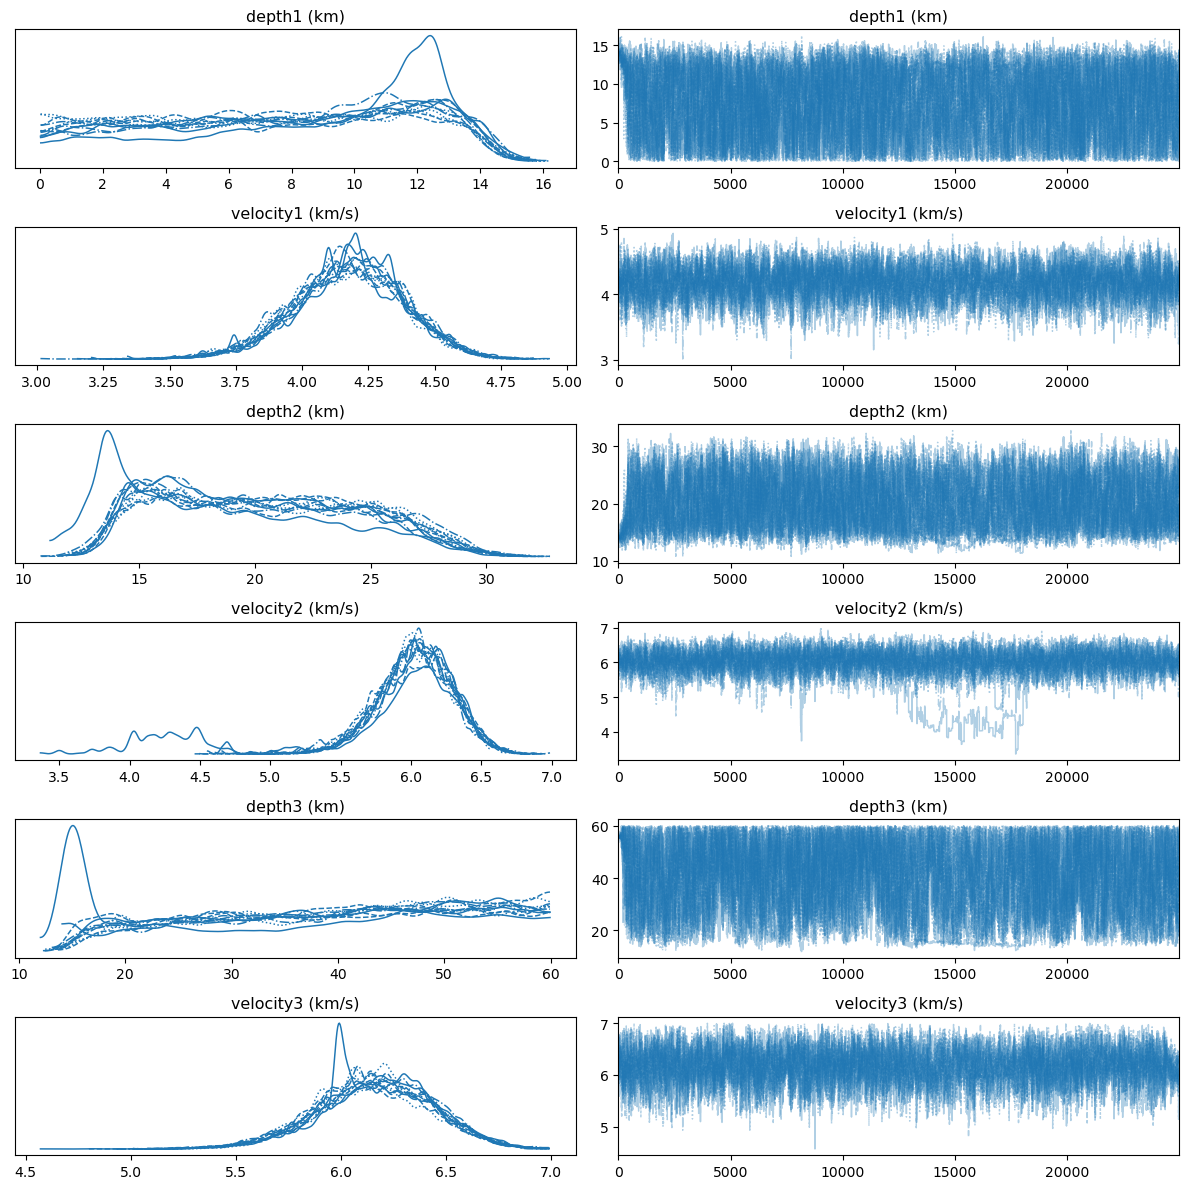

In [19]:
arviz.plot_trace(az_inf_data);
plt.tight_layout();

The walkers start in small distributions around some chosen values and then they quickly wander and start exploring the full posterior distribution. In fact, after a relatively small number of steps, the samples seem pretty well “burnt-in”. That is a hard statement to make quantitatively, but we can look at an estimate of the integrated autocorrelation time (see Emcee's package the -[*Autocorrelation analysis & convergence tutorial*](https://emcee.readthedocs.io/en/stable/tutorials/autocorr/) for more details):

In [20]:
tau = inv_result_sampler.sampler.get_autocorr_time()
print(f"autocorrelation time: {tau}")

autocorrelation time: [165.98220903 144.98367915 182.33705663 396.9762798  325.6204646
 167.1046447 ]


Let’s discard the initial 300 steps and make a corner plot:

Reference good model: [ 8.   4.2 20.   6.  45.   6.2]


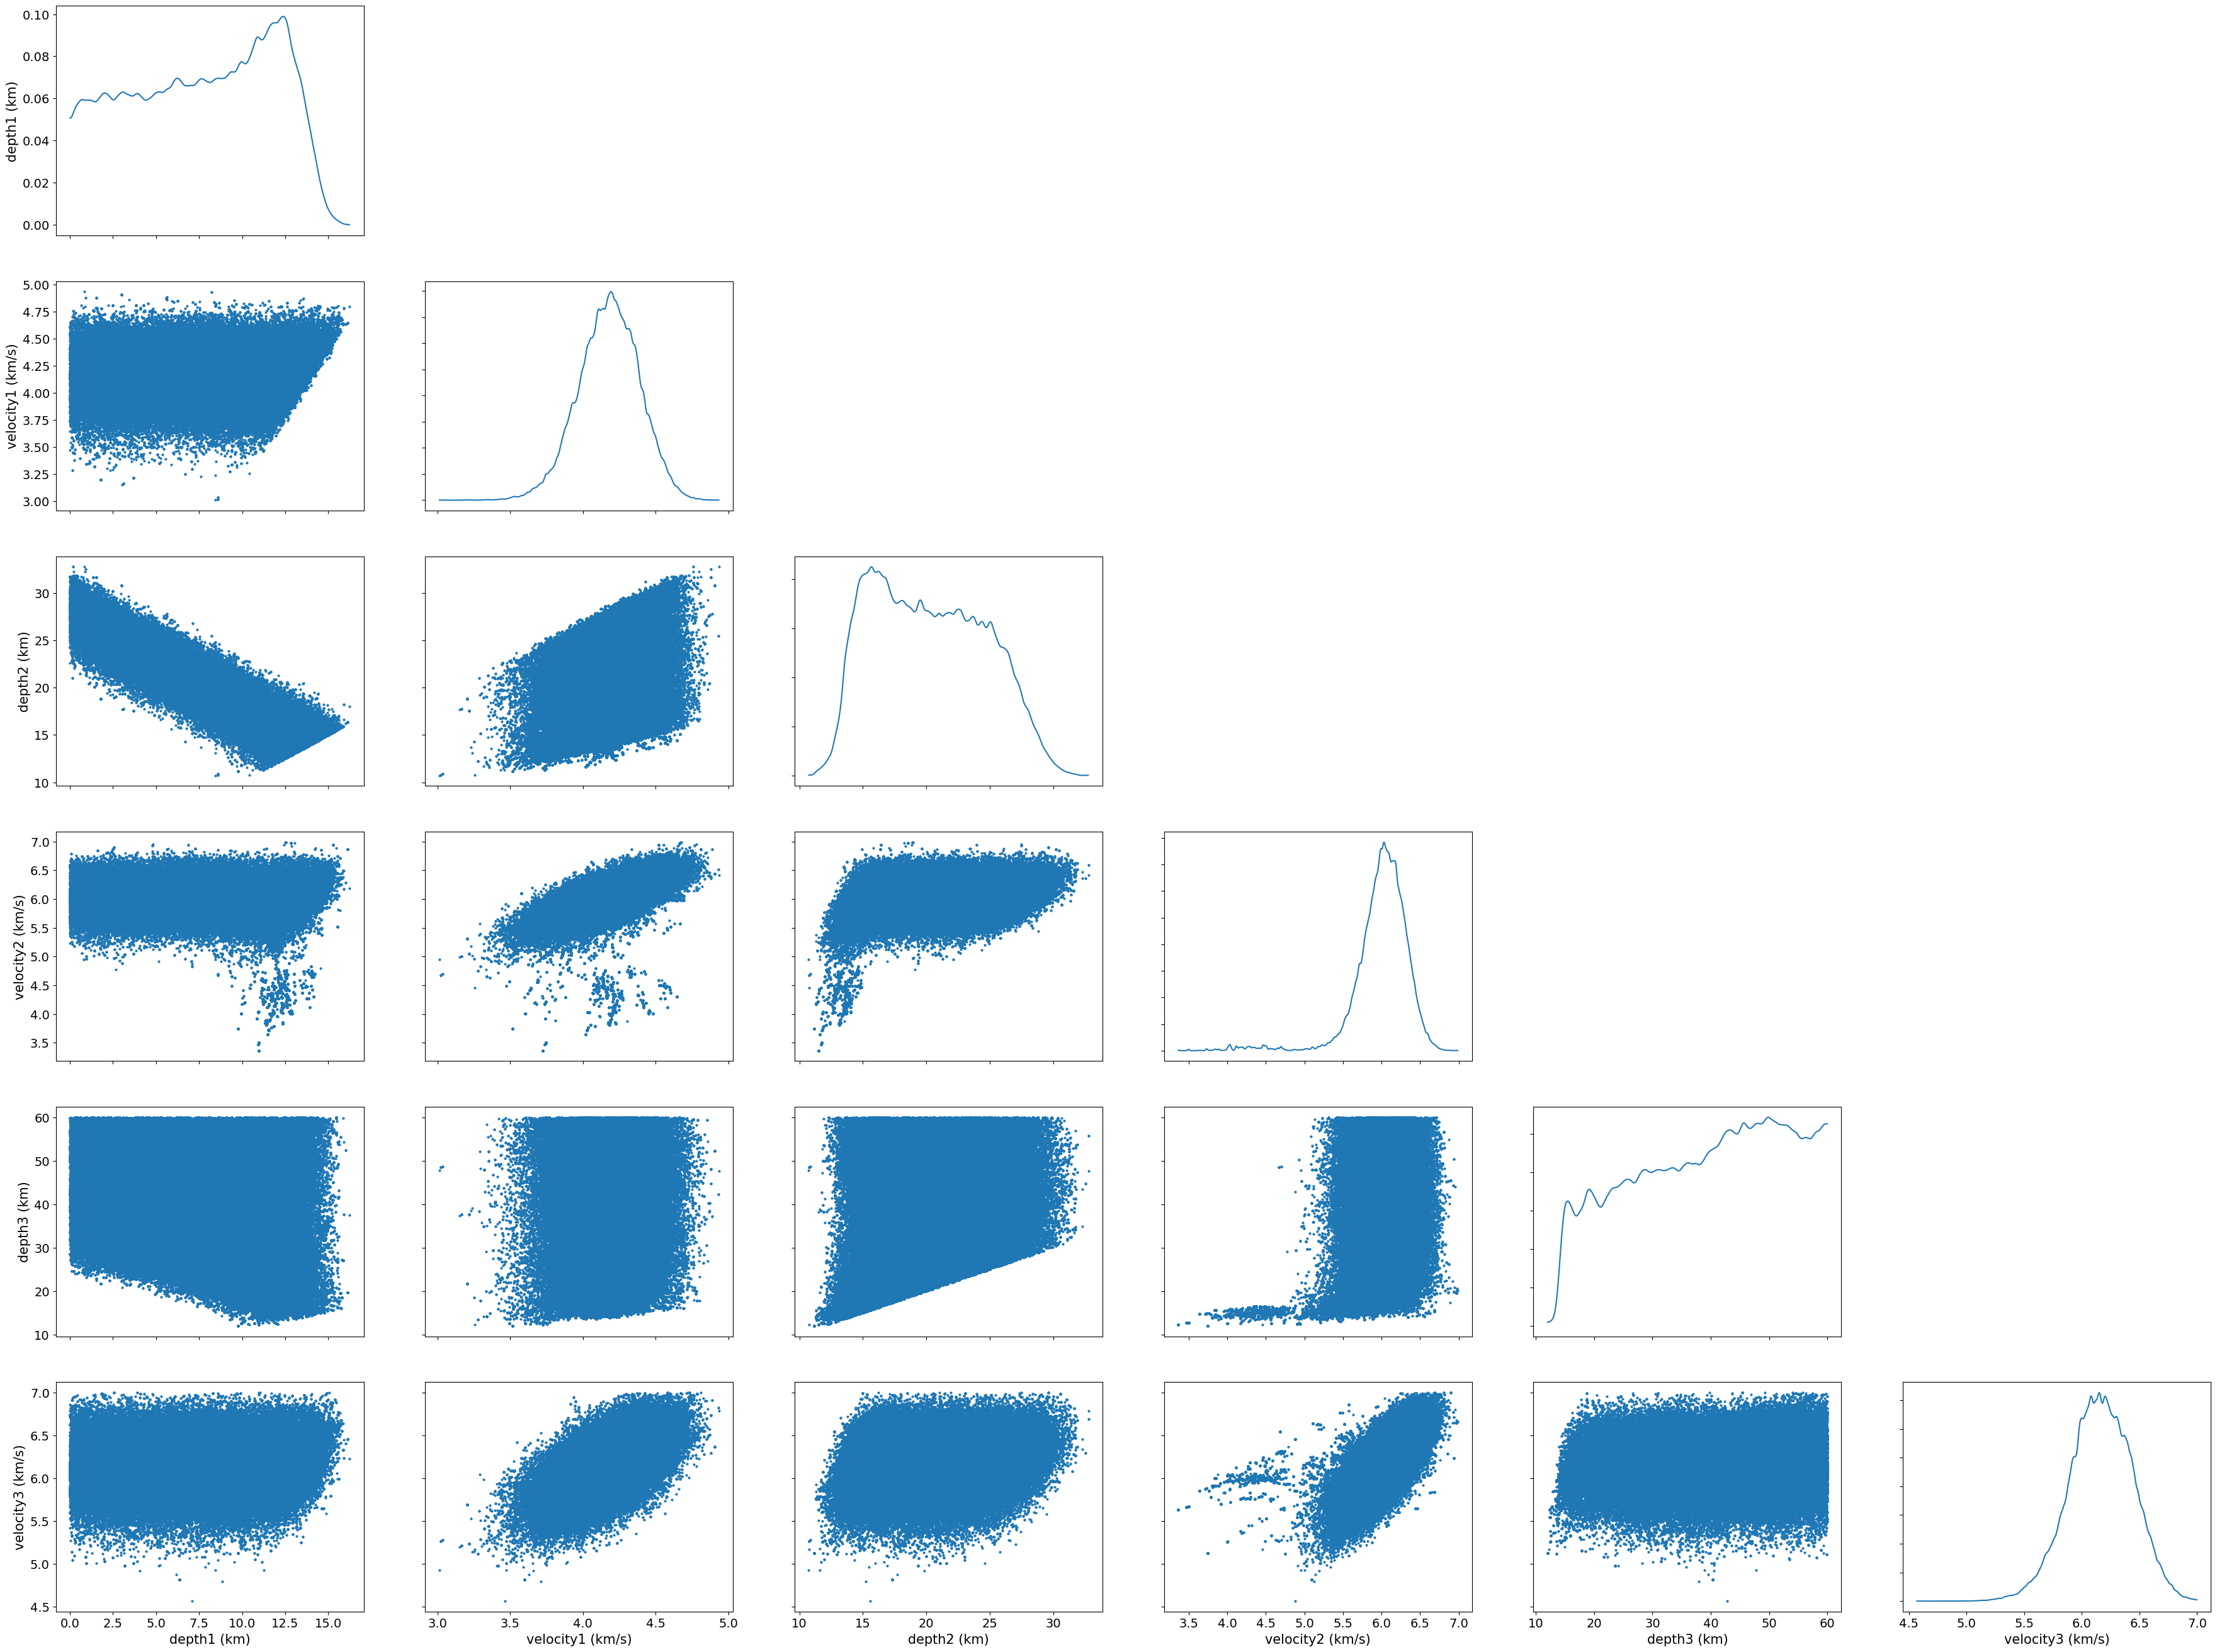

In [21]:
az_inf_data_after_300 = az_inf_data.sel(draw=slice(300,None))

arviz.plot_pair(
    az_inf_data_after_300, 
    marginals=True, 
)

print("Reference good model:", my_receiver_function.good_model)

Mean of samples:      [ 7.72764356  4.1751433  20.14196748  5.99761951 39.36199107  6.16121601]
Reference good model: [ 8.   4.2 20.   6.  45.   6.2]


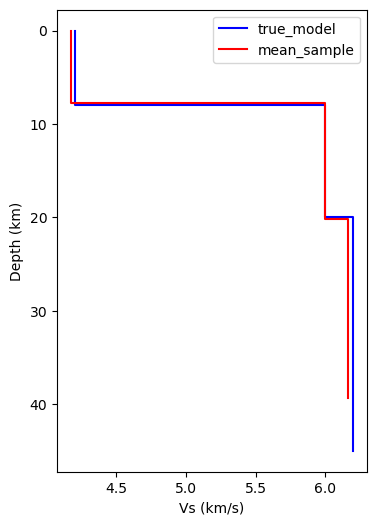

In [22]:
true_model = my_receiver_function.good_model
mean_sample = np.array(az_inf_data["posterior"].mean().to_array())
median_sample = np.array(az_inf_data["posterior"].median().to_array())

print("Mean of samples:     ", mean_sample)
print("Reference good model:", true_model)

my_receiver_function.plot_model(true_model, mean_sample, "true_model", "mean_sample")
plt.legend();

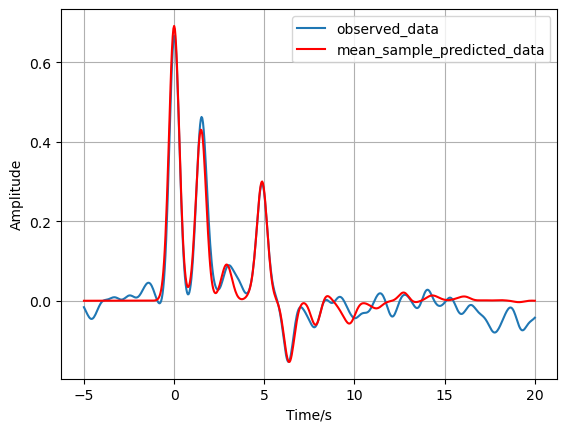

In [23]:
mean_sample_predicted_data = my_receiver_function.forward(mean_sample)
my_receiver_function.plot_data(
    observed_data, 
    mean_sample_predicted_data,
    "observed_data",
    "mean_sample_predicted_data",
);
plt.legend();

---
## Watermark

<!-- Feel free to add more modules in the watermark_list below, if more packages are used -->
<!-- Otherwise please leave the below code cell unchanged -->

In [24]:
watermark_list = ["cofi", "espresso", "numpy", "matplotlib", "emcee", "arviz"]
for pkg in watermark_list:
    pkg_var = __import__(pkg)
    print(pkg, getattr(pkg_var, "__version__"))

cofi 0.2.6
espresso 0.3.11
numpy 1.24.4
matplotlib 3.8.3
emcee 3.1.4
arviz 0.17.0
